# Проект «Обучение с учителем: качество модели»

**Цель и задачи проекта**

Целью настоящего проекта являлась разработка решения которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик» для увеличения их покупательной активности.
   
   Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

   В начале проекта после подготовки данных к исследованию производилась маркировка уровней финансовой активности постоянных покупателей: «снизилась» и «прежний уровень».

   Собирались данные по клиентам по следующим группам: 
   * признаки, которые описывают коммуникацию сотрудников компании с клиентом;
   * признаки, которые описывают продуктовое поведение покупателя;	
   * признаки, описывающие покупательское поведение клиента;
   * признаки, описывающие поведение покупателя на сайте. 

   После чего проводился корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Был  сделан вывод о наличии мультиколлинеарности.

   Далее применялись модели KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC для предсказания вероятности снижения покупательской активности клиентов в последующие три месяца. Для каждой модели подбирался как минимум один гиперпараметр. Для установления лучшей модели осуществлялся аргументированный выбор метрики.
   
   Также была оценена важность признаков для лучшей модели и построен график важности с помощью метода SHAP. После чего были сделаны выводы о значимости признаков.
   
   При выполнении сегментации покупателей использовались результаты моделирования и данные о прибыльности покупателей.
   
   В ходе дальнейшей работы над проектом была выбрана произвольная группа покупателей для формирования ей предложений с целью увеличения покупательной способности. Для этого предварительно проводилось графическое и аналитическое исследование групп.
   
   В заключении проекта были сделаны выводы о сегментах:
   * какие сегменты были выбраны для дополнительного исследования;
   * какие предложения были сделаны покупателям и почему.


## Загрузка и изучение данных

### Загрузка библиотек

In [1]:
# библиотека МО на Python
!pip install --upgrade scikit-learn -q

# библиотека для интерпретации моделей МО
!pip install shap -q

# библиотека для анализа корреляции данных
!pip install phik -q

# библиотека для работы с несбалансированными выборками
!pip install imbalanced-learn

!pip install numpy==1.22.3  # для корректной визуализации по п.7.3.1

!pip install matplotlib==3.5.1 # для корректной визуализации по п.7.3.1

# библиотека визуализации недостающих данных
!pip install missingno

# библиотека с классами и функциями для статистических моделей
!pip install statsmodels

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
# ЗАГРУЗКА БИБЛИОТЕК

import pandas as pd                    # анализ и обработка данных
import matplotlib                      # визуализация данных 
import matplotlib.pyplot as plt        # создание простого интерактивного графика 
import numpy as np                     # работа с многомерными массивами
import seaborn as sns                  # визуализаци данных на основе matplotlib
import sklearn                         # машинное обучение
import shap                            # анализ признаков по Шепли
import phik                            # анализ корреляции данных
import missingno as msno               # визуализация пропусков
import warnings                        # игнорирование предупреждений
warnings.filterwarnings('ignore')


# ЗАГРУЗКА МОДЕЛЕЙ
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# ЗАГРУЗКА МЕТРИК
from sklearn.metrics import accuracy_score, precision_score, \
     recall_score, f1_score, roc_auc_score

# ПРЕОБРАЗОВАНИЕ ДАННЫХ ДЛЯ МО
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
     OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# ПАЙПЛАЙНЫ, ОПТИМИЗАЦИЯ, ОТБОР ПРИЗНАКОВ
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from phik.report import plot_correlation_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

# МОДУЛИ ДЛЯ ПРЕДСТАВЛЕНИЯ ДАННЫХ
from IPython.display import display    #, HTML
pd.set_option('display.float_format', '{:,.2f}'.format)
# display(HTML("<style>.container { width:90% !important; }</style>"))

# УСТАНОВКА КОНСТАНТ
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка файлов, создание датасетов

#### Загрузка данных о поведении покупателя на сайте магазина, формирование датасета market_file

In [3]:
# импорт датасета
try:
    #market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
    #market_file.to_csv('market_file.csv', index=False) 
    market_file = pd.read_csv('market_file.csv', sep=',', decimal='.') 
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',', decimal='.')
    # market_file = market_file.to_csv('market_file.csv', index=False)

In [4]:
market_file.head(3) # первые строки датасета в виде таблицы

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                3.40                     5           121               0.00   
1                4.40                     4           819               0.75   
2                4.90                     3           539               0.14   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5

In [5]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [6]:
# приведение наименований столбцов к единому виду ("змеиная запись" и строчные буквы вместо прописных)
market_file.columns = ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 
                       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
                       'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 
                       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
market_file.head(1) # проверка переименования столбцов

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                3.40                     5           121               0.00   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5

In [7]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

#### Загрузка данных с выручкой от покупателей, формирование датасета market_money

In [8]:
# импорт датасета
try:
    #market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
    #market_money.to_csv('market_money.csv', index=False) 
    market_money = pd.read_csv('market_money.csv', sep=',', decimal='.')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',', decimal='.')
    # market_money.to_csv('market_money.csv.csv', index=False)

In [9]:
market_money.head(6) # первые строки датасета в виде таблицы

id               Период  Выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60
5  215349     предыдущий_месяц 5,216.00

In [10]:
market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [11]:
# приведение наименований столбцов к единому виду ("змеиная запись" и строчные буквы вместо прописных)
market_money.columns = ['id', 'период', 'выручка']
market_money.head(1) # проверка переименования

id               период  выручка
0  215348  препредыдущий_месяц     0.00

In [12]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


#### Загрузка данных проведенном покупателями времени на сайте, формирование датасета market_time

In [13]:
# импорт датасета
try:
    #market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
    #market_time.to_csv('market_time.csv', index=False) 
    market_time = pd.read_csv('market_time.csv', sep=',', decimal='.')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',', decimal='.')
    # market_time.to_csv('market_time.csv.csv', index=False)

In [14]:
market_time.head(4) # первые строки датасета в виде таблицы

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12

In [15]:
market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [16]:
# приведение наименований столбцов к единому виду ("змеиная запись" и строчные буквы вместо прописных)
market_time.columns = ['id', 'период', 'минут']
market_time.head(1) # проверка переименования столбцов

id         период  минут
0  215348  текущий_месяц     14

In [17]:
market_time.info() # вывод общей информации о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


#### Загрузка данных по прибыли магазина по каждому покупателю, формирование датасета money

In [18]:
# импорт датасета
try:
    #money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
    #money.to_csv('money.csv', index=False) 
    money = pd.read_csv('money.csv', sep=';', decimal=',')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
    # market_time.to_csv('market_time.csv.csv', index=False)

In [19]:
money.head(3) # первые строки датасета в виде таблицы

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13

In [20]:
money.columns

Index(['id', 'Прибыль'], dtype='object')

In [21]:
# приведение наименований столбцов к единому виду (без заглавных букв)
money.columns = ['id', 'прибыль']
money.head(1) # проверка переименования столбцов

id  прибыль
0  215348     0.98

In [22]:
money.info() # вывод общей информации о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Выводы:

**1.** Данные введены корректно, пропуски отсутствуют. Сформированы датасеты **market_file, market_money, market_time, money**.

**2.** Количество строк в датасетах не одинаковое (кроме **market_file** и **money**), но кратно 2 или 3. Обусловлено тем, что в **market_money** и **market_time** на один **id** приходится по 3 или 2 строки с данными, в зависимости от значений периодичности по признаку **'период'**. 

**3.** При первичном ознакомлении с данными сделан вывод, что все признаки в датасетах имеют отношение к содержанию поставленных задач исследования.

**4.** Данные в таблицах соответствуют описанию. Значения признаков всех импортиованных датасетов имеют надлежащие типы данных.

**5.** Названия всех признаков (столбцов) приведены к одному виду ("змеиная запись" и строчные буквы вместо прописных).

## Предобработка данных

### Проверка данных датафреймов на наличие пропусков

In [23]:
# Функция проверки наличия пропусков в датафреймах
def chec_nan(list_3, list_4):
    for i, k in zip(list_3, list_4):                # цикл с перебором датафреймов при проверке
        print()
        print(f'Проверка датафрейма {k} на наличие пропусков:')
        print(i.isna().sum())                       # проверка очередного датафрейма
    return

<AxesSubplot:>

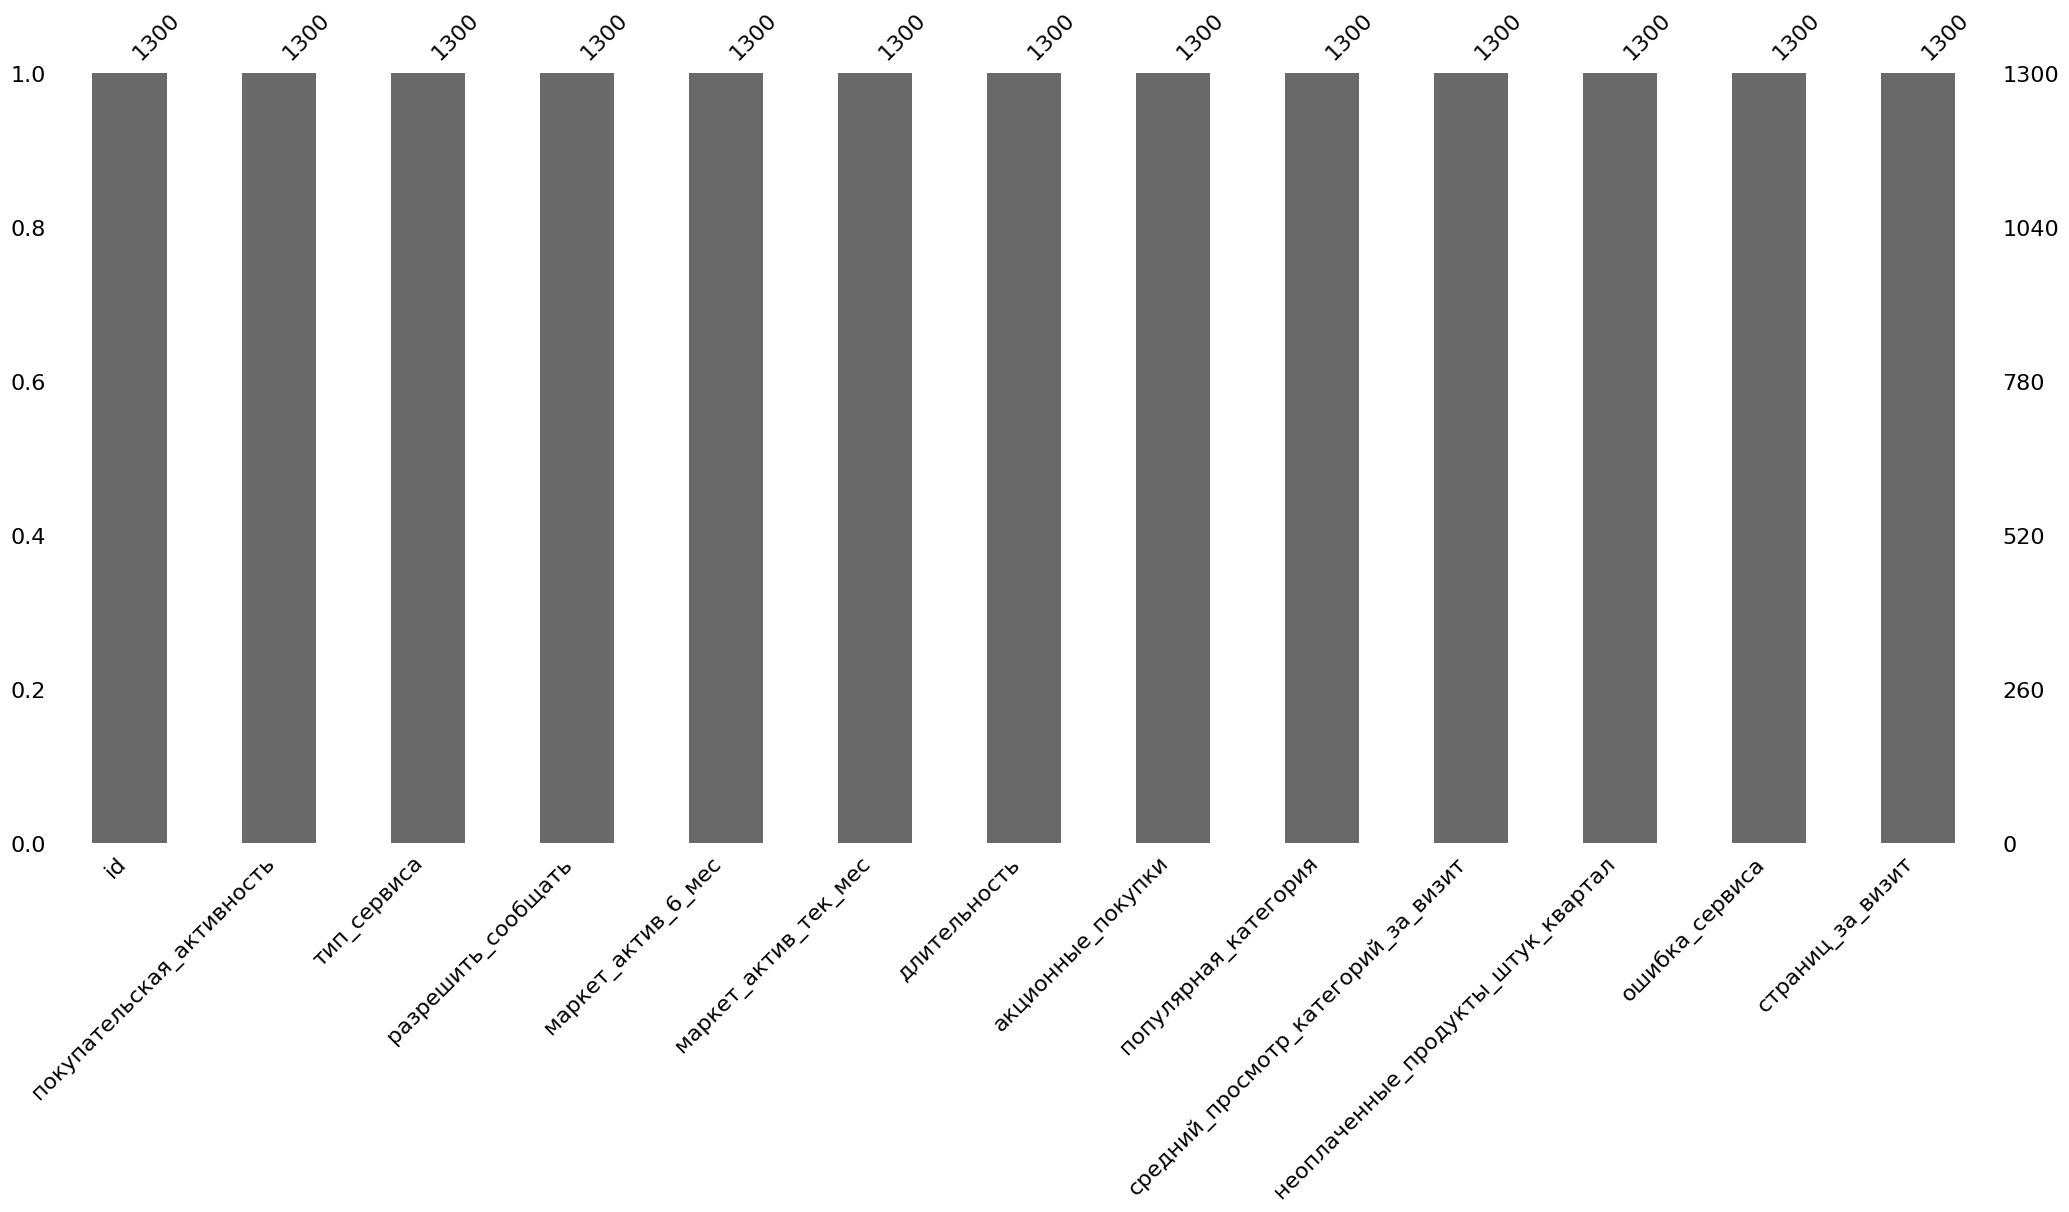

In [24]:
msno.bar(market_file)      #heatmap(market_file)

<AxesSubplot:>

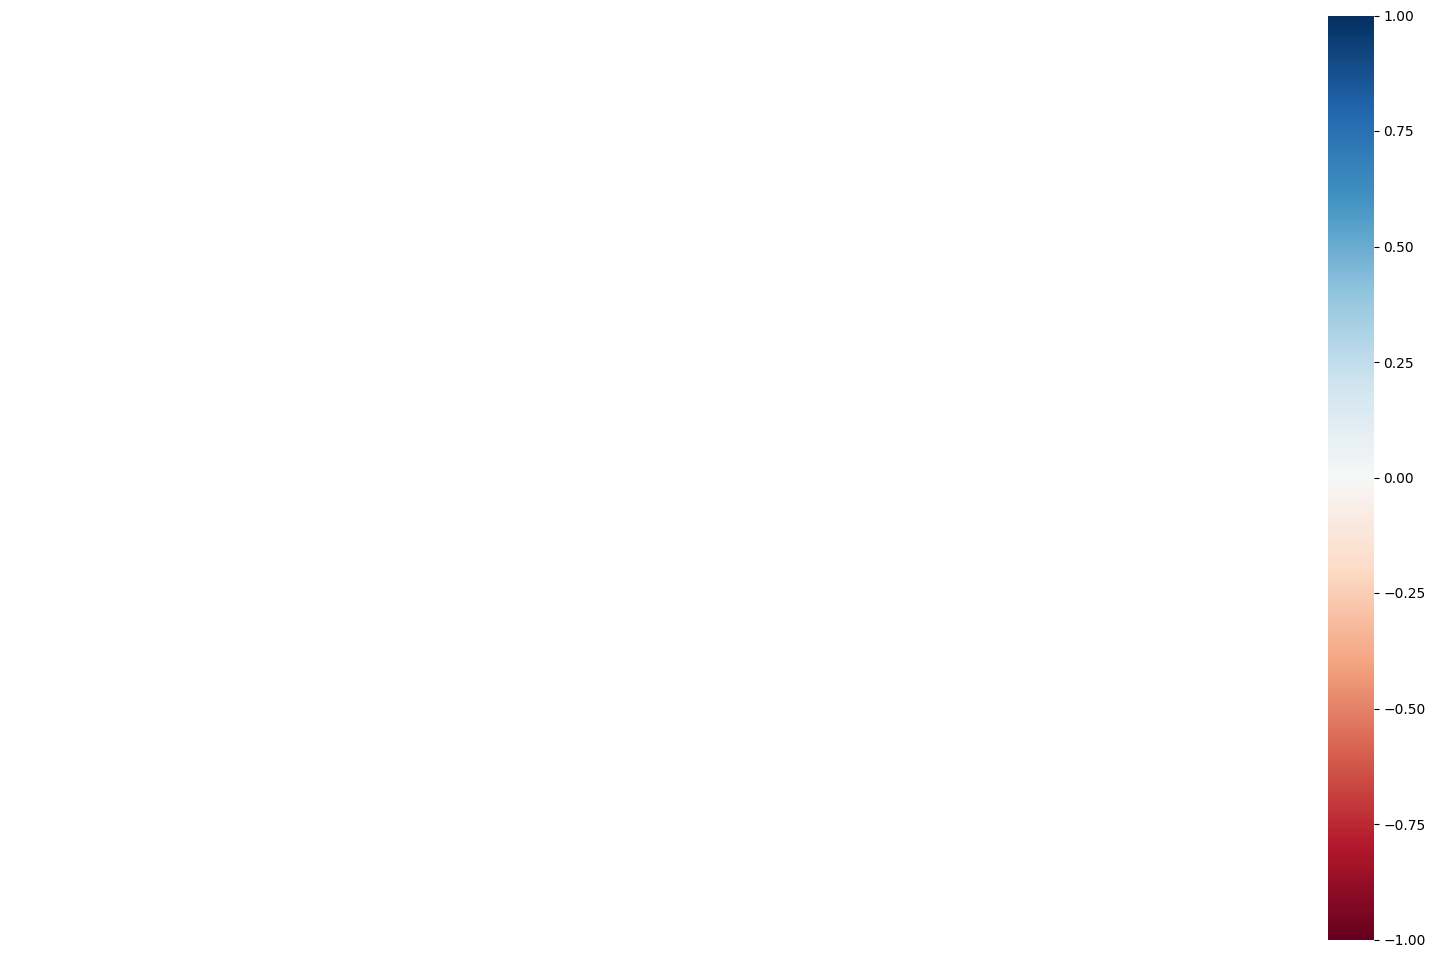

In [25]:
# пропусков нет (все белое)
msno.heatmap(market_file)

In [26]:
list_1 = [market_file, market_money, market_time, money]          # список датафреймов 
list_2 = ["market_file", "market_money", "market_time", "money"]    # список названий датафреймов
chec_nan(list_1, list_2)              # вызов функции поиска пропусков


Проверка датафрейма market_file на наличие пропусков:
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

Проверка датафрейма market_money на наличие пропусков:
id         0
период     0
выручка    0
dtype: int64

Проверка датафрейма market_time на наличие пропусков:
id        0
период    0
минут     0
dtype: int64

Проверка датафрейма money на наличие пропусков:
id         0
прибыль    0
dtype: int64


### Проверка датафреймов на наличие полных дубликатов

In [27]:
# Функция проверки наличия полных дубликатов в датафреймах
def chec_dupl(list_3, list_4):
    print()
    for i, k in zip(list_3, list_4):                # цикл с перебором датафреймов при проверке
        print(f'Проверка датафрейма {k} на наличие полных дубликатов: {i.duplicated().sum()}')
    return

In [28]:
list_1 = [market_file, market_money, market_time, money]          # список датафреймов 
list_2 = ["market_file", "market_money", "market_time", "money"]    # список названий датафреймов
chec_dupl(list_1, list_2)             # вызов функции поиска полных дубликатов


Проверка датафрейма market_file на наличие полных дубликатов: 0
Проверка датафрейма market_money на наличие полных дубликатов: 0
Проверка датафрейма market_time на наличие полных дубликатов: 0
Проверка датафрейма money на наличие полных дубликатов: 0


### Проверка наличия неявных дубликатов в столбцах датафреймов с категориальными данными

#### Функция поиска неявных дубликатов значений в категориальных столбцах датафреймов

In [29]:
# Функция поиска неявных дубликатов в столбцах, вывод уникальных значений
def chec_implicit_dupl(df_name):
    # список столбцов датафрейма
    list_1 = df_name.select_dtypes(exclude='number').columns.tolist()
    # цикл с перебором столбцов при проверке
    for i in list_1: 
        print(f'Уникальные значения в столбце "{i}": {df_name[i].unique()}')
    return

#### Проверка датафрейма market_file

In [30]:
chec_implicit_dupl(market_file)     # вызов функции поиска неявных дубликатов

Уникальные значения в столбце "покупательская_активность": ['Снизилась' 'Прежний уровень']
Уникальные значения в столбце "тип_сервиса": ['премиум' 'стандартт' 'стандарт']
Уникальные значения в столбце "разрешить_сообщать": ['да' 'нет']
Уникальные значения в столбце "популярная_категория": ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [31]:
# обнаружение неявных дубликатов 'стандартт'
market_file['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [32]:
# устранение неявных дубликатов в столбце 'тип_сервиса', переименование значений
market_file['тип_сервиса'] = (market_file['тип_сервиса'].replace('стандартт', 'стандарт'))
market_file['тип_сервиса'].unique()     # проверка устранения неявного дубликата

array(['премиум', 'стандарт'], dtype=object)

#### Проверка датафрейма market_money

In [33]:
chec_implicit_dupl(market_money)          # вызов функции поиска неявных дубликатов

Уникальные значения в столбце "период": ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


#### Проверка датафрейма market_time

In [34]:
chec_implicit_dupl(market_time)   

Уникальные значения в столбце "период": ['текущий_месяц' 'предыдцщий_месяц']


In [35]:
# устранение неявных дубликатов в столбце 'тип_сервиса', переименование значений
market_time['период'] = (market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц'))
market_time['период'].unique()     # проверка устранения неявного дубликата

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

### Выводы:

**1.** Данные в датафреймах полных дубликатов не содержат.

**2.** В датафрейме **market_file** в столбце *'тип_сервиса'* обнаружены неявные дубликаты категориальных значений ('стандартт' - 10 шт.), которые путем приведения к одному значению ('стандарт') устранены.

## Исследовательский анализ данных

Объектом исследования, согласно заданию к проекту, являются данные по клиентам с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Таким образом, перед проведением исследовательского анализа данных и работой по проекту в целом необходимо "отсечь" данные клиентов, покупательская активность которых не приходится на этот период. Отсев таких клиентов можно осуществить на основании датафрейма **market_money**, который содержит помесячную выручку по покупателям за последние 3 месяца. 

В п.3.1 сначала была осуществлена проверка датафреймов **market_file, market_money, market_time** на наличие дубликатов по столбцу **id** с учетом кратности значений в нем из-за разнесения данных по периодам в столбце **период**. Далее датафрейм **market_money** был преобразован в таблицу **new_market_money** с внесением в созданные столбцы помесячных выручек по покупателям. После чего было проведено присоединение столбцов таблицы **new_market_money** к таблице **market_file** с образованием датафрема **df** (объединение в **df** данных будет использовано в дальнейшем). 

И в завершении объединения к таблице **df** были добавлены данные из датафрейма **market_time**.

### Объединение данных датафреймов market_file,  market_money, market_time в общую таблицу df и отбор данных по покупателям с покупательской активностью не менее 3 меяцев

####  Объединение данных датафреймов market_file, market_money, market_time в общую таблицу df 

In [36]:
# проверка отсутствия дубликатов 'id' в датасете market_file
market_file['id'].duplicated().sum() 

0

In [37]:
# проверка отсутствия дубликатов 'id' в датасете market_money
market_money.value_counts().count()/3 - 1300

0.0

In [38]:
# проверка отсутствия дубликатов 'id' в датасете market_time
market_time.value_counts().count()/2 - 1300  

0.0

In [39]:
# создание на основе датафрейма market_file таблицы df, в которой будут включены данные из других датафреймов
df = market_file

In [40]:
# назначение индексом признака 'id' в д/ф df
df = df.set_index('id')
df.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                3.40                     5           121   
215349                4.40                     4           819   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
id                                                                            
215348                                   2               1                 5  
215349                                   4               2                 5

In [41]:
market_money.head(6) # первые строки датасета market_money в виде таблицы

id               период  выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60
5  215349     предыдущий_месяц 5,216.00

In [42]:
# создание из д/ф market_money таблицы со столбцами по выручке за каждый период и проверка
new_market_money = market_money.pivot_table(index='id', columns='период', values='выручка')
new_market_money.head(2)

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215348              0.00                 0.00       3,293.10
215349          5,216.00             4,472.00       4,971.60

In [43]:
# форма таблицы df до объединения
df.shape  

(1300, 12)

In [44]:
# форма таблицы new_market_money до объединения
new_market_money.shape

(1300, 3)

In [45]:
# присоединение к таблице df таблицы new_market_money с выручкой по 3 последним месяцам
df = df.join(new_market_money)
df.head(2) # контроль результата объединения таблиц

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                3.40                     5           121   
215349                4.40                     4           819   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     Товары для детей   
215349               0.75     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215348                                   2               1                 5   
215349                                   4               2                 5   

        предыдущий_месяц  препредыдущий_месяц  текущий_месяц  
id                                                            
215348              0.00                 0.00       3,293.10  
215349          5,216.00             4,472.00       4,971.60

In [46]:
# форма таблицы после объединения
df.shape  

(1300, 15)

In [47]:
# переименование столбцов df для избежания одинаковых наименований при объединении с таблицей market_time
df.columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
              'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
              'акционные_покупки', 'популярная_категория', 'сред_просм_кат_за_визит',
              'неоплач_прод_кварт', 'ошибка_сервиса', 'страниц_за_визит', 
              'выручка_пред_месяц', 'выручка_препред_месяц','выручка_тек_месяц']
df.columns # проверка результата переименования

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория', 'сред_просм_кат_за_визит',
       'неоплач_прод_кварт', 'ошибка_сервиса', 'страниц_за_визит',
       'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц'],
      dtype='object')

In [48]:
# первые строки датасета market_time в виде таблицы
market_time.head(4) 

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12

In [49]:
# создание из д/ф market_time таблицы со столбцами по времени, проведенном на сайте
new_market_time = market_time.pivot_table(index='id', columns='период', values='минут')
new_market_time.head(2)

период  предыдущий_месяц  текущий_месяц
id                                     
215348                13             14
215349                12             10

In [50]:
# переименование столбцов
new_market_time.columns = ['время_пред_месяц', 'время_тек_месяц']
new_market_time.columns # проверка результата переименования

Index(['время_пред_месяц', 'время_тек_месяц'], dtype='object')

In [51]:
# форма new_market_time до присоединения к df
new_market_time.shape

(1300, 2)

In [52]:
# присоединение к таблице df таблицы new_market_time
df = df.merge(new_market_time, on='id')
df.head(3)  # проверка результата слияния

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                3.40                     5           121   
215349                4.40                     4           819   
215350                4.90                     3           539   

        акционные_покупки популярная_категория  сред_просм_кат_за_визит  \
id                                                                        
215348               0.00     Товары для детей                        6   
215349               0.75     Товары для детей                        4   
215350               0.14    Домашний текстиль                        5   

        неоплач_прод_кварт  ошибка_сервиса  страниц_за_визит  \
id                                                             
215348                   2               1                 5   
215349                   4               2                 5   
215350                   2               1                 5   

        выручка_пред_месяц  выручка_препред_месяц  выручка_тек_месяц  \
id                                                                     
215348                0.00                   0.00           3,293.10   
215349            5,216.00               4,472.00           4,971.60   
215350            5,457.50               4,826.00           5,058.40   

        время_пред_месяц  время_тек_месяц  
id                                         
215348                13               14  
215349                12               10  
215350                 8               13

In [53]:
# форма df после присоединения new_market_time
df.shape

(1300, 17)

In [54]:
# назначение индексом признака 'id' в д/ф money
money = money.set_index('id')

# присоединение к таблице df таблицы money с прибылью по покупателям по 3 последним месяцам
df = df.join(money)
df.head(2) # контроль результата объединения таблиц

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 Снизилась     премиум                 да   
215349                 Снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                3.40                     5           121   
215349                4.40                     4           819   

        акционные_покупки популярная_категория  сред_просм_кат_за_визит  \
id                                                                        
215348               0.00     Товары для детей                        6   
215349               0.75     Товары для детей                        4   

        неоплач_прод_кварт  ошибка_сервиса  страниц_за_визит  \
id                                                             
215348                   2               1                 5   
215349                   4               2                 5   

        выручка_пред_месяц  выручка_препред_месяц  выручка_тек_месяц  \
id                                                                     
215348                0.00                   0.00           3,293.10   
215349            5,216.00               4,472.00           4,971.60   

        время_пред_месяц  время_тек_месяц  прибыль  
id                                                  
215348                13               14     0.98  
215349                12               10     4.16

In [55]:
# форма df после присоединения money
df.shape

(1300, 18)

#### Отбор данных по покупателям с покупательской активностью не менее 3 меяцев¶

In [56]:
# удаление в df данных по покупателям с нулевой покупательной активностью 
# хотя бы в одном из 3 месяцев
df = df.loc[(df['выручка_пред_месяц'] > 0) & (df[
    'выручка_препред_месяц'] > 0) & (df['выручка_тек_месяц'] > 0)]

# форма таблицы после удаления данных, не удовлетворяющих условию
df.shape

(1297, 18)

In [57]:
# "сброс" индекса
df = df.reset_index(drop =True)

**Результат.** Из таблица **df** удалены три строки, не удовлетворяющие условию.

*Результат.*

**1.** Объединение датасетов произведено с образованием таблицы исходных данных **df**, которая может быть использована для исследовательского анализа данных и дальнейшей работы.

**2.** Из итогового датафрейма удалены три строки по покупателям с покупательской активностью менее 3 мес.

**3.** При ознакомлении с датафреймом **market_file** в признаке **покупательская_активность** было обнаружено последовательное следование сначала строк со значением этого признака 'Снизилась', а затем со значениями 'Прежний уровень'. При разбиении данных на выборки перед началом моделирования необходимо проведение стратификации данных. 

**4.** В завершении данного раздела произведен "сброс" индекса.

### Количественные признаки данных датафрема df

#### Функция графического представления непрерывных количественных признаков

In [58]:
def cat_numeric(
    cat_column, 
    df_val
    ) -> str:
    """ Функция  графического представления количественных признаков
        (... необходимые детали алгоритма, если нужо ...)
    Args:
        cat_column: столбец датафрейма со значениями по признаку
        df_val: название признака
    Returns:
        plots: Построение гистограммы и боксплота по признаку 
    Rises:
        ValueError: Какие ошибки могут возникнуть во время работы функции 
                    и какой Error или Exception мы можем ожидать
    """   
    
    array_gr = cat_column.to_numpy()
    plt.figure(figsize=(10, 7))
    bins =  plt.hist(array_gr, bins=50)
    plt.vlines(x=array_gr.mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(),  label='Среднее значение')
    plt.title(f'Гистограмма распределения признака {df_val}')
    plt.legend()
    plt.ylabel('частота')
    plt.xlabel('значения признака')
    plt.show()
    plt.figure(figsize=(10, 3))
    plt.title(f'Boxplot для признака {df_val}')
    plt.boxplot(array_gr, vert=False)
    plt.xlabel('значения признака')
    plt.show()
    return

In [59]:
print(cat_numeric.__doc__)

 Функция  графического представления количественных признаков
        (... необходимые детали алгоритма, если нужо ...)
    Args:
        cat_column: столбец датафрейма со значениями по признаку
        df_val: название признака
    Returns:
        plots: Построение гистограммы и боксплота по признаку 
    Rises:
        ValueError: Какие ошибки могут возникнуть во время работы функции 
                    и какой Error или Exception мы можем ожидать
    


In [60]:
help(cat_numeric)

Help on function cat_numeric in module __main__:

cat_numeric(cat_column, df_val) -> str
    Функция  графического представления количественных признаков
        (... необходимые детали алгоритма, если нужо ...)
    Args:
        cat_column: столбец датафрейма со значениями по признаку
        df_val: название признака
    Returns:
        plots: Построение гистограммы и боксплота по признаку 
    Rises:
        ValueError: Какие ошибки могут возникнуть во время работы функции 
                    и какой Error или Exception мы можем ожидать



#### Функция графического представления дискретных количественных признаков

In [61]:
def cat_discr_numeric(discr_column):
    plt.figure(figsize=(12, 5))
    sns.countplot(x=discr_column, data=df, hue = 'покупательская_активность')
    plt.title(f'Гистограмма распределения признака "{discr_column}"')
    plt.ylabel('частота')
    plt.xlabel('значения признака')
    plt.show()
    return

#### Ознакомление с общими статистическими характеристиками количественных признаков

In [62]:
df.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
0                 Снизилась     премиум                 да   
1                 Снизилась    стандарт                нет   
2                 Снизилась    стандарт                 да   
3                 Снизилась    стандарт                нет   
4                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                4.40                     4           819               0.75   
1                4.90                     3           539               0.14   
2                3.20                     5           896               0.99   
3                5.10                     3          1064               0.94   
4                3.30                     4           762               0.26   

  популярная_категория  сред_просм_кат_за_визит  неоплач_прод_кварт  \
0     Товары для детей                        4                   4   
1    Домашний текстиль                        5                   2   
2     Товары для детей                        5                   0   
3     Товары для детей                        3                   2   
4    Домашний текстиль                        4                   1   

   ошибка_сервиса  страниц_за_визит  выручка_пред_месяц  \
0               2                 5            5,216.00   
1               1                 5            5,457.50   
2               6                 4            6,158.00   
3               3                 2            5,807.50   
4               1                 4            4,738.50   

   выручка_препред_месяц  выручка_тек_месяц  время_пред_месяц  \
0               4,472.00           4,971.60                12   
1               4,826.00           5,058.40                 8   
2               4,793.00           6,610.40                11   
3               4,594.00           5,872.50                 8   
4               5,124.00           5,388.50                10   

   время_тек_месяц  прибыль  
0               10     4.16  
1               13     3.13  
2               13     4.87  
3               11     4.21  
4               10     3.95

In [63]:
# обзор основных характеристик значений в числовых столбцах
df.describe().T

count     mean      std      min      25%      50%  \
маркет_актив_6_мес      1,297.00     4.25     1.02     0.90     3.70     4.20   
маркет_актив_тек_мес    1,297.00     4.01     0.70     3.00     4.00     4.00   
длительность            1,297.00   602.99   249.10   121.00   410.00   607.00   
акционные_покупки       1,297.00     0.32     0.25     0.11     0.17     0.24   
сред_просм_кат_за_визит 1,297.00     3.27     1.35     1.00     2.00     3.00   
неоплач_прод_кварт      1,297.00     2.84     1.97     0.00     1.00     3.00   
ошибка_сервиса          1,297.00     4.18     1.95     0.00     3.00     4.00   
страниц_за_визит        1,297.00     8.19     3.98     1.00     5.00     8.00   
выручка_пред_месяц      1,297.00 4,948.34   701.23 2,890.00 4,498.50 5,005.50   
выручка_препред_месяц   1,297.00 4,836.37   333.44 4,098.00 4,585.00 4,812.00   
выручка_тек_месяц       1,297.00 5,316.45 2,942.47 2,758.70 4,706.60 5,180.30   
время_пред_месяц        1,297.00    13.47     3.94     5.00    11.00    13.00   
время_тек_месяц         1,297.00    13.21     4.22     4.00    10.00    13.00   
прибыль                 1,297.00     4.00     1.01     0.86     3.30     4.04   

                             75%        max  
маркет_актив_6_мес          4.90       6.60  
маркет_актив_тек_мес        4.00       5.00  
длительность              806.00   1,079.00  
акционные_покупки           0.30       0.99  
сред_просм_кат_за_визит     4.00       6.00  
неоплач_прод_кварт          4.00      10.00  
ошибка_сервиса              6.00       9.00  
страниц_за_визит           11.00      20.00  
выручка_пред_месяц      5,409.00   6,869.50  
выручка_препред_месяц   5,055.00   5,663.00  
выручка_тек_месяц       5,761.30 106,862.20  
время_пред_месяц           17.00      23.00  
время_тек_месяц            16.00      23.00  
прибыль                     4.67       7.43

*Результат:*

**1.** Обнаружено существенное различие значений медианы и средней у признака **'акционные_покупки'**. Возможно присутствуют выбросы. Необходимо обратить внимание в дальнейшем.

**2.** В признаке **'выручка_тек_месяц'** обнаружено аномально высокое максимальное значение равное **106 862 руб.**.

In [64]:
# количественные признаки
df.select_dtypes(include='number').columns.tolist()

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'сред_просм_кат_за_визит',
 'неоплач_прод_кварт',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_пред_месяц',
 'выручка_препред_месяц',
 'выручка_тек_месяц',
 'время_пред_месяц',
 'время_тек_месяц',
 'прибыль']

#### Признак "маркет актив 6 мес"

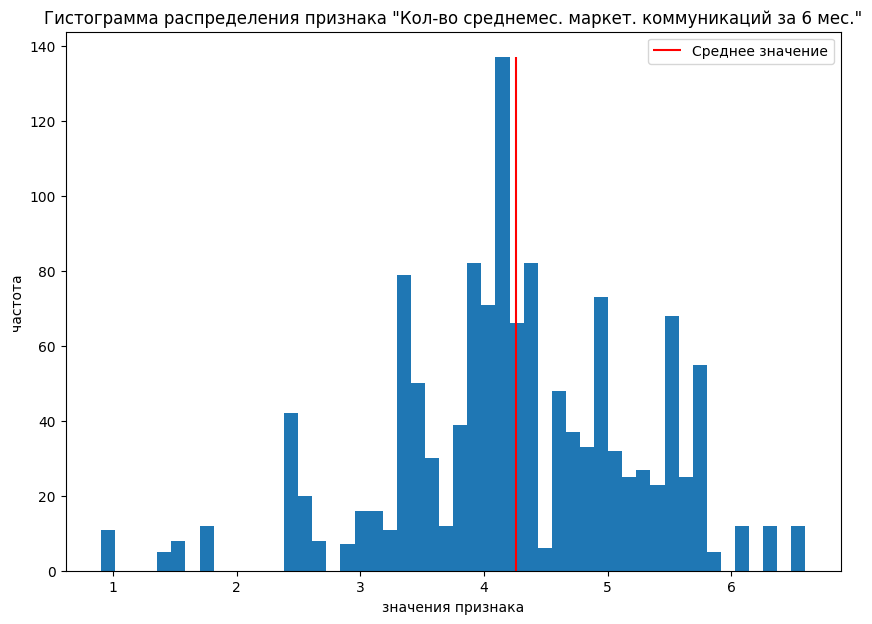

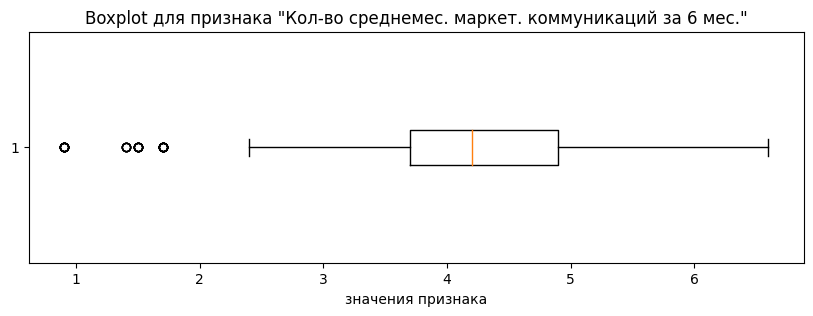

In [65]:
cat_numeric(df['маркет_актив_6_мес'], '"Кол-во среднемес. маркет. коммуникаций за 6 мес."')

*Результат.* Отмечаются выбросы слева от медианы.

#### Признак "маркет_актив_тек_мес"

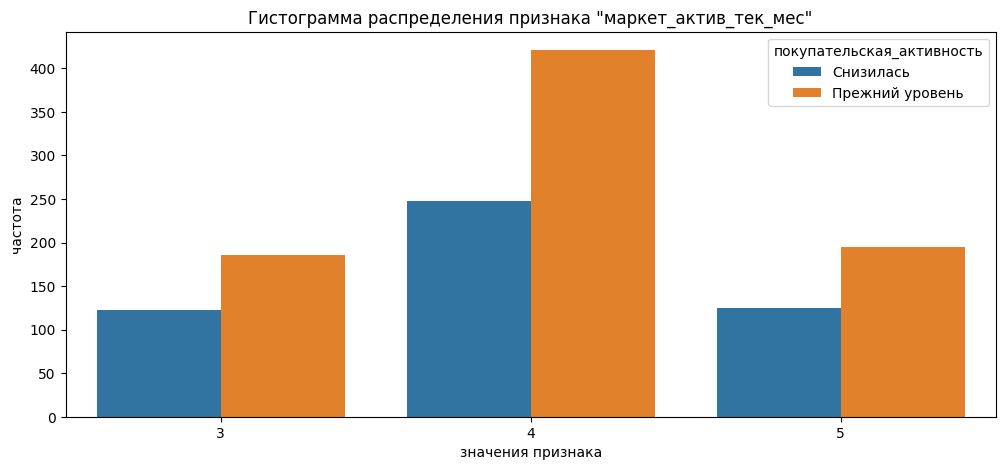

In [66]:
cat_discr_numeric('маркет_актив_тек_мес')

#### Признак "длительность"

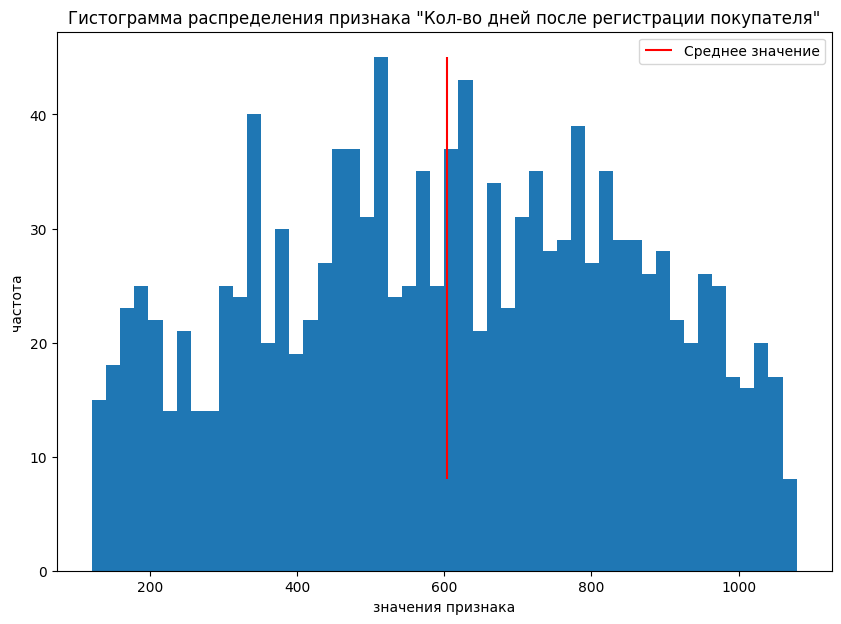

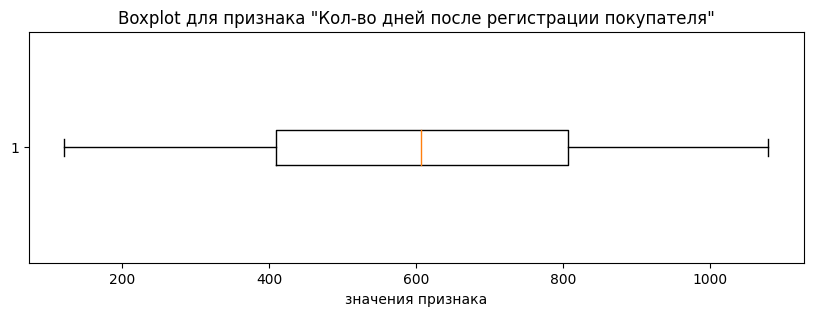

In [67]:
cat_numeric(df['длительность'], '"Кол-во дней после регистрации покупателя"')

#### Признак "акционные_покупки"	

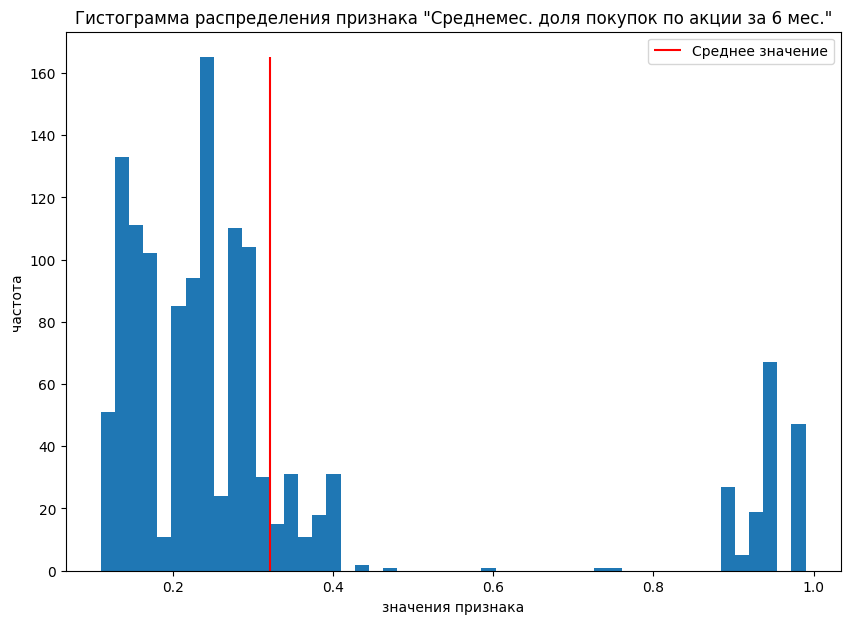

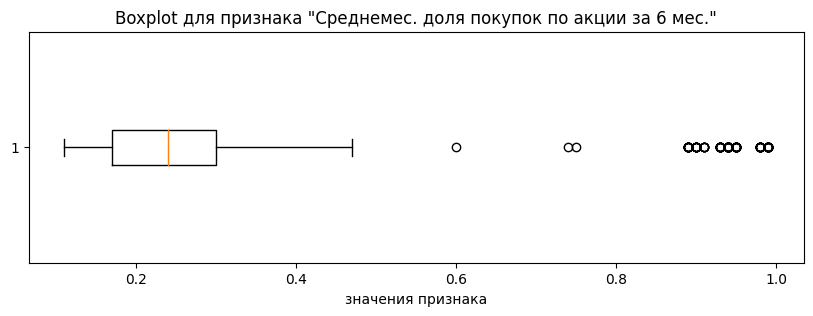

In [68]:
cat_numeric(df['акционные_покупки'], '"Среднемес. доля покупок по акции за 6 мес."')

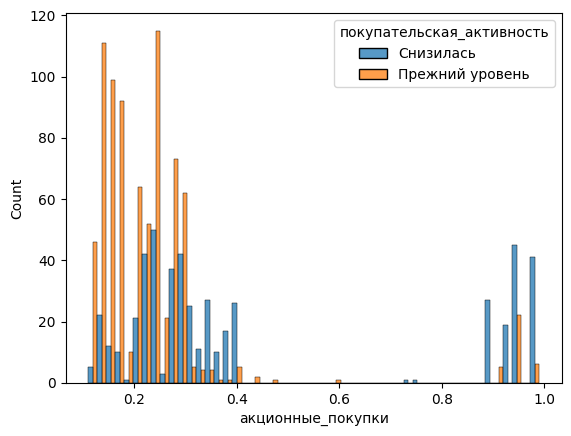

In [69]:
sns.histplot(data = df, x = 'акционные_покупки', hue='покупательская_активность', bins=50, multiple='dodge');

*Результат.* Выявлена кластеризация данных признака по двум категориям (правый кластер не  выброс). В связи с чем, на основе этого признака был создан дополнительный бинарный признака признак **'акц_пок_бин'**, **0** признаку присваивался при значениях признака **'акционные_покупки'** ниже **0.6** и **1** - при превышении этого предела. Однако, при построении матрицы корреляции в п.4.2 эти два признака оказались **мультиколлениарными**, причем связь бинарного признака **'акц_пок_бин'** с целевым (0,49) оказалась слабее связи признака **'акционные_покупки'** (0,51). В связи с этим, признак **'акц_пок_бин'** был исключен из датафрейма **df**.

#### Признак "сред_просм_кат_за_визит"	

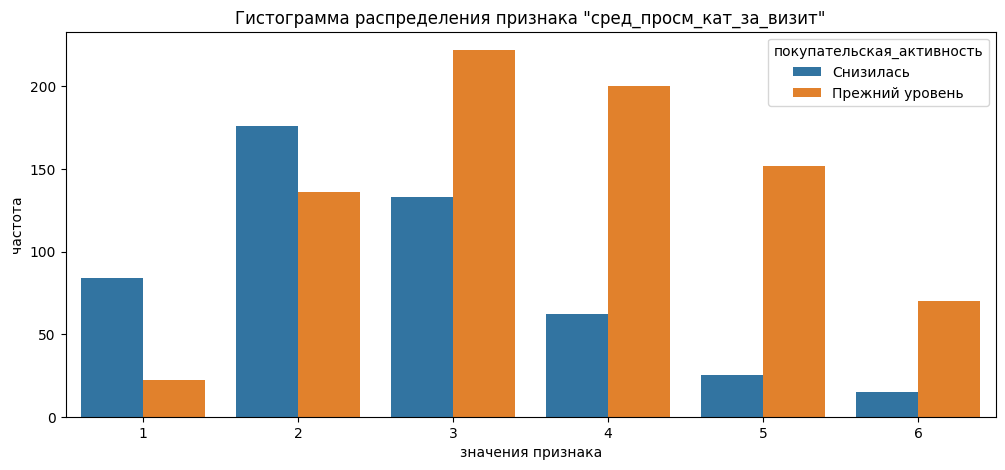

In [70]:
cat_discr_numeric('сред_просм_кат_за_визит')

#### Признак "неоплач_прод_кварт"	

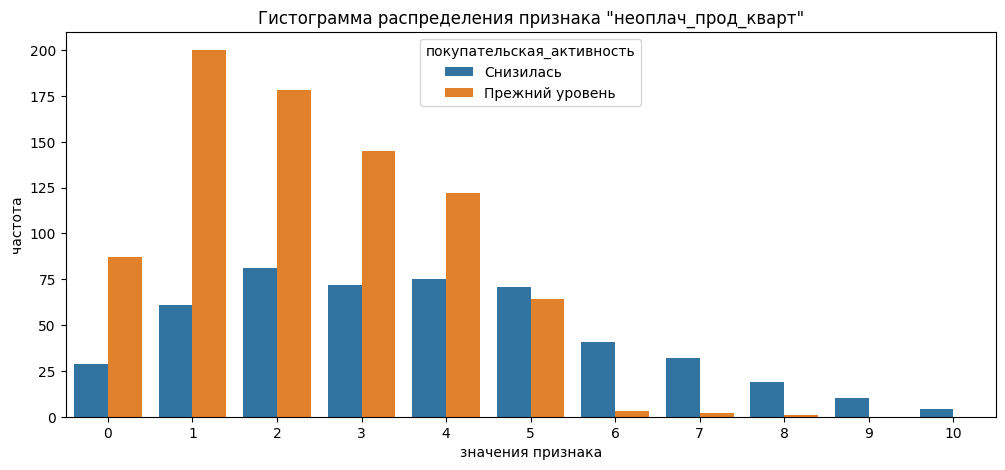

In [71]:
cat_discr_numeric('неоплач_прод_кварт')

#### Признак "ошибка_сервиса"	

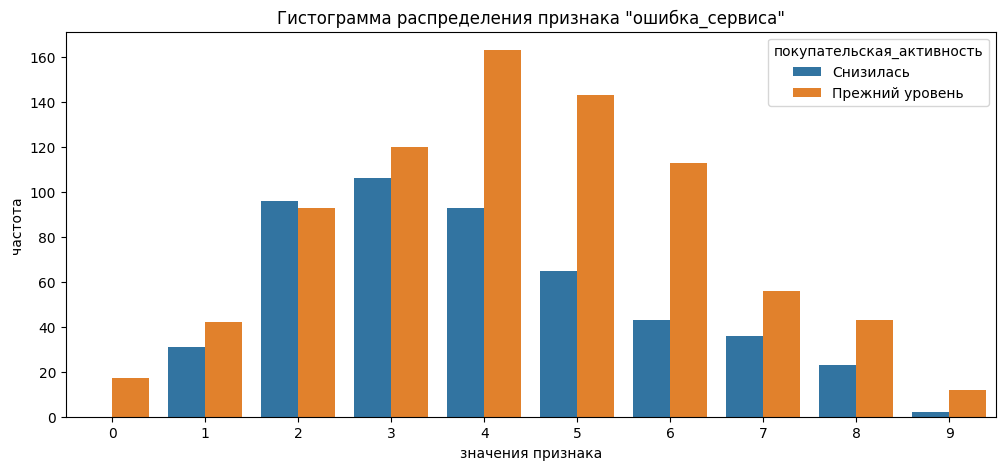

In [72]:
cat_discr_numeric('ошибка_сервиса')

#### Признак "страниц_за_визит"	

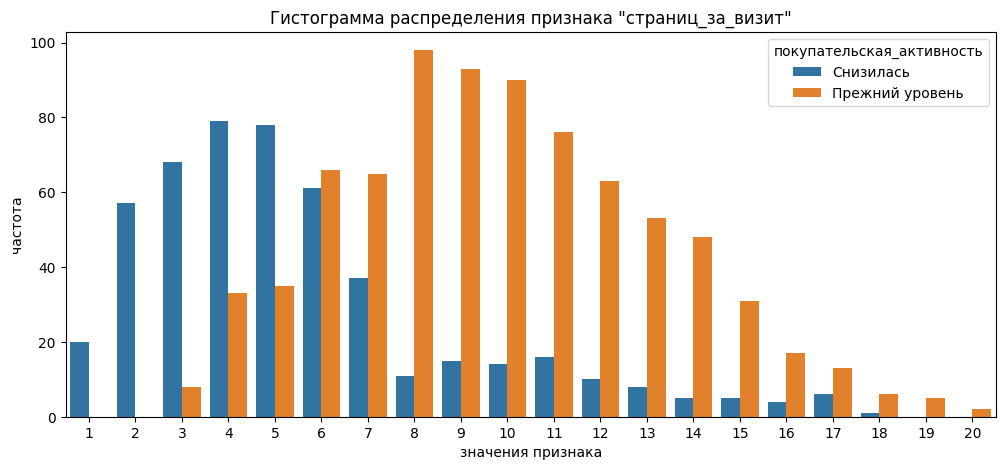

In [73]:
cat_discr_numeric('страниц_за_визит')

#### Признак "выручка_пред_месяц"	

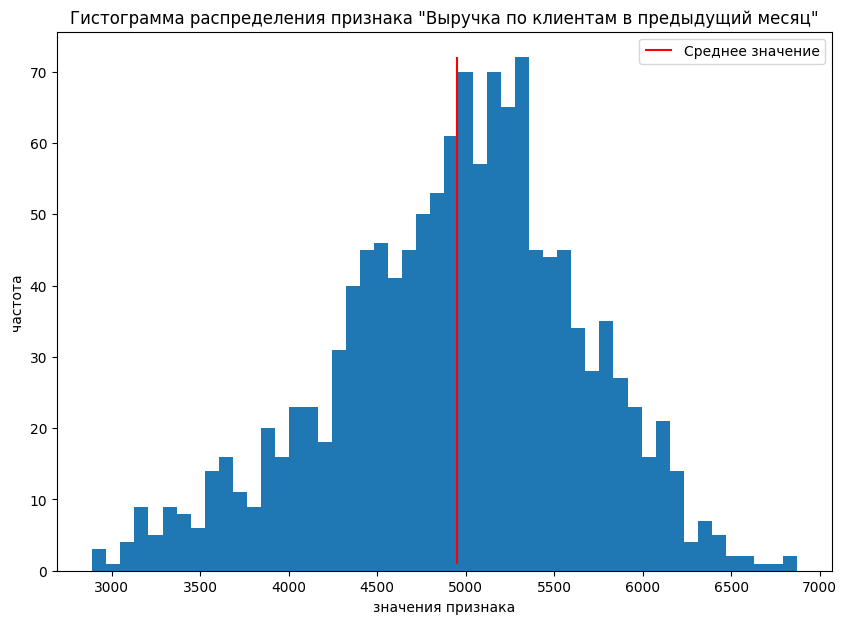

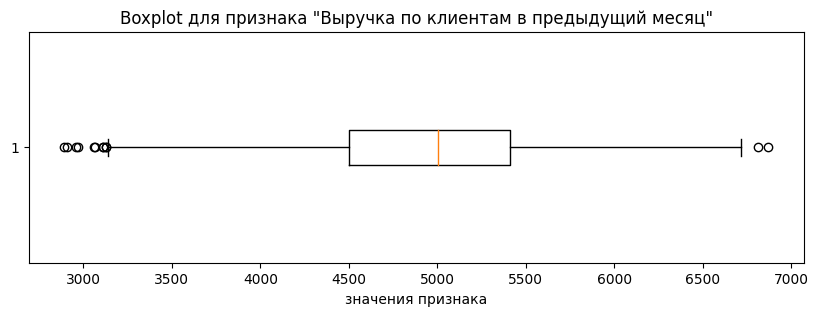

In [74]:
cat_numeric(df['выручка_пред_месяц'], '"Выручка по клиентам в предыдущий месяц"')

#### Признак "выручка_препред_месяц"

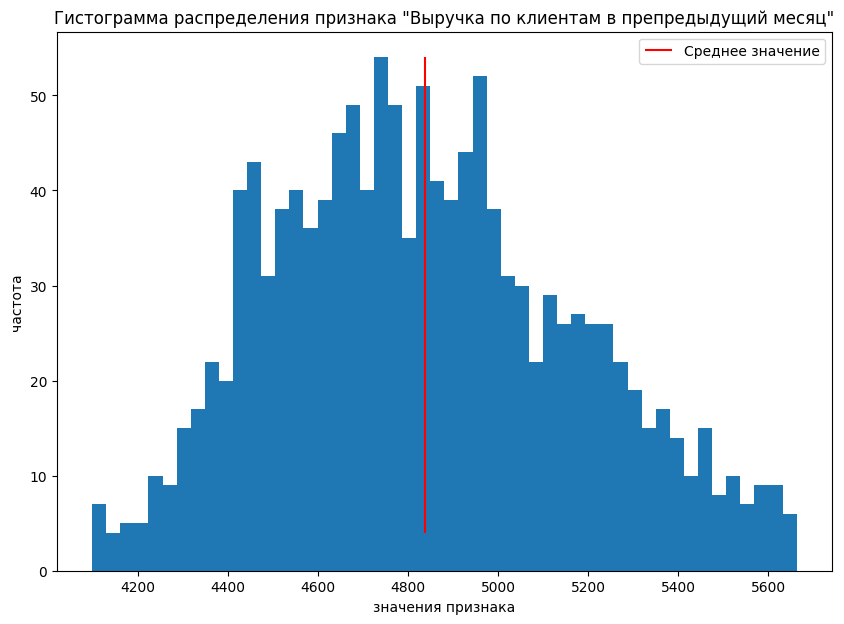

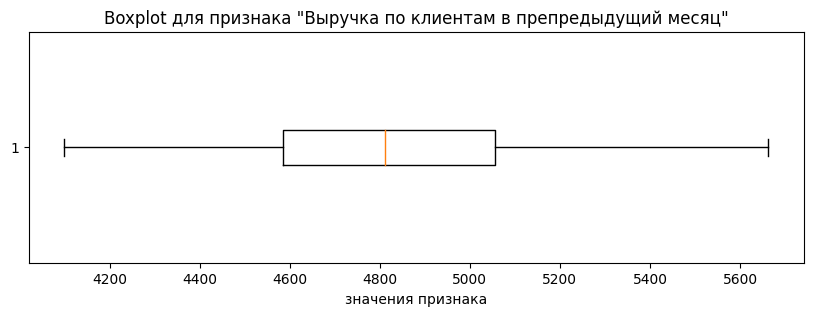

In [75]:
cat_numeric(df['выручка_препред_месяц'], '"Выручка по клиентам в препредыдущий месяц"')

#### Признак "выручка_тек_месяц"	

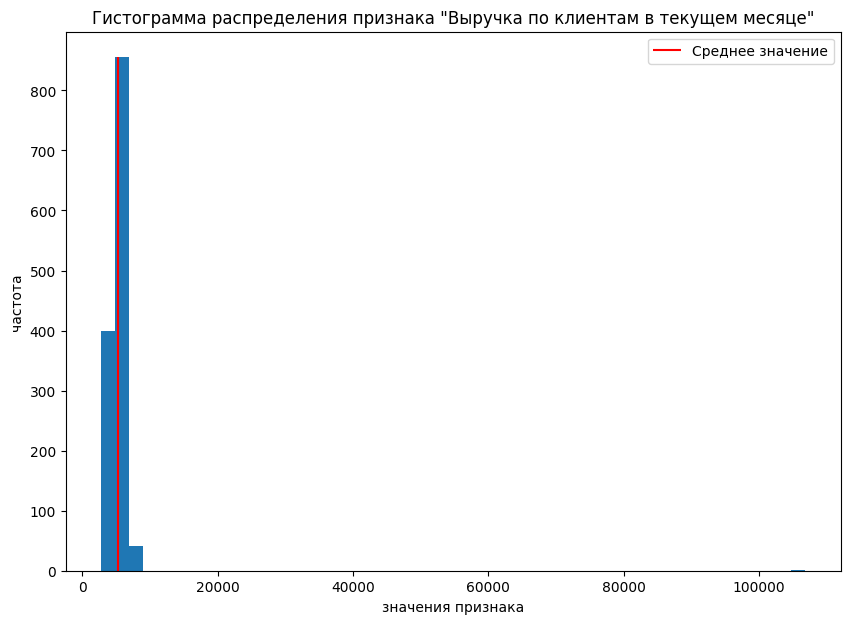

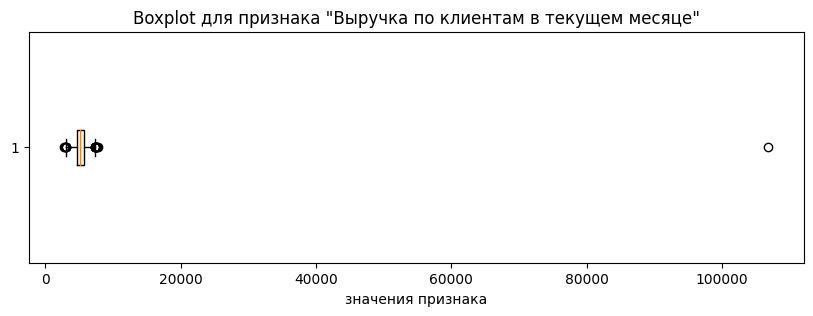

In [76]:
cat_numeric(df['выручка_тек_месяц'], '"Выручка по клиентам в текущем месяце"')

**Результат.** Обнаружено аномально высокое значение признака "выручка_тек_месяц"

In [77]:
# определение значения выброса, превышающего 100000 руб.
df['выручка_тек_месяц'].sort_values(ascending=False).head(2)

29    106,862.20
142     7,799.40
Name: выручка_тек_месяц, dtype: float64

In [78]:
# удаление аномального значения заменой его на медианное
df.loc[df['выручка_тек_месяц'] >= 20000, 'выручка_тек_месяц'] = df.loc[df['выручка_тек_месяц'] < 20000, 'выручка_тек_месяц'].median()
df.loc[29, 'выручка_тек_месяц']  # проверка замены

5179.950000000001

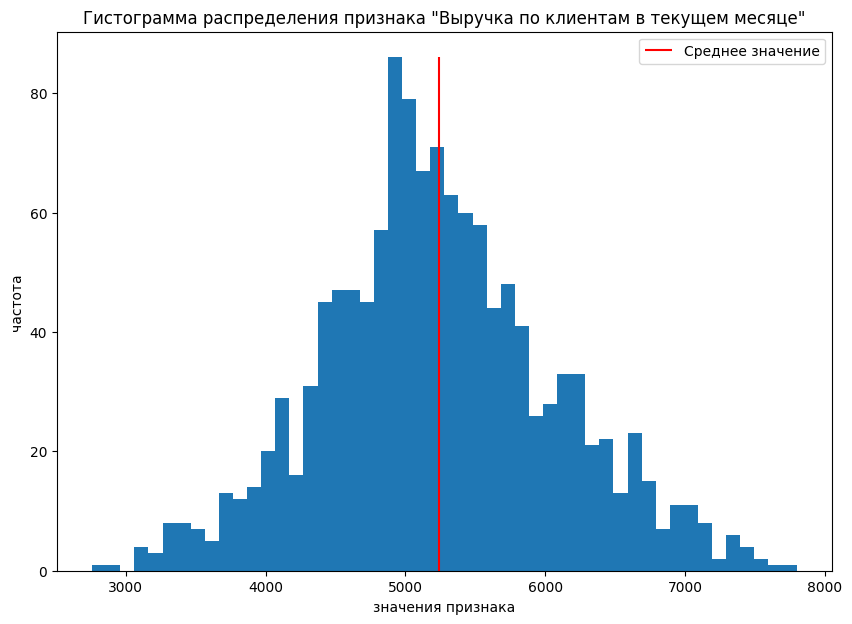

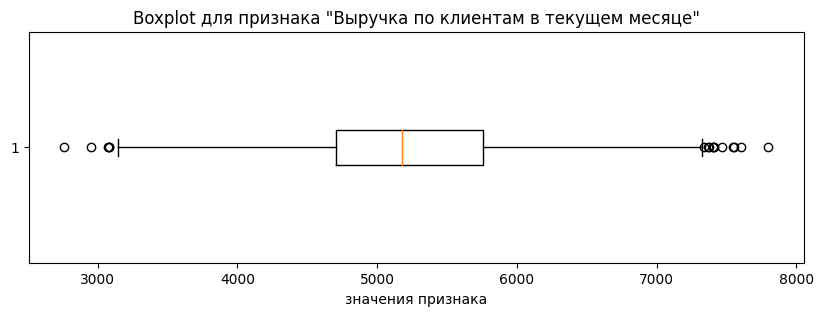

In [79]:
# после удаления аномалии
cat_numeric(df['выручка_тек_месяц'], '"Выручка по клиентам в текущем месяце"')

#### Признак "время_пред_месяц"

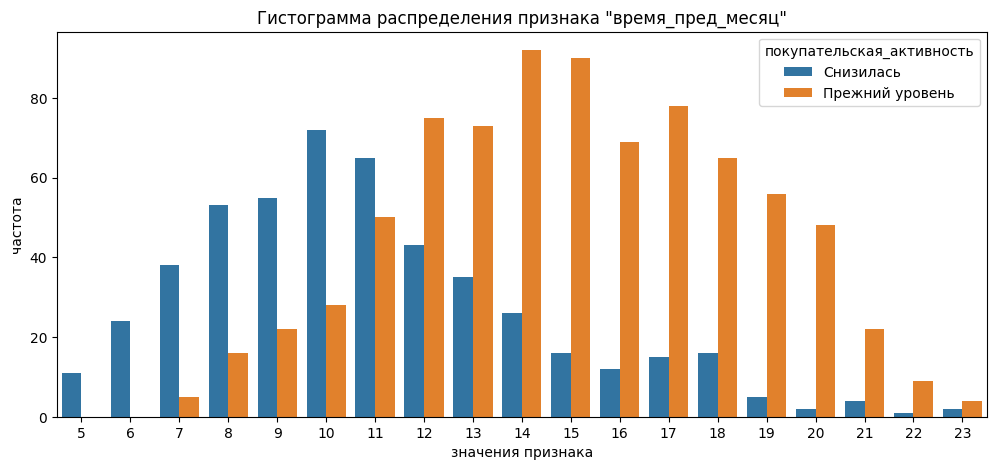

In [80]:
cat_discr_numeric('время_пред_месяц')

#### Признак "время_тек_месяц"	

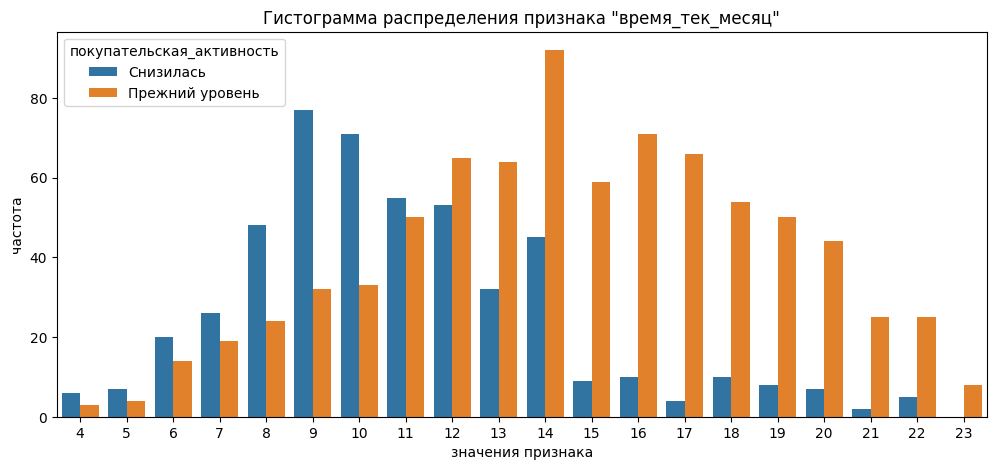

In [81]:
cat_discr_numeric('время_тек_месяц')

#### Признак "прибыль"	

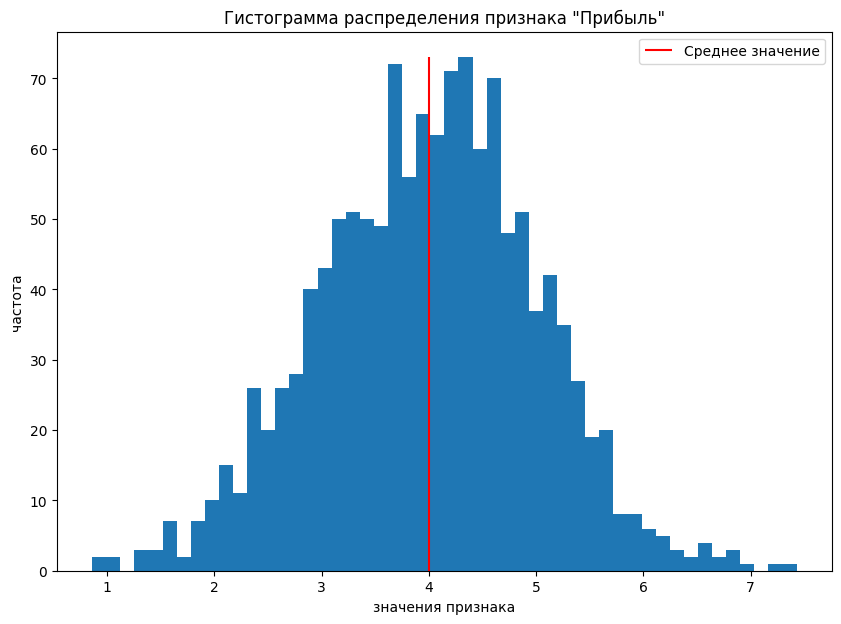

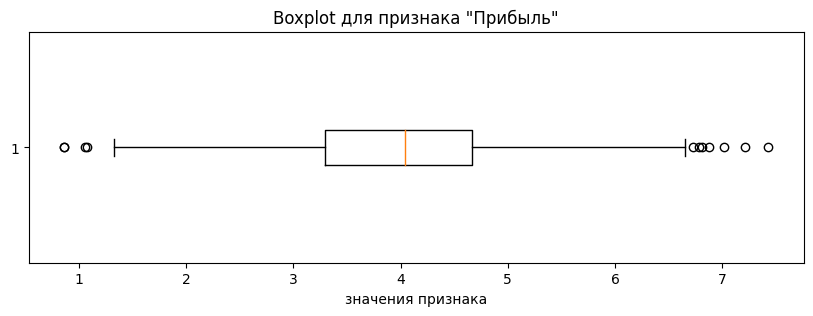

In [82]:
cat_numeric(df['прибыль'], '"Прибыль"')

#### Построение гистограмм и диаграммы размаха для количественных признаков датафрейма df

**Функция для построения обзорных гистограмм и диаграмм размаха для количественных признаков датафрейма df**

In [83]:
def hist_all_num(list_num):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    df[list_num].plot(kind='hist', bins=30, alpha=0.5, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    df[list_num].plot(kind='box', ax=axes[1], rot=60)
    axes[1].set_title('Разброс значений признаков')
    plt.ylabel('значения признаков')
    plt.show()
    return

**Обзорная гистограмма и диаграмма размаха для количественных признаков датафрейма df, за исключением признаков по выручке и длительности**

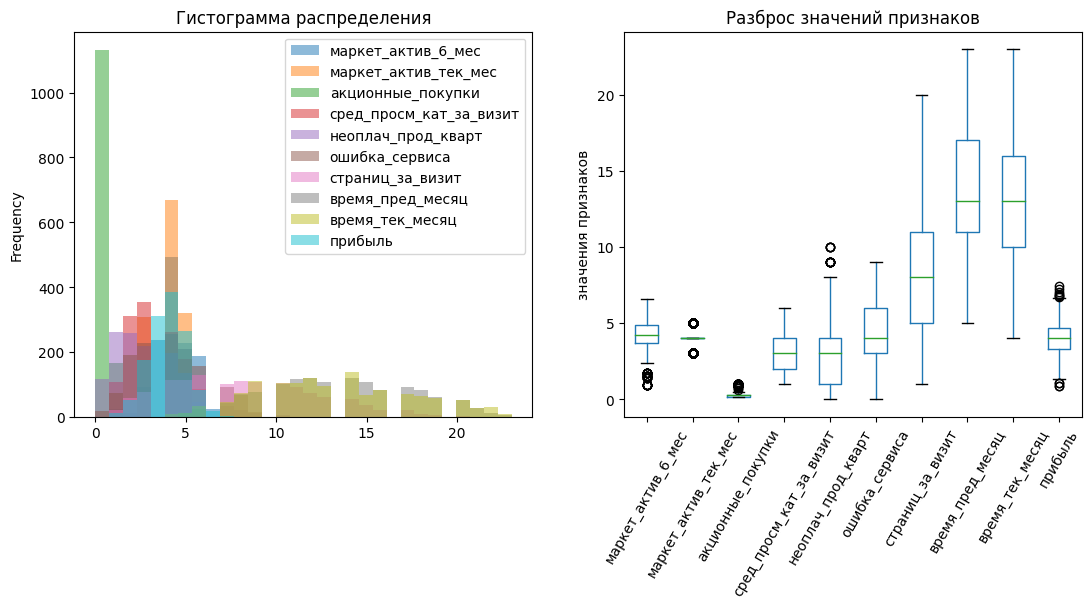

In [84]:
# признаки для гистограммы и диаграммы размаха
num_col_names = df.select_dtypes(include='number').columns.tolist()
num_col_names = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки', 'сред_просм_кат_за_визит', 
                 'неоплач_прод_кварт', 'ошибка_сервиса', 'страниц_за_визит', 'время_пред_месяц', 
                 'время_тек_месяц', 'прибыль']

# вызов функции
hist_all_num(num_col_names)

**Обзорная гистограмма и диаграмма размаха для признаков по длительности и выручке датафрейма df**

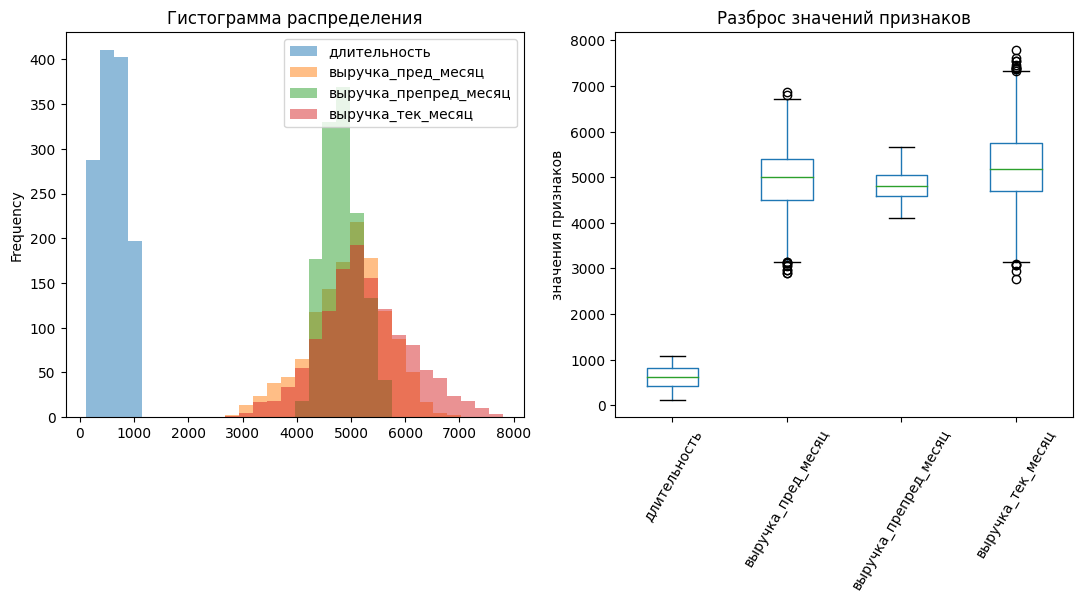

In [85]:
# признаки для гистограммы и диаграммы размаха
num_col_names = ['длительность', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц']

# вызов функции
hist_all_num(num_col_names)

*Результат.* Необходимость проведения масштабирования данных.

### Категориальные признаки

#### Функция графического представления категориальных признаков

In [86]:
# функция  графического представления категориальных признаков

def cat_category(cat_column):
    if cat_column == 'популярная_категория': 
        rot_x = 45 
    else: 
        rot_x = 0
    plt.figure(figsize=(6, 2))
    df[cat_column].value_counts(normalize=True).plot(kind='bar', rot=rot_x)
    plt.title(f'Гистограмма распределения признака "{cat_column}"')
    plt.ylabel('доля категорий')
    plt.xlabel('значения признака')
    plt.ylabel('частота')
    plt.show()
    return

In [87]:
# категориальные столбцы
df.select_dtypes(exclude='number').columns.tolist()

['покупательская_активность',
 'тип_сервиса',
 'разрешить_сообщать',
 'популярная_категория']

#### Целевой признак "покупательская_активность"

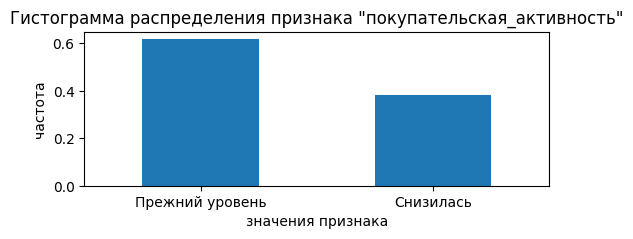

In [88]:
cat_category('покупательская_активность')

In [89]:
# замена значений категорильного столбца:
# 1 - при снижении покупательской активности
# 0 - при сохранении покупательской активности
# df['покупательская_активность'] = df['покупательская_активность'].apply(lambda x: 1 if x=='Снизилась' else 0)

#### Признак "тип_сервиса"

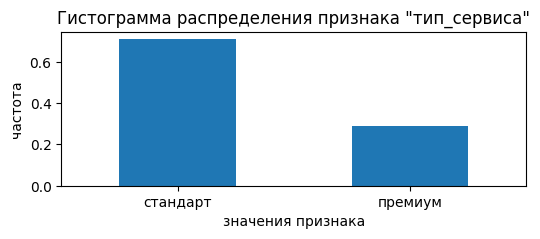

In [90]:
cat_category('тип_сервиса')

#### Признак "разрешить_сообщать"

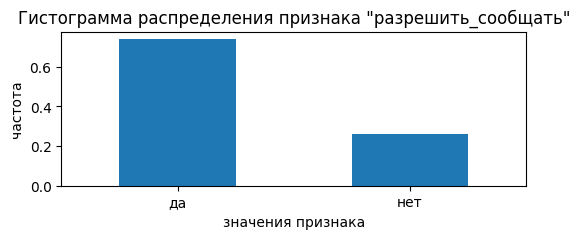

In [91]:
cat_category('разрешить_сообщать')

#### Признак "популярная_категория"

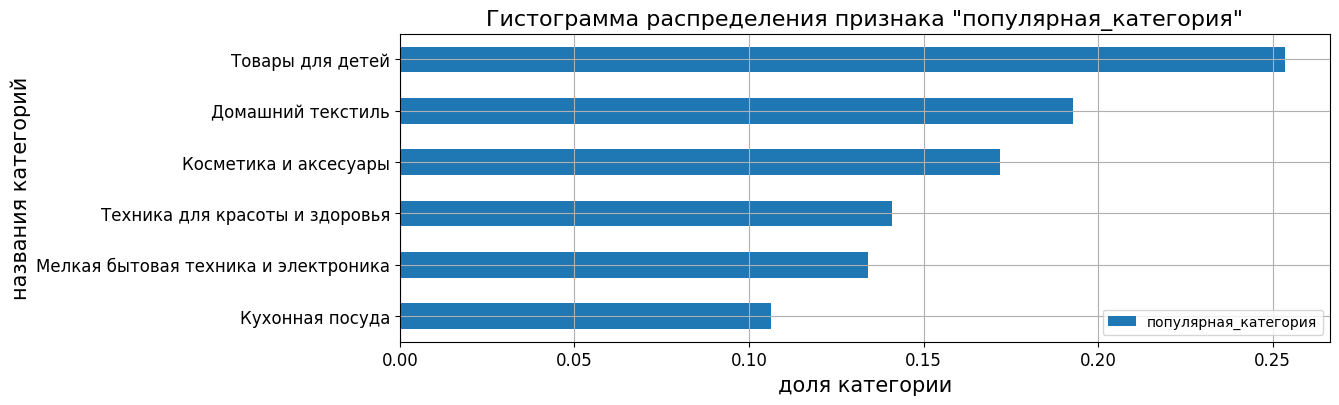

In [92]:
# визуализация частот признака "популярная_категория"
(
    df['популярная_категория']
    .value_counts(normalize=True)
    .sort_values(ascending=True)
    .to_frame()
    .plot(kind = 'barh', grid=True, fontsize = 12, figsize = (12,4))
).set_title('Гистограмма распределения признака "популярная_категория"',  fontsize = 16, color = 'Black')
plt.xlabel('доля категории', fontsize=15)
plt.ylabel('названия категорий', fontsize=15)
plt.show()

### Выводы:

**1.** Перед исследовательским анализом данных было произведено их объединение в один датафрейм **df**.  При этом, в ходе проверки клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период, вывлено не было.

**2.** При ознакомлении с датафреймом **market_file** в признаке **покупательская_активность** было обнаружено последовательное следование сначала строк со значением этого признака 'Снизилась', а затем со значениями 'Прежний уровень'. Причем отмечается дисбаланс классов. При разбиении данных на выборки перед началом моделирования необходимо проведение стратификации данных.

**3.** При ознакомлении с данными признака **"маркет актив 6 мес"** (п.3.2.3), **"неоплач_прод_кварт"** (п.3.2.8) обнаружены данные, выходящие за пределы боксплота, но не являющиеся аномалиями.

**4.** Произведено преобразование дискретного количественного признака **маркет_актив_тек_мес** в порядковый категориальный.

**5.** В данных по признаку **"выручка_тек_месяц"** (п.3.2.13) обнаружен аномальный выброс со значением **106,862.20 руб.**, который был удален путем замены на медианное значение по выборке, а именно на **5179.95 руб.**

**6.** Построенные гистограмма и диаграмма размаха для количественных признаков датафрейма **df** позволяют сделать вывод о необходимости проведения масштабирования данных по признакам перед проведением моделирования.

**7.** Гистограммы распределения категориальных признаков выявляют дисбаланс их классов.

**8.** По целевому признаку **'покупательская_активность'** необходимо проведение стратификации данных ввиду существенного количественного отличия классов **"снизилась"** и **"прежний уровень"** (соотношение 2 к 3). 

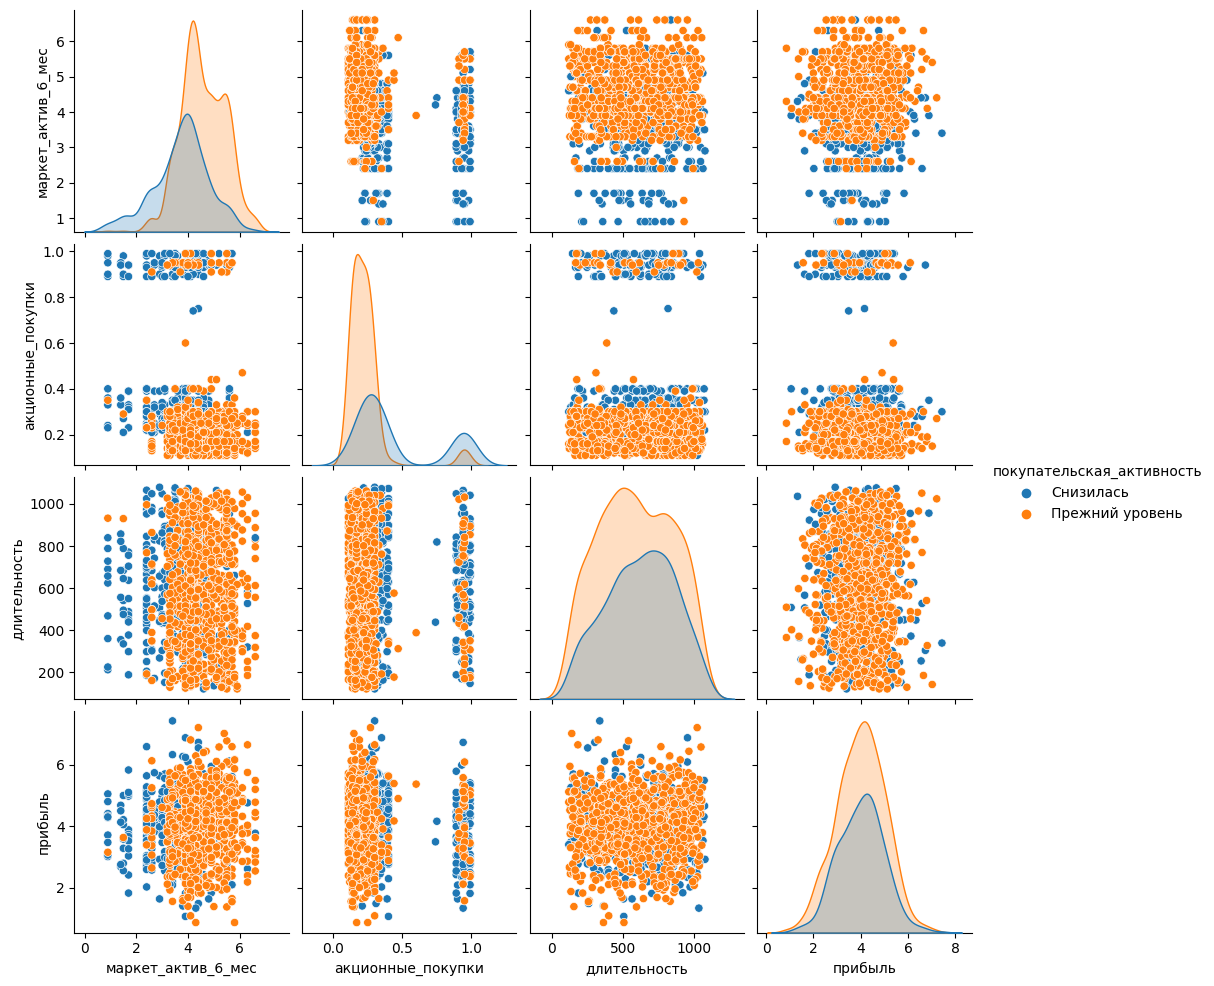

In [93]:
data_df = df[['маркет_актив_6_мес', 'акционные_покупки', 'тип_сервиса', 'длительность', 'прибыль', 'покупательская_активность']]
sns.pairplot(data_df, hue = 'покупательская_активность');

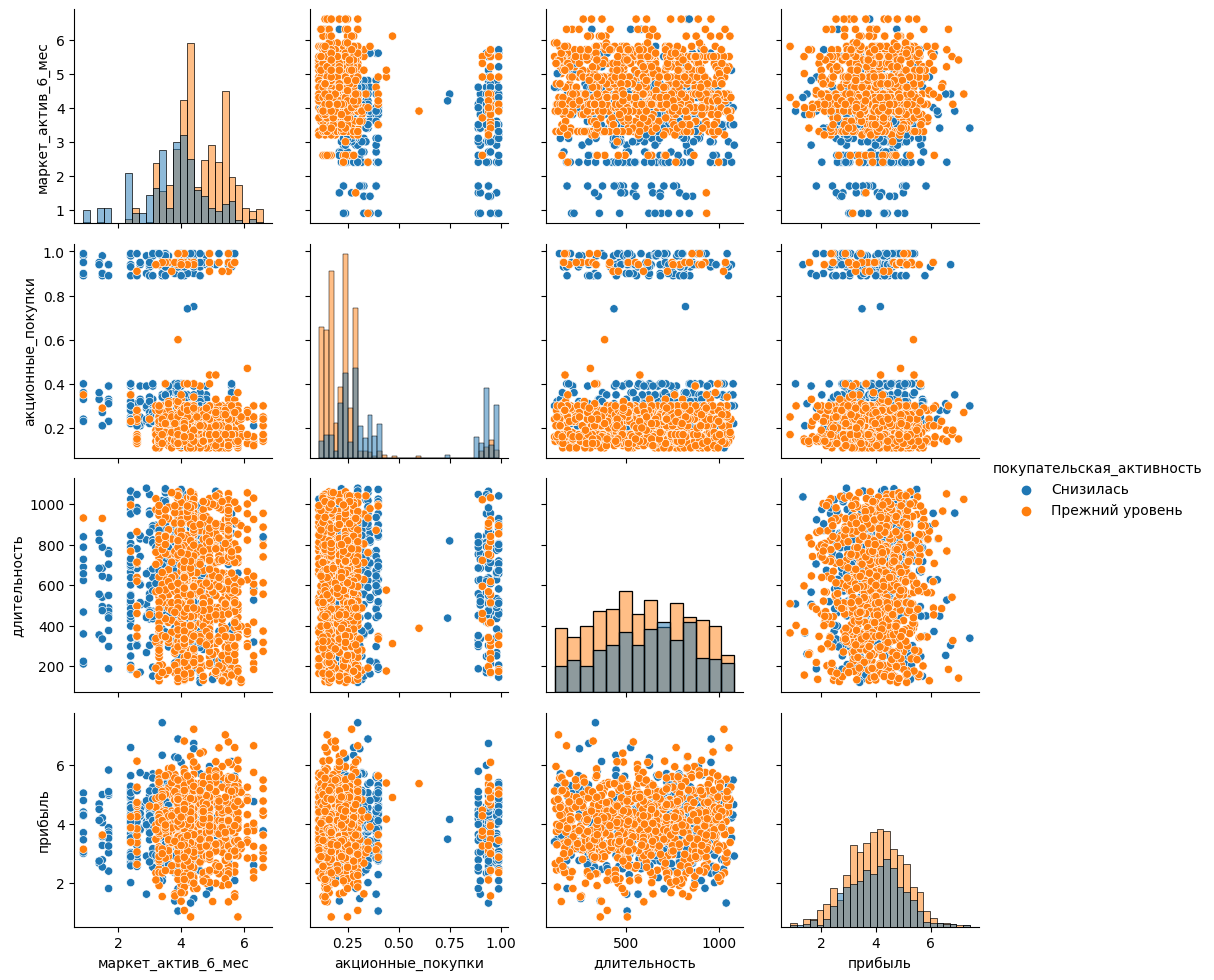

In [94]:
g = sns.PairGrid(data_df, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

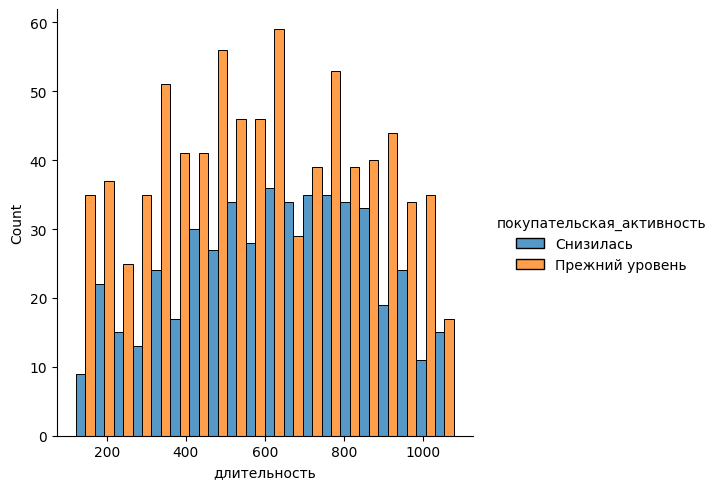

In [95]:
sns.displot(data = df, x = 'длительность', hue='покупательская_активность', bins=20, multiple='dodge');  
# histplot, discrete=True, multiple='dodge'stat='density'

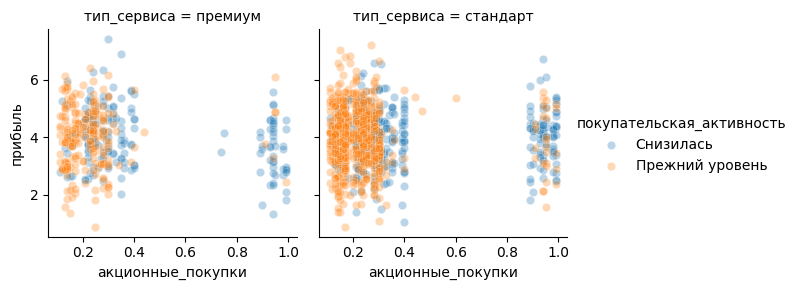

In [96]:
g = sns.FacetGrid(data_df, col='тип_сервиса', hue='покупательская_активность')
g.map(sns.scatterplot, 'акционные_покупки', 'прибыль', alpha=.3)
g.add_legend();

## Корреляцилнный анализ признаков

### Отбор количественных непрерывных признаков для корреляционной матрицы

In [97]:
# dывод наименований всех признаков
df.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория', 'сред_просм_кат_за_визит',
       'неоплач_прод_кварт', 'ошибка_сервиса', 'страниц_за_визит',
       'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц',
       'время_пред_месяц', 'время_тек_месяц', 'прибыль'],
      dtype='object')

In [98]:
# количественные непрерывные признаки
interval_cols=['маркет_актив_6_мес', 'длительность', 'акционные_покупки',
               'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц']

### Матрица коэффициентов корреляции для целевого и входных признаков

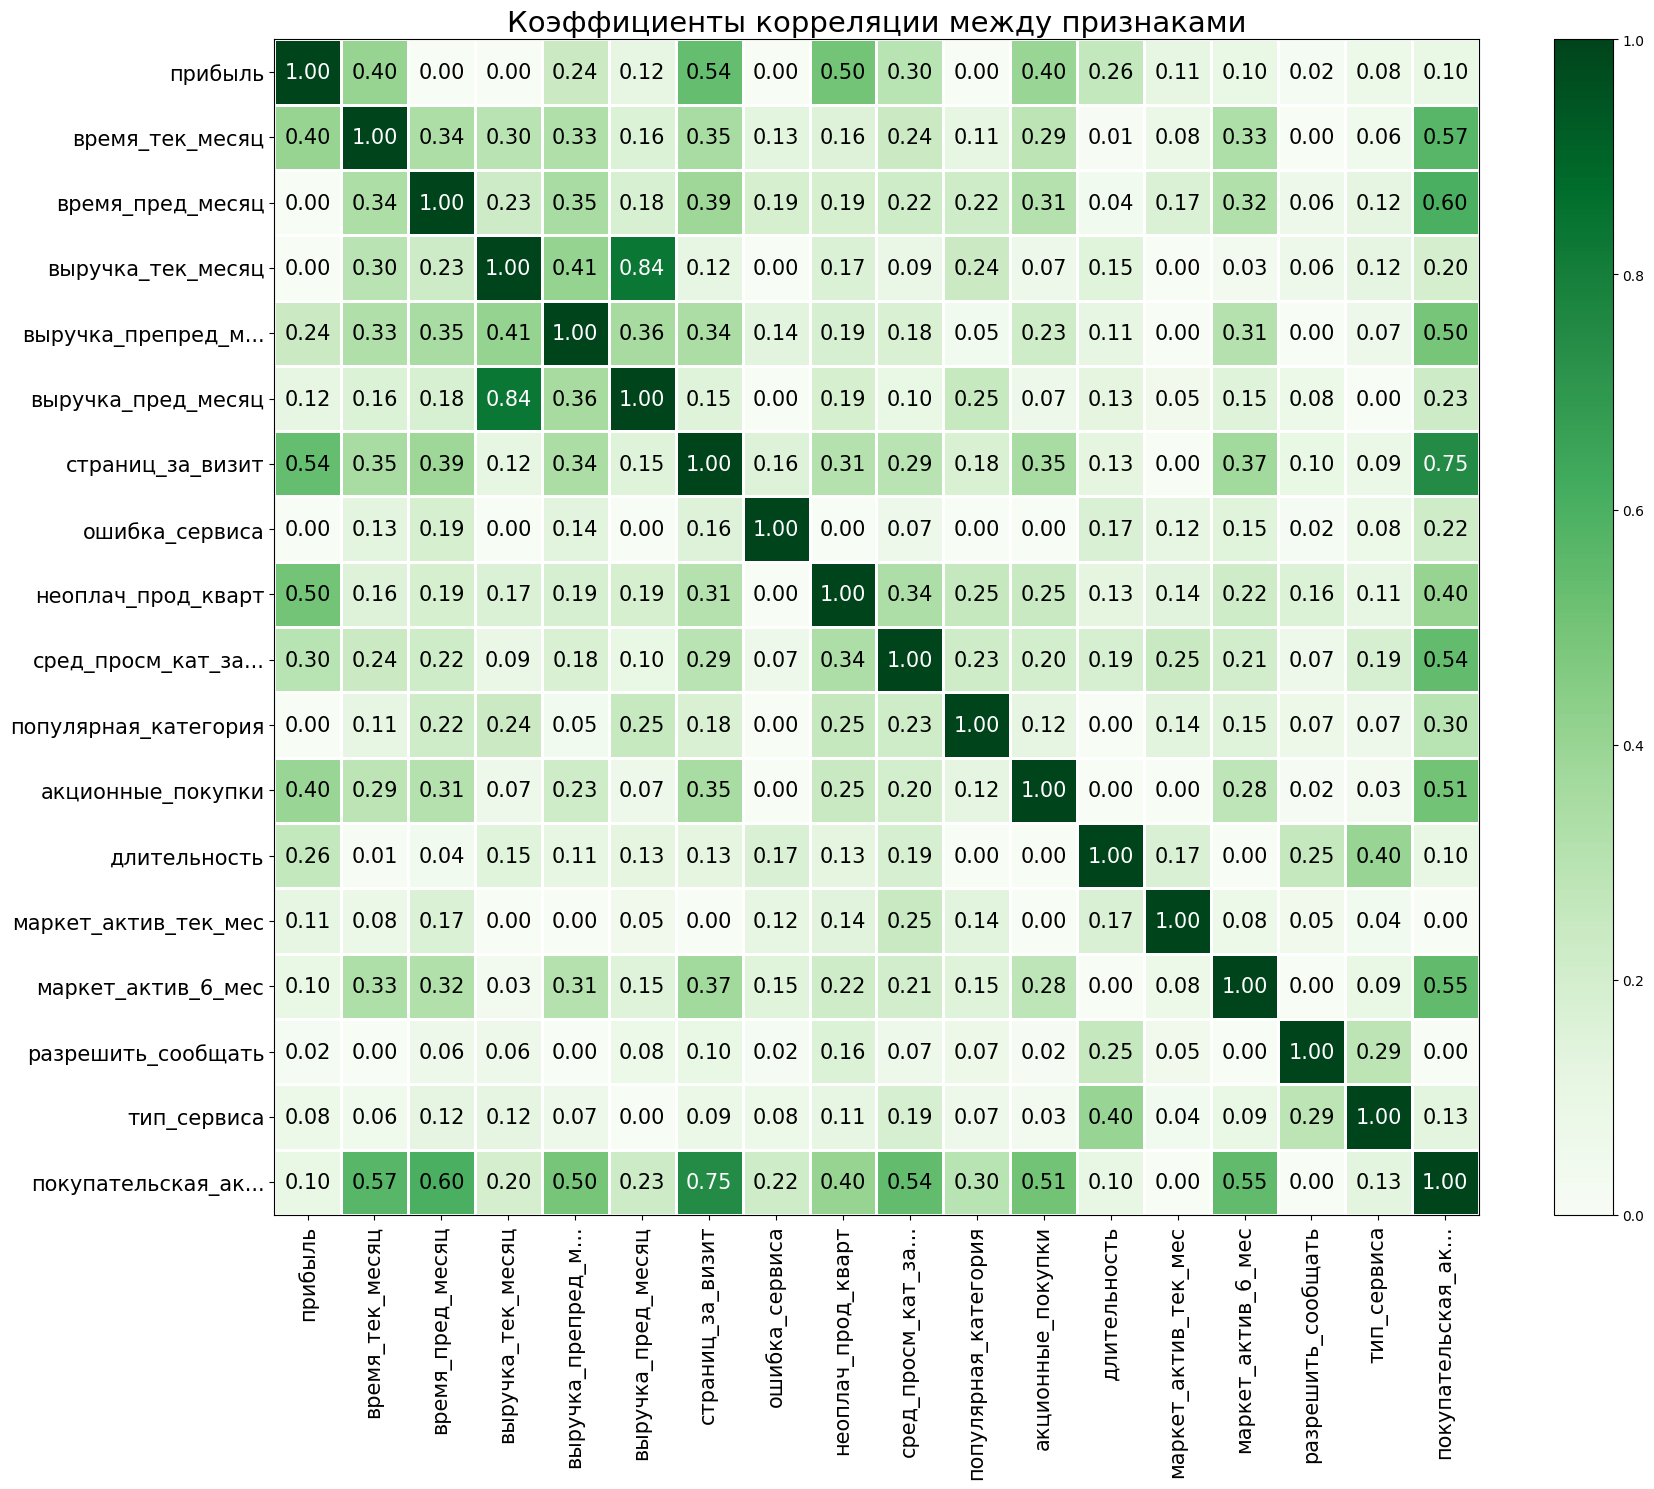

In [99]:
# расчет матрицы корреляции
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# вывод матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Коэффициенты корреляции между признаками',
    fontsize_factor=1.5,
    figsize=(18, 15)
) 

### Выводы:

**1.** Выявлена умеренная корреляция между целевым признаком **'покупательская_активность'** и признаками **'неоплач_прод_кварт'** (0,40), **'популярная_категория'** (0,30).

**2.** Заметная корреляция установлена между целевым признаком и признаками **'время_тек_месяц'** (0,57) и **'время_пред_месяц'** (0,60), **'выручка_препред_месяц'** (0.50), **'сред_просм_кат_за_визит'** (0.54), **'акционные_покупки_бин'** (0.49), **'маркет актив 6 мес'** (0.55).

**3.** Высокая корреляция отмечена между целевым признаком и признаком **'страниц_за_визит'** (0.75).

**4.** **Мультиколлениарность** признаков не выявлена.

**СОВЕТ 1. ДОПОЛНИТЕЛЬНЫЕ МАТРИЦЫ КОРРЕЛЯЦИИ**

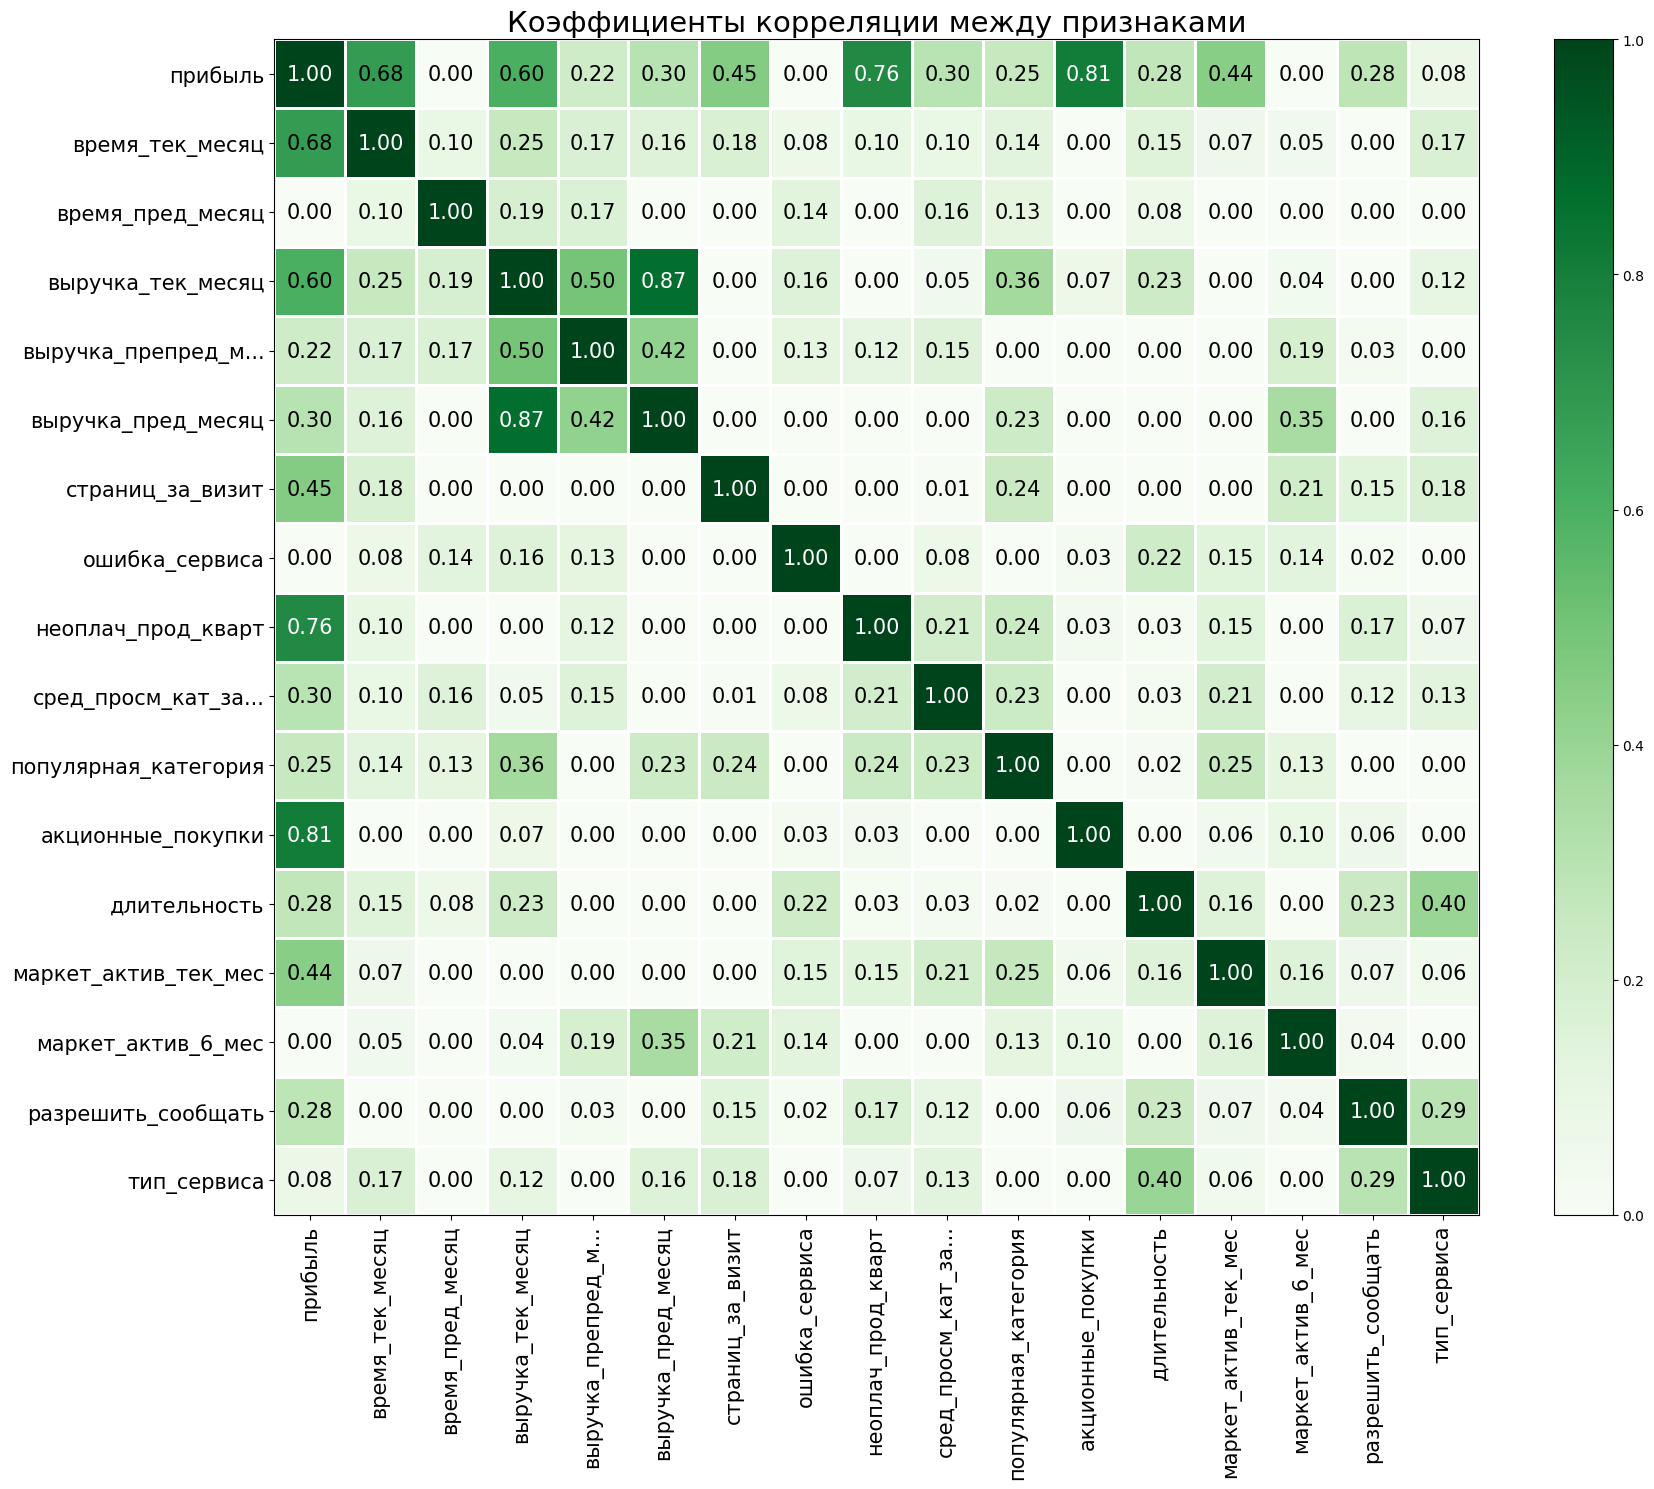

In [100]:
# расчет матрицы корреляции для 'покупательская_активность' == "Прежний уровень"
phik_overview = df.query('покупательская_активность == "Прежний уровень"').phik_matrix(interval_cols=interval_cols)

# вывод матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Коэффициенты корреляции между признаками',
    fontsize_factor=1.5,
    figsize=(18, 15)
) 

**СОВЕТ 2. ПРОВЕРКА НА МУЛЬТИКОЛЛИНЕАРНОСТЬ С ПОМОЩЬЮ VIF**

In [101]:
X_df = df.copy()

In [102]:
# категориальные признаки
ohe_columns = [
    'популярная_категория'   
]

# упорядоченные признаки
ord_columns = [
    'тип_сервиса',
    'разрешить_сообщать',
    'покупательская_активность'
]

# количественные признаки
num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'сред_просм_кат_за_визит',
    'неоплач_прод_кварт',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_препред_месяц',
    'выручка_пред_месяц',
    'выручка_тек_месяц',
    'время_пред_месяц',
    'время_тек_месяц',
    'прибыль'
]

In [103]:
# SimpleImputer + OHE
ohe_pipe_1 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [104]:
# SimpleImputer + ORD + SimpleImputer
ord_pipe_1 = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт' ],
                    ['да', 'нет'],
                    ['Прежний уровень', 'Снизилась']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [105]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe_1, ohe_columns),
        ('ord', ord_pipe_1, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [106]:
X_df = pd.DataFrame(data_preprocessor.fit_transform(df), columns=data_preprocessor.get_feature_names_out())

In [107]:
X_df.columns

Index(['ohe__популярная_категория_Косметика и аксесуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей', 'ord__тип_сервиса',
       'ord__разрешить_сообщать', 'ord__покупательская_активность',
       'num__маркет_актив_6_мес', 'num__маркет_актив_тек_мес',
       'num__длительность', 'num__акционные_покупки',
       'num__сред_просм_кат_за_визит', 'num__неоплач_прод_кварт',
       'num__ошибка_сервиса', 'num__страниц_за_визит',
       'num__выручка_препред_месяц', 'num__выручка_пред_месяц',
       'num__выручка_тек_месяц', 'num__время_пред_месяц',
       'num__время_тек_месяц', 'num__прибыль'],
      dtype='object')

In [108]:
# "укорачивание" названий признаков в преобразованных тренировочной и тестовой выборках
new_names = ['косметика_и_аксесуары', 'кухонная_посуда', 'бытовая_техника_и_эл_ка', 
             'тех_красоты_и_здоровья', 'товары_для_детей', 'тип_сервиса_стандарт', 
             'разрешить_сообщать', 'покупательская_активность', 
             'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
             'акционные_покупки', 'сред_просм_за_визит', 'отказов_за_квартал', 
             'ошибка_сервиса', 'страниц_за_визит', 'выручка_препред_месяц', 
             'выручка_пред_месяц', 'выручка_тек_месяц', 'время_пред_месяц', 
             'время_тек_месяц', 'прибыль']

X_df.columns = new_names

In [109]:
X_df.head(2)

косметика_и_аксесуары  кухонная_посуда  бытовая_техника_и_эл_ка  \
0                   0.00             0.00                     0.00   
1                   0.00             0.00                     0.00   

   тех_красоты_и_здоровья  товары_для_детей  тип_сервиса_стандарт  \
0                    0.00              1.00                  0.00   
1                    0.00              0.00                  1.00   

   разрешить_сообщать  покупательская_активность  маркет_актив_6_мес  \
0                0.00                       1.00                0.61   
1                1.00                       1.00                0.70   

   маркет_актив_тек_мес  ...  сред_просм_за_визит  отказов_за_квартал  \
0                  0.50  ...                 0.60                0.40   
1                  0.00  ...                 0.80                0.20   

   ошибка_сервиса  страниц_за_визит  выручка_препред_месяц  \
0            0.22              0.21                   0.24   
1            0.11              0.21                   0.47   

   выручка_пред_месяц  выручка_тек_месяц  время_пред_месяц  время_тек_месяц  \
0                0.58               0.44              0.39             0.32   
1                0.65               0.46              0.17             0.47   

   прибыль  
0     0.50  
1     0.35  

[2 rows x 22 columns]

In [110]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['ПРИЗНАКИ     '] = X_df.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(len(X_df.columns))]

print(vif_data)

                ПРИЗНАКИ        VIF
0       косметика_и_аксесуары  1.93
1             кухонная_посуда  1.62
2     бытовая_техника_и_эл_ка  1.74
3      тех_красоты_и_здоровья  1.74
4            товары_для_детей  2.29
5        тип_сервиса_стандарт  3.93
6          разрешить_сообщать  1.47
7   покупательская_активность  2.98
8          маркет_актив_6_мес 13.83
9        маркет_актив_тек_мес  3.26
10               длительность  5.39
11          акционные_покупки  2.11
12        сред_просм_за_визит  4.48
13         отказов_за_квартал  3.63
14             ошибка_сервиса  5.99
15           страниц_за_визит  6.44
16      выручка_препред_месяц  9.64
17         выручка_пред_месяц 42.57
18          выручка_тек_месяц 37.62
19           время_пред_месяц  8.79
20            время_тек_месяц  7.74
21                    прибыль  9.53


**СОВЕТ 1. Cвязь между выручка текущая - выручка за прошлый с помощью scatter_plot.**

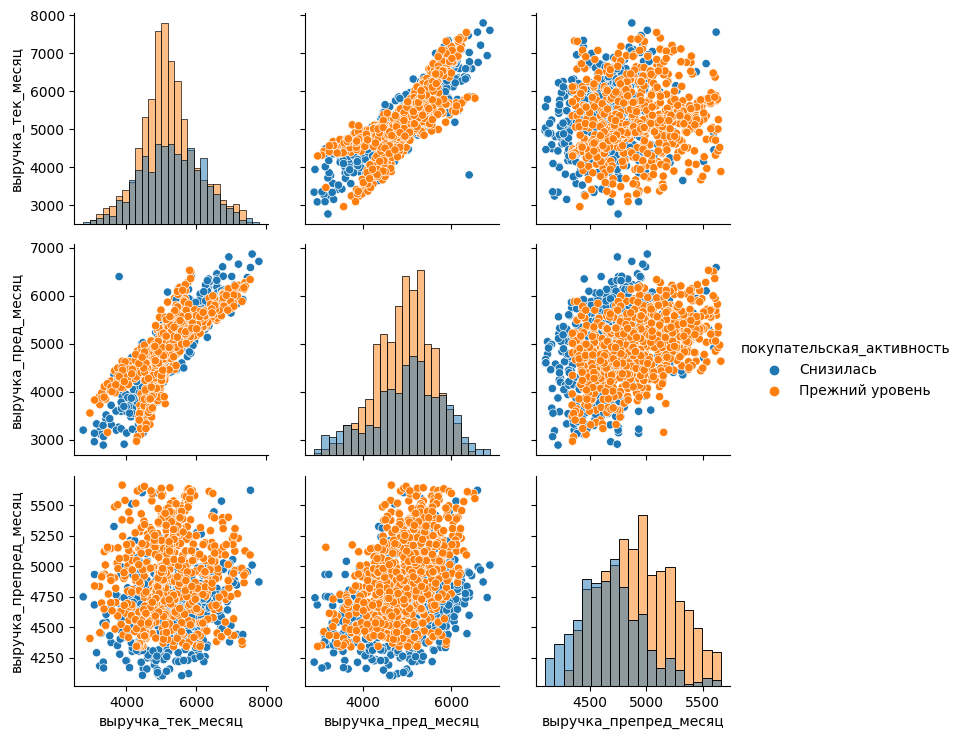

In [111]:
data_df = df[['выручка_тек_месяц', 'выручка_пред_месяц', 'выручка_препред_месяц', 'покупательская_активность']]
g = sns.PairGrid(data_df, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

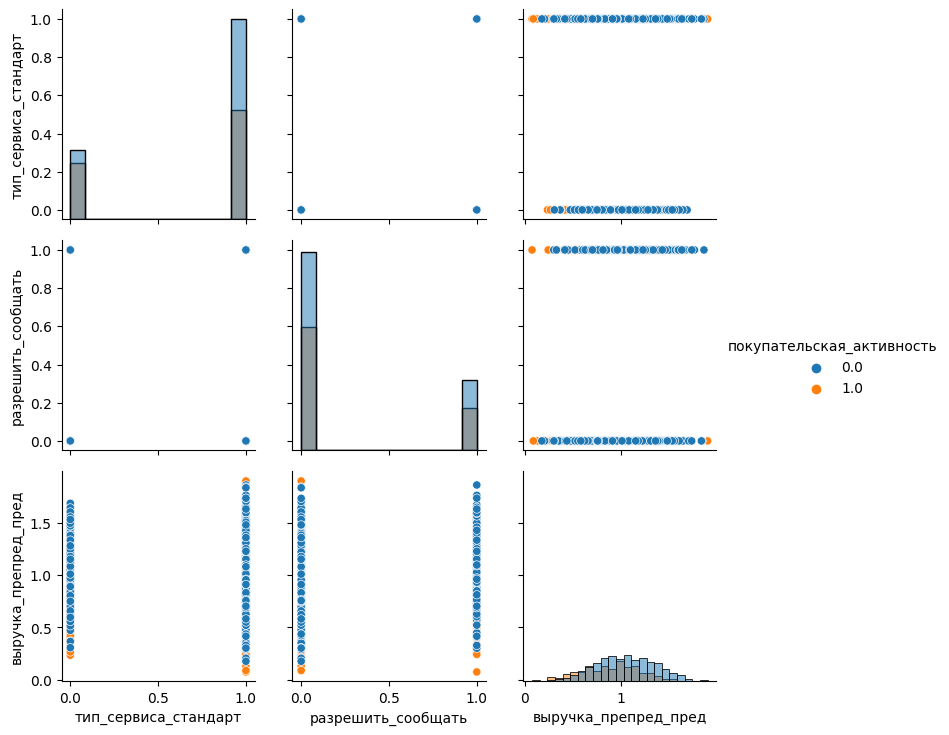

In [112]:
data_cut_1 = X_df[['тип_сервиса_стандарт', 'разрешить_сообщать', 'покупательская_активность']]
data_cut_1['выручка_препред_пред'] = X_df['выручка_препред_месяц'] + X_df['выручка_пред_месяц']
g = sns.PairGrid(data_cut_1, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

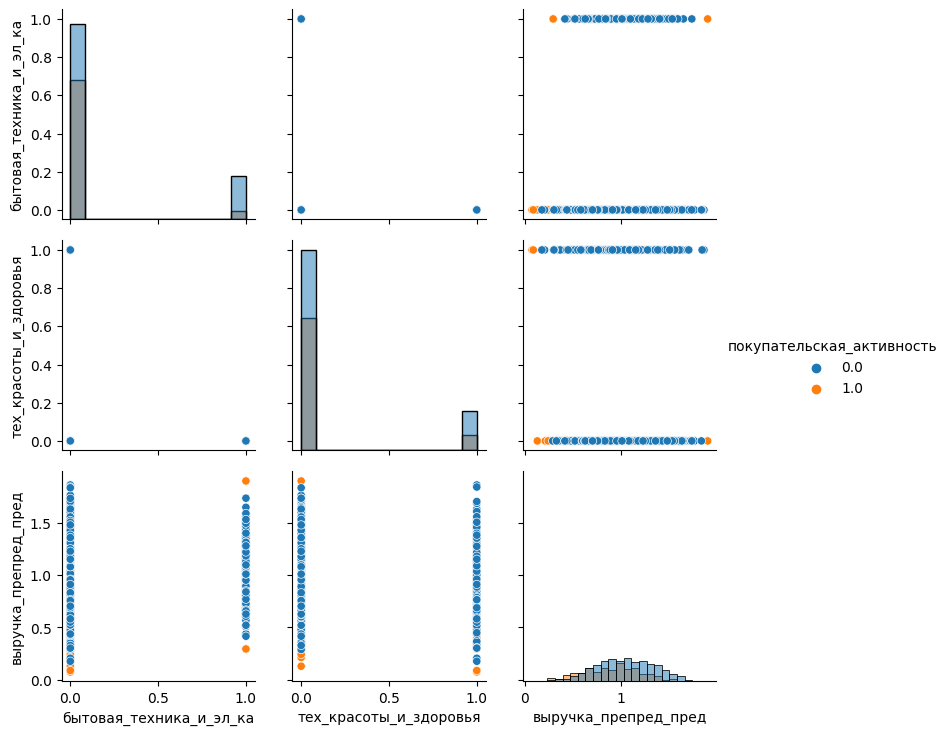

In [113]:
data_cut_2 = X_df[['бытовая_техника_и_эл_ка', 'тех_красоты_и_здоровья', 'покупательская_активность']]
data_cut_2['выручка_препред_пред'] = X_df['выручка_препред_месяц'] + X_df['выручка_пред_месяц']
g = sns.PairGrid(data_cut_2, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

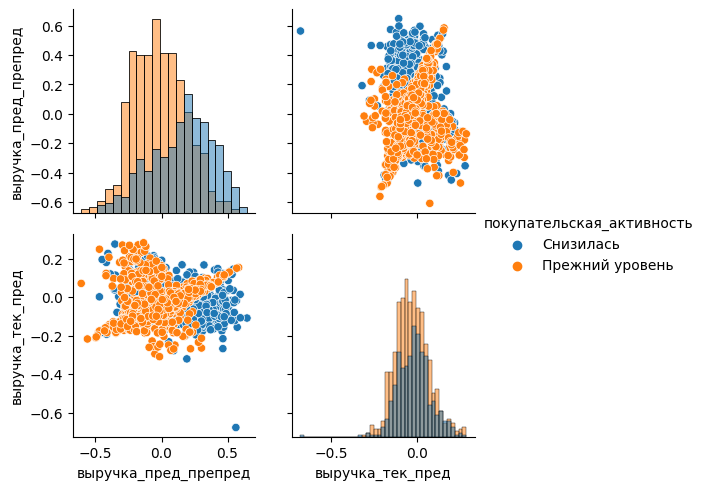

In [114]:
data_df_1 = df[['покупательская_активность']]
data_df_1['выручка_пред_препред'] =  X_df['выручка_пред_месяц'] - X_df['выручка_препред_месяц']
data_df_1['выручка_тек_пред'] =  X_df['выручка_тек_месяц'] - X_df['выручка_пред_месяц']
g = sns.PairGrid(data_df_1, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

## Создание пайплайна, определение лучшей модели

### Подготовка данных

При проведении разбиения данных на выборки была проведена стратификация, о необходимости которой указано в **выводе 2 п.3.4**. Для логистической модели изначально была предусмотрена **L1-регуляризация**.

#### Разбиение исходных данных (датафрейм df) на выборки

In [115]:
# обзор исходного датафрейма
df.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
0                 Снизилась     премиум                 да   
1                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                4.40                     4           819               0.75   
1                4.90                     3           539               0.14   

  популярная_категория  сред_просм_кат_за_визит  неоплач_прод_кварт  \
0     Товары для детей                        4                   4   
1    Домашний текстиль                        5                   2   

   ошибка_сервиса  страниц_за_визит  выручка_пред_месяц  \
0               2                 5            5,216.00   
1               1                 5            5,457.50   

   выручка_препред_месяц  выручка_тек_месяц  время_пред_месяц  \
0               4,472.00           4,971.60                12   
1               4,826.00           5,058.40                 8   

   время_тек_месяц  прибыль  
0               10     4.16  
1               13     3.13

In [116]:
X = df.drop(columns='покупательская_активность') # выборка исходных признаков
y = df['покупательская_активность']              # выборка целевого признака

# деление данных на тренировочные и тестовые, стратификация данных
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

In [117]:
X_test[['прибыль']].head()

прибыль
1095     4.47
118      3.76
950      4.34
362      4.42
149      4.99

#### Кодирование целевого признака с помощью LabelEncoder

In [118]:
# объявление трансформера категорильного признака (y_train)
label_encoder = LabelEncoder()

# преобразование значений категориального признака в 0 и 1
y_train = label_encoder.fit_transform(y_train.values)
y_test = label_encoder.transform(y_test.values)

# проверка кодирования
y_test

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,

In [119]:
# проверка, что 0 - 'Прежний уровень', 1 - 'Снизилась'
pred_classes = [0, 1, 0, 1, 1]
print(label_encoder.inverse_transform(pred_classes)) 

['Прежний уровень' 'Снизилась' 'Прежний уровень' 'Снизилась' 'Снизилась']


In [120]:
# сохранение в отдельных датафреймах значений признака 'прибыль' для использования в дальнейшем
money_train = X_train[['прибыль']].reset_index(drop=True)
money_test = X_test[['прибыль']].reset_index(drop=True)

# удаление признака 'прибыль' перед моделированием
X_train = X_train.drop(columns='прибыль')
X_test = X_test.drop(columns='прибыль')

money_test.head(3) # контроль преобразования

прибыль
0     4.47
1     3.76
2     4.34

####  Группировка по типам исходных данных

In [121]:
# категориальные признаки
ohe_columns = [
    'популярная_категория'   
]

# упорядоченные признаки
ord_columns = [
    'тип_сервиса',
    'разрешить_сообщать'
]

# количественные признаки
num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'сред_просм_кат_за_визит',
    'неоплач_прод_кварт',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_препред_месяц',
    'выручка_пред_месяц',
    'выручка_тек_месяц',
    'время_пред_месяц',
    'время_тек_месяц'
]

### Построение и применение пайплайна

#### OHE-кодирование

In [122]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

#### ORD-кодирование

In [123]:
# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт' ],
                    ['да', 'нет']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

#### Масштабирование количественных признаков и объединение подготовительных процедур

In [124]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#### Итоговый пайплайн для обучения модели

In [125]:
# preprocessor__num = preprocessor_ + _num:
# preprocessor__num — пайплайн, в котором находится шаг масштабирования
# num — шаг масштабирования с методом и списком столбцов
#'passthrough' — вариант без масштабирования

# итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
#    {
        # название модели
#        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
#        'models__n_neighbors': range(10, 20),
        # указываем список методов масштабирования
#        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
#    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__max_features': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='linear', random_state=RANDOM_STATE, class_weight='balanced', probability=True)],
        'models__C': [0.1, 0.2, 0.3],
        'models__gamma': [0.3, 0.4, 0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='saga',                   
            penalty= 'l1'
        )],
        'models__C': range(1,6), # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6] range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [126]:
# cловарь с двумя метриками:
# - roc-auc с именем roc_auc_score;
# - recall с именем recall_score;
# - f1 с именем f1__score.
scoring = {
    'roc_auc_score': 'roc_auc',
    'recall_score': 'recall',
    'f1__score': 'f1'
} 

# перебор вариантов масштабирования и гиперпараметров для моделей из pipe_final
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions,
    cv = 5, 
    scoring = scoring,
    refit ='roc_auc_score',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

#### Применение пайплайна к тренировочным данным

In [127]:
# обучение модели на тренировочной выборке
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpu...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='saga')],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'f1__score': 'f1', 'recall_score': 'recall',
                            'roc_auc_score': 'roc_auc'})

#### Наилучшая модель и ее метрика по итогам использования пайплайна

In [128]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [129]:
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Параметры лучшей модели: {'preprocessor__num': MinMaxScaler(), 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='saga')}


In [130]:
print(f'Метрика ROC-AUC лучшей модели: {randomized_search.best_score_:.3f}')

Метрика ROC-AUC лучшей модели: 0.899


In [131]:
# cтрока в таблице для лучшей модели
print('Номер строки с параметрами лучшей модели: ', randomized_search.best_index_)

Номер строки с параметрами лучшей модели:  5


In [132]:
# транспонированная (для удобства) таблица с результатами работы пайплайна
print(pd.DataFrame(randomized_search.cv_results_).T)

                                                                            0  \
mean_fit_time                                                            0.05   
std_fit_time                                                             0.00   
mean_score_time                                                          0.04   
std_score_time                                                           0.01   
param_preprocessor__num                                        MinMaxScaler()   
param_models__C                                                          2.00   
param_models                LogisticRegression(class_weight='balanced', pe...   
param_models__max_features                                                NaN   
param_models__max_depth                                                   NaN   
param_models__gamma                                                       NaN   
params                      {'preprocessor__num': MinMaxScaler(), 'models_...   
split0_test_roc_auc_score   

#### Извлечение преобразованных пайплайном выборок

In [133]:
# обучение и преобразование препроцессором данных X_train
data_preprocessor.fit_transform(X_train)

array([[ 0.        ,  0.        ,  1.        , ...,  0.92502323,
         1.62692899, -1.72011111],
       [ 0.        ,  0.        ,  0.        , ..., -1.73664956,
        -0.64190168, -0.04864067],
       [ 0.        ,  0.        ,  1.        , ..., -1.72623978,
        -0.13771709, -0.76498515],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.02009038,
        -0.64190168,  1.62282976],
       [ 0.        ,  0.        ,  1.        , ..., -0.42561567,
         1.1227444 ,  1.62282976],
       [ 0.        ,  0.        ,  1.        , ..., -0.63405056,
         0.36646751,  0.19014082]])

In [134]:
# получение преобразованной пайплайном тренировочной выборки
train_new = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
train_new.head(2)

ohe__популярная_категория_Косметика и аксесуары  \
0                                             0.00   
1                                             0.00   

   ohe__популярная_категория_Кухонная посуда  \
0                                       0.00   
1                                       0.00   

   ohe__популярная_категория_Мелкая бытовая техника и электроника  \
0                                               1.00                
1                                               0.00                

   ohe__популярная_категория_Техника для красоты и здоровья  \
0                                               0.00          
1                                               1.00          

   ohe__популярная_категория_Товары для детей  ord__тип_сервиса  \
0                                        0.00              1.00   
1                                        0.00              1.00   

   ord__разрешить_сообщать  num__маркет_актив_6_мес  \
0                     0.00                     0.81   
1                     0.00                     0.74   

   num__маркет_актив_тек_мес  num__длительность  num__акционные_покупки  \
0                       0.50               0.41                    0.05   
1                       0.50               0.08                    0.14   

   num__сред_просм_кат_за_визит  num__неоплач_прод_кварт  num__ошибка_сервиса  \
0                          0.20                     0.40                 0.78   
1                          0.60                     0.50                 0.22   

   num__страниц_за_визит  num__выручка_препред_месяц  num__выручка_пред_месяц  \
0                   0.79                        0.16                     0.57   
1                   0.11                        0.32                     0.88   

   num__выручка_тек_месяц  num__время_пред_месяц  num__время_тек_месяц  
0                    0.65                   0.83                  0.11  
1                    0.20                   0.33                  0.47

In [135]:
# получение преобразованной пайплайном тестовой выборки
test_new = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].fit_transform(X_test), columns=data_preprocessor.get_feature_names_out())
test_new.head(2)

ohe__популярная_категория_Косметика и аксесуары  \
0                                             0.00   
1                                             0.00   

   ohe__популярная_категория_Кухонная посуда  \
0                                       0.00   
1                                       0.00   

   ohe__популярная_категория_Мелкая бытовая техника и электроника  \
0                                               0.00                
1                                               0.00                

   ohe__популярная_категория_Техника для красоты и здоровья  \
0                                               1.00          
1                                               0.00          

   ohe__популярная_категория_Товары для детей  ord__тип_сервиса  \
0                                        0.00              1.00   
1                                        0.00              0.00   

   ord__разрешить_сообщать  num__маркет_актив_6_мес  \
0                     0.00                     0.77   
1                     0.00                     0.56   

   num__маркет_актив_тек_мес  num__длительность  num__акционные_покупки  \
0                       1.00               0.32                    0.91   
1                       0.00               0.72                    0.12   

   num__сред_просм_кат_за_визит  num__неоплач_прод_кварт  num__ошибка_сервиса  \
0                          0.00                     0.10                 0.00   
1                          0.40                     0.30                 0.44   

   num__страниц_за_визит  num__выручка_препред_месяц  num__выручка_пред_месяц  \
0                   0.32                        0.70                     0.53   
1                   0.21                        0.52                     0.72   

   num__выручка_тек_месяц  num__время_пред_месяц  num__время_тек_месяц  
0                    0.52                   0.59                  0.84  
1                    0.52                   0.41                  0.21

In [136]:
# "укорачивание" названий признаков в преобразованных тренировочной и тестовой выборках
new_names = ['косметика_и_аксесуары', 'кухонная_посуда', 'бытовая_техника_и_эл_ка', 
             'тех_красоты_и_здоровья', 'товары_для_детей', 'тип_сервиса_стандарт', 
             'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 
             'длительность', 'акционные_покупки', 'сред_просм_за_визит', 
             'отказов_за_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
             'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц', 
             'время_пред_месяц', 'время_тек_месяц']

train_new.columns = new_names
test_new.columns =  new_names

In [137]:
train_new.columns # проверка переименований

Index(['косметика_и_аксесуары', 'кухонная_посуда', 'бытовая_техника_и_эл_ка',
       'тех_красоты_и_здоровья', 'товары_для_детей', 'тип_сервиса_стандарт',
       'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
       'длительность', 'акционные_покупки', 'сред_просм_за_визит',
       'отказов_за_квартал', 'ошибка_сервиса', 'страниц_за_визит',
       'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц',
       'время_пред_месяц', 'время_тек_месяц'],
      dtype='object')

#### Расчет метрик качества лучшей модели на тестовых данных

In [138]:
# применение обученной модели на тестовой выборке
y_test_pred_new = randomized_search.best_estimator_['models'].predict(test_new)
y_test_proba_new = randomized_search.best_estimator_['models'].predict_proba(test_new)[:,1]
print('МЕТРИКИ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ:')
print(f'Метрика ROC-AUC: {roc_auc_score(y_test, y_test_proba_new):.3f}')
print(f'Метрика accuracy:  {accuracy_score(y_test, y_test_pred_new):.3f}')
print(f'Метрика precision:  {precision_score(y_test, y_test_pred_new):.3f}')
print(f'Метрика recall:  {recall_score(y_test, y_test_pred_new):.3f}')
print(f'Метрика f1:  {f1_score(y_test, y_test_pred_new):.3f}')

МЕТРИКИ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ:
Метрика ROC-AUC: 0.924
Метрика accuracy:  0.865
Метрика precision:  0.812
Метрика recall:  0.839
Метрика f1:  0.825


### Выводы:

**1.** Производилось обучение четырех моделей: **DecisionTreeClassifier(), LogisticRegression() и  SVC()**. Для каждой из них подбирался как минимум один гиперпараметр. Было произведено большое количество вариаций гиперпараметров, в результате чего была подобрана модель на основе логистической регресии, обладающая наилучшими показателями метрик качества. 

**2.** Лучшая модель на тестовых выборках обладает лучшей метрикой качества по сравнению с полученными на основе тренировочных выборок с валидацией.

**3.** Для автоматизированного поиска оптимальных гиперпараметров использовался модуль **RandomizedSearchCV**, так как позволяет обеспечить оперативный поиск решений при большом количестве вариаций значений гиперпараметров.

**4.** При подборе гиперпараметров использовалась метрика **ROC-AUC**, как характеризующая качество модели в целом, которая показывает зависимость TPR и FPR. Оценивает работу модели вне зависимости от выбранного порога вероятности, поэтому она всегда даёт адекватную оценку качества модели. Работает и при несбалансированных классах.

**5.** Параметры лучшей модели: **{'preprocessor__num': MinMaxScaler(), 'models__C': 2, 'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=42, solver='saga')}**.

**6.** Выбор пайплайном в качестве лучшей логистической модели представляется вполне объяснимой ввиду структуры исходных данных для анализа. Большинство признаков количественные. Между целевым признаком и шестью входящими признаками имеется умеренная линейная связь, а с еще одним признаком заметная связь.

**7.** Метрики качества итоговой модели на тестовой выборке:

* ROC-AUC: 0.922
* accuracy:  0.855
* precision:  0.794
* recall:  0.839
* f1:  0.816

## Анализ важности признаков

### Анализ важности признаков по весовым коэффициентам логистической модели

#### Визуализация коэффициентов логистической модели

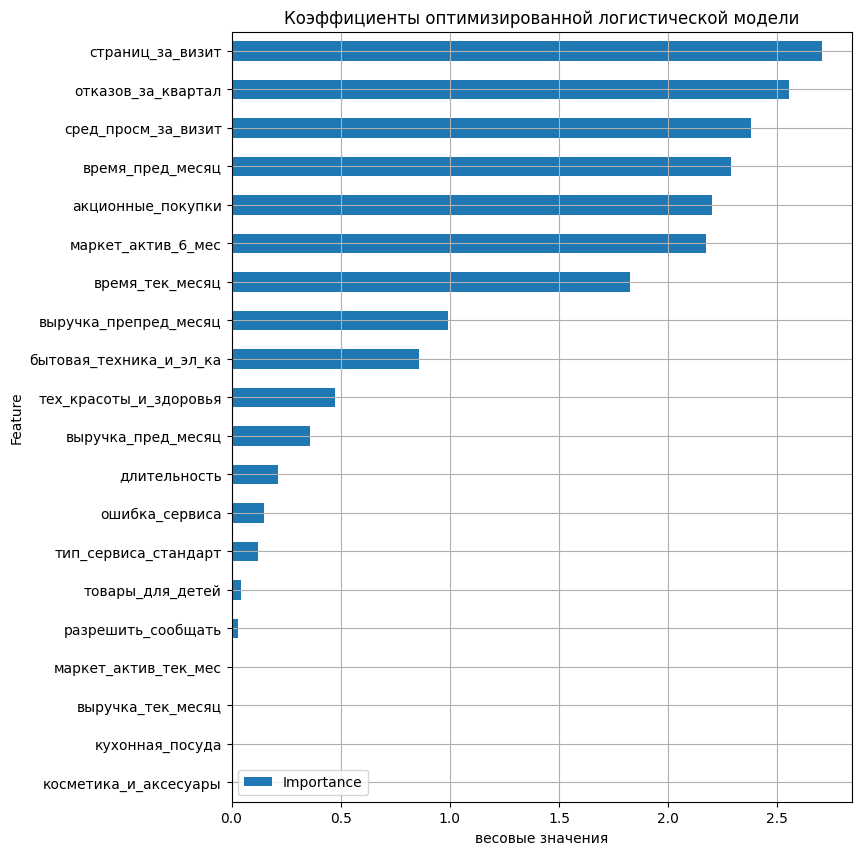

In [139]:
# коэффициенты логистической регрессии
coefficients = randomized_search.best_estimator_['models'].coef_[0]

# формирование таблицы важности признаков
feature_importance = pd.DataFrame(
    {
        'Feature': train_new.columns, 
        'Importance': np.abs(coefficients)
    })

# визуализация весов коэффициентов весов оптимизированной логистической модели
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', grid=True, figsize=(8, 10))
plt.title(f'Коэффициенты оптимизированной логистической модели')
plt.xlabel('весовые значения'); 

#### Выделение важных признаков путем максимизации значений метрики ROC-AUC при валидации тренировочной выборки

In [140]:
# вывод метрики при кросс-валидации
print()
print('Расчет метрики ROC-AUC при разных значениях feature_importance["Importance"]:')
print()

# цикл по вычислению метрики ROC-AUC при разных порогах feature_importance["Importance"]
# вывод результатов расчета метрик для разных пороговых значений
for i in range(0,12):
    # формирование списка признаков более i
    features_to_drop = feature_importance[
        feature_importance['Importance'] <= 0.2*i
    ]['Feature'].to_list()

    # удаление признаков из датасета
    X_train_less_features = train_new.drop(columns=features_to_drop)

    # подсчет метрики при кросс-валидации
    score = cross_val_score(
        randomized_search.best_estimator_['models'],                     
        X_train_less_features,
        y_train,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

    # вывод метрики при заданной i-ой важности признаков
    print(f'порог {(i*0.2):.1f}: {score:.3f}')


Расчет метрики ROC-AUC при разных значениях feature_importance["Importance"]:

порог 0.0: 0.900
порог 0.2: 0.901
порог 0.4: 0.902
порог 0.6: 0.902
порог 0.8: 0.902
порог 1.0: 0.900
порог 1.2: 0.900
порог 1.4: 0.900
порог 1.6: 0.900
порог 1.8: 0.900
порог 2.0: 0.894
порог 2.2: 0.876


In [141]:
# отбор признаков по оптимальному значению порога важности признака 
# и его весовому коэффициенту регрессии
print('РЕЗУЛЬТАТ ОТБОРА ПРИЗНАКОВ:')
print(feature_importance.query('Importance >= 0.2').sort_values('Importance', ascending=False))

РЕЗУЛЬТАТ ОТБОРА ПРИЗНАКОВ:
                    Feature  Importance
14         страниц_за_визит        2.70
12       отказов_за_квартал        2.55
11      сред_просм_за_визит        2.38
18         время_пред_месяц        2.29
10        акционные_покупки        2.20
7        маркет_актив_6_мес        2.17
19          время_тек_месяц        1.82
15    выручка_препред_месяц        0.99
2   бытовая_техника_и_эл_ка        0.86
3    тех_красоты_и_здоровья        0.48
16       выручка_пред_месяц        0.36
9              длительность        0.21


*Результат.*

Фильтрация признаков позволила позволила отобрать 14 признаков при оптимальном пороговом значении важности признака **0.4**: **'страниц_за_визит', 'отказов_за_квартал', 'сред_просм_за_визит', 'время_пред_месяц', 'маркет актив 6 мес', 'акционные_покупки', 'время_тек_месяц', 'выручка_препред_месяц', 'бытовая техника и эл-ка', 'выручка_пред_месяц', 'тех красоты и здоровья', 'выручка_тек_месяц', 'длительность', 'ошибка_сервиса'.**

### Отбор признаков на основе статистического теста SelectKBest

#### Отбор на основе оценки взаимной информации между признаками

In [142]:
print('ОТОБРАННЫЕ ПРИЗНАКИ:')
#  тест на основе линейной зависимости между входным и целевым признаком
selector = SelectKBest(mutual_info_classif, k=14) 
selector.fit(train_new, y_train)
features_names = train_new.columns[selector.get_support(indices=True)]
print('Тест на основе линейной зависимости:', list(features_names))

ОТОБРАННЫЕ ПРИЗНАКИ:
Тест на основе линейной зависимости: ['бытовая_техника_и_эл_ка', 'тип_сервиса_стандарт', 'маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'сред_просм_за_визит', 'отказов_за_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препред_месяц', 'выручка_пред_месяц', 'выручка_тек_месяц', 'время_пред_месяц', 'время_тек_месяц']


*Результат.*

Совпадение по 13 признакам по сравнению с п.6.1.2.

#### Отбор признаков по выручке от продаж покупателям в текущем месяце

Здесь проводился эксперимент с использованием следующего критерия.

При отборе признаков с помощью лучшей модели целесообразной представляется минимизация ошибки второго рода (**FN**), то есть случаев ошибочных предсказаний стабильной активности покупателей, но при эжтом, на самом деле, снижения активности покупателей вопреки прогнозу.

Количество ошибочных предсказаний равно **FN**. Этому показателю соответсвует выручка за текущий месяц **fn** по данной группе покупателей.

Ниже произведен отбор признаков (формирование их состава) на основе минимизации сумм потенциальных потерь, соответствующих ошибке **FN**.

In [143]:
# списки для итогового вывода результатов
roc_auc = []
money = []
y_train = pd.DataFrame(data=y_train, columns=['покупательская_активность'])

# параметры для вывода результатов
min_select = 100000000000
features_names_select = []
i_select=0

# заголовки столбцов
print('количество   roc-auc     доход за тек. мес.')
print('признаков                    усл.ед.')
print()

# датафреймы для анализа из п.5.2.7
X_train_select =  train_new.copy()

# лучшая модель
model = randomized_search.best_estimator_['models']

# циклический отбор признаков по максимальной выручке за 3 мес.
for i in range(len(X_train_select.columns)):
    # объявление селектора 
    # для подбора разного количества признаков за счёт цикла
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_select, y_train)
    
    # сохранение названия признаков в переменную features_names
    features_names = selector.get_feature_names_out()

    # формирование датафреймов с новым количеством признаков
    X_train_new = X_train_select[list(features_names)]
    
    # инициализация и обучение модели
    model.fit(X_train_new, y_train)
    
    # подсчет метрики при кросс-валидации
    score = cross_val_score(
        model,                     
        X_train_new,
        y_train,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()
    
    # расчет метрики roc-auc для i-ой совокупности признаков
    roc_auc_new = score

    # создание таблицы предсказаний для подсчёта прогнозов и суммарной выручки
    predicts = X_train_select[['выручка_тек_месяц']].copy() 
    predicts['progn'] = cross_val_predict(model, X_train_new, y_train, n_jobs=-1)
    predicts['y_train'] = y_train['покупательская_активность']            
    
    # подсчет выручки по клиентам, активность по которым снизилась при предсказанной стабильной активности
    fn = predicts[(predicts['progn']==0)&(predicts['y_train']==1)]['выручка_тек_месяц'].sum()
    
    # выбор оптимального количества признаков и их перечня
    if  fn < min_select:
        min_select = fn
        features_names_select = features_names
        i_select = i + 1
    
    # заполнение списков для вывода результатов
    roc_auc.append(roc_auc_new)
    money.append(fn)
    
    # вывод результаатов
    if i+1 < 10:
        print(f'    {i+1}         {roc_auc_new:.3f}            {fn:.0f}')
    else:
        print(f'    {i+1}        {roc_auc_new:.3f}            {fn:.0f}')
        
print()
print(f'Отобрано {i_select} признаков:')
print()
print(features_names_select)

количество   roc-auc     доход за тек. мес.
признаков                    усл.ед.

    1         0.813            36
    2         0.845            38
    3         0.857            37
    4         0.867            36
    5         0.886            38
    6         0.891            37
    7         0.900            36
    8         0.900            37
    9         0.902            35
    10        0.902            36
    11        0.902            36
    12        0.901            36
    13        0.901            36
    14        0.901            36
    15        0.901            36
    16        0.901            36
    17        0.901            37
    18        0.900            35
    19        0.900            35
    20        0.899            35

Отобрано 9 признаков:

['бытовая_техника_и_эл_ка' 'маркет_актив_6_мес' 'акционные_покупки'
 'сред_просм_за_визит' 'отказов_за_квартал' 'страниц_за_визит'
 'выручка_препред_месяц' 'время_пред_месяц' 'время_тек_месяц']


*Результат.*

Отобраны 9 признаков, также входящие в состав признаов, отобранных в п.6.1.2 и п.6.2.1. Данному набору признаков при минимальной выручке (**34**) соответствует максимальный показатель метрики ROC-AUC (**0,902**).

### Анализ значимости признаков по методу SHAP

####  Диаграмма общей значимости признаков

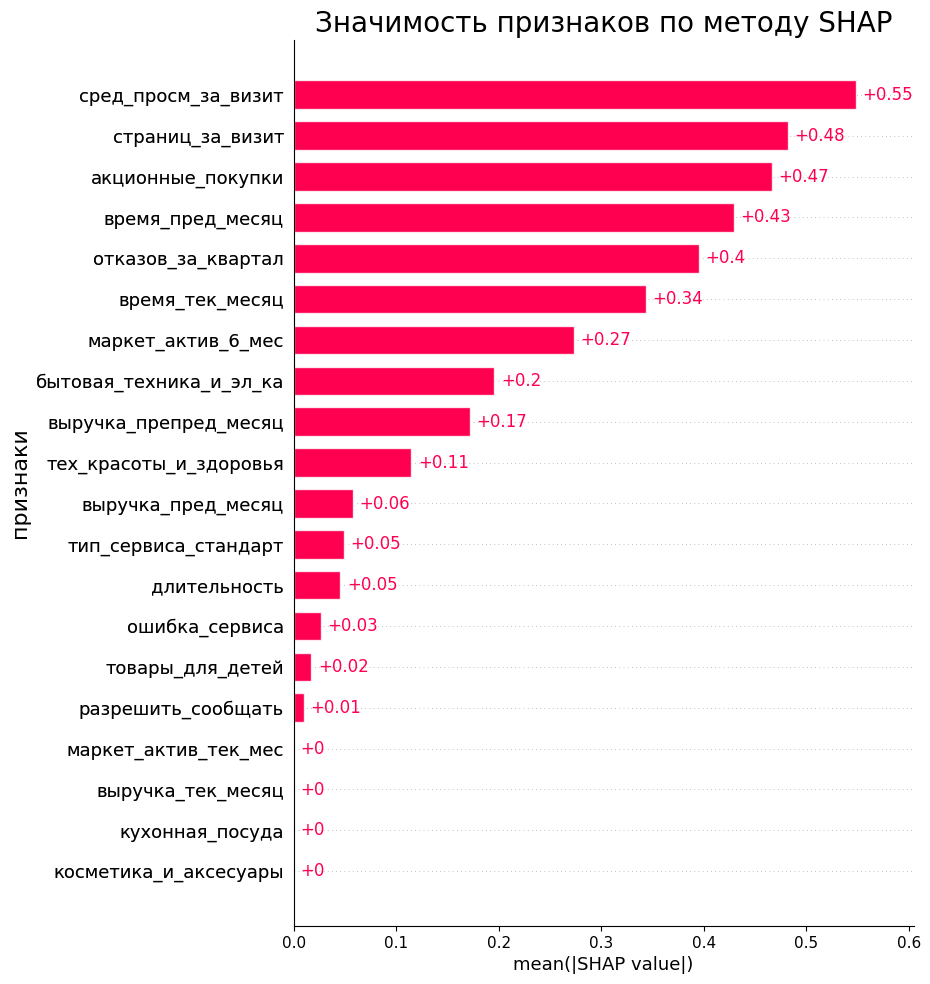

In [144]:
model = randomized_search.best_estimator_['models']
explainer = shap.LinearExplainer(model, test_new)
shap_values = explainer(test_new)

plt.title('Значимость признаков по методу SHAP', fontsize=20)
plt.ylabel('признаки', fontsize=16)
shap.plots.bar(shap_values, max_display=20) 
plt.show()

#### Анализ значимости признаков с их расширеной визуализацией

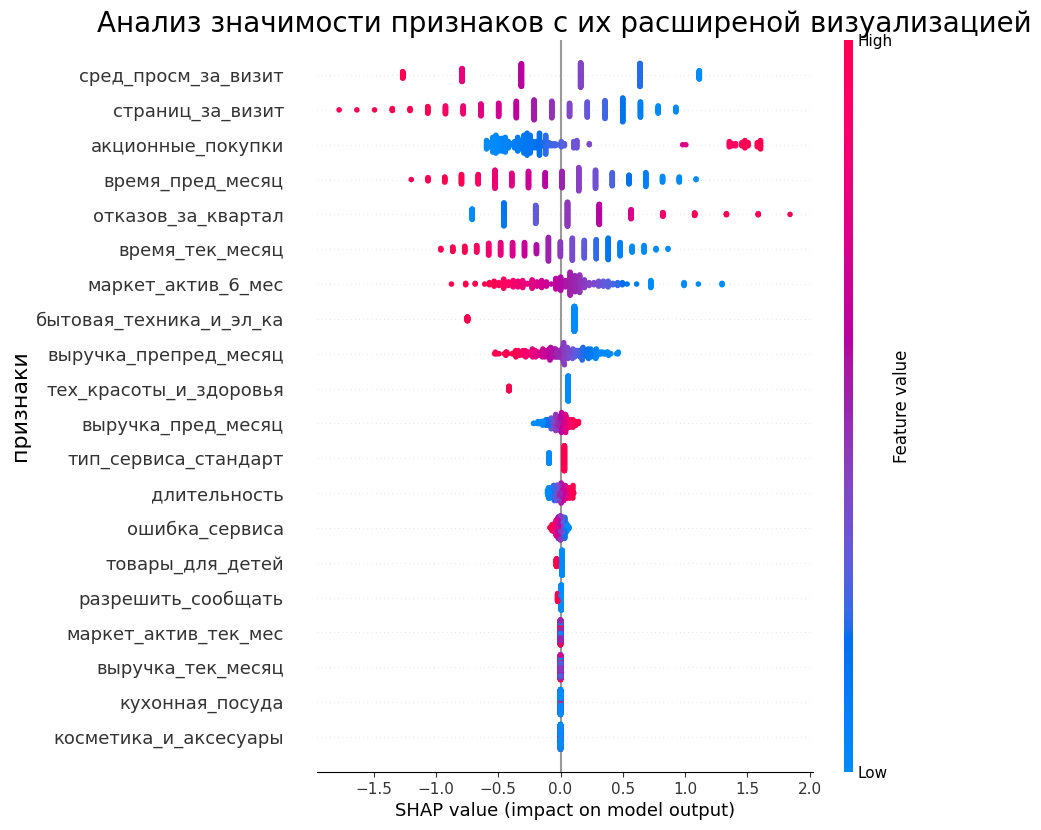

In [145]:
plt.title('Анализ значимости признаков с их расширеной визуализацией', fontsize=20)
plt.ylabel('признаки', fontsize=16)
shap.plots.beeswarm(shap_values, max_display=20)
plt.show()

#### Общие заключения по графику значимости признаков SHAP

**1.** Существенное время, проведимое покупателями на сайте интернет-магазина ('сред_просм_за_визит', 'страниц_за_визит', 'время_пред_месяц', 'время_тек_месяц'), говорит о привлекательности предложений и способствует сохранению активности покупателей.

**2.** Увеличение количества отказов от покупок обуславливает снижение интереса клиентов к интернет-ресурсу.

**3.** Выделяется группа покупателей с повышенным участием в акциях компании, но, в то же время, сокращающие свои покупки. Поведение данной категории клиентов целесообразно проанализировать.

**4.** Активная маркетинговая политика компании однозначно положительно сказывается на активности пользователей сайта. Снижение маркетинговых коммуникаций вызывает спад заинтересованности.

**5.** Отмечаются незначительная по составу группа клиентов, заинтересованных в регулярном (сохраняется интерес) приобретении бытовой техники и электронии, и группа, покупающая технику для красоты и здоровья.

### Выводы:

**1.** При анализе весовых коэффициентов логистической модели (п.6.1) важными классифицированы следующие 14 признаков:
* **'страниц_за_визит'** - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за 3 месяца;
* **'отказов_за_квартал'** - общее число неоплаченных товаров в корзине за последние 3 месяца;
* **'сред_просм_за_визит'** -  сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
* **'время_пред_месяц'** - время на сайте в минутах, зафиксированное за предыдущий месяц;
* **'маркет актив 6 мес'** -  среднемес. значение маркетинг. коммуникаций, которое приходилось на покупателя за 6 месяцев;
* **'акционные_покупки'** - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
* **'время_тек_месяц'** - время на сайте в минутах, зафиксированное за предыдущий месяц;
* **'выручка_препред_месяц'** - сумма выручки за препредыдущий месяц;
* **'бытовая техника и эл-ка'** - популярная категория "бытовая техника и электроника";
* **'выручка_пред_месяц'** - сумма выручки за предыдущий месяц;
* **'тех красоты и здоровья'** - 'популярная категория "техника для красоты и здоровья";
* **'выручка_тек_месяц'** - сумма выручки за текущий месяц;
* **'длительность'** - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;
* **'ошибка_сервиса'** - число сбоев, которые коснулись покупателя во время посещения сайта.

Остальные признаки при добавлении с исследуемую выборку ухудшают качество модели (метрика **'ROC-AUC'**) и могут быть признаны малозначимыми, а именно: 

**'тип_сервиса_стандарт', 'товары_для_детей', 'косметика и аксесуары', 'маркет_актив_тек_мес', 'разрешить_сообщать_нет', 'кухонная_посуда'**.

**2.** Схожий по большинству признаков результат отбора наиболее важных признаков дает метод **SelectKBest** (совпадение по 13 признакам с п.1 выводов, п.6.4).

**3.** В ходе работы над проетом в состав количественных признаков были включены дополнительные два признака, представляющие собой разность выручек по текущему и предыдущему, предыдущему и препредыдущему месяцам. Но, по итогам моделирования, добавление этих признаков ухудшило качество модели. При этом пайплайн отобрал ту же логистическую модель с теми же параметрами. Данные признаки были исключены из анализа. 

## Сегментация покупателей

При работе над проектом произведен анализ следующих сегментов покупателей:

* с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности;
*  покупающих только технику (товары с длинным жизненным циклом);
* с дефицитом маркетинговых коммуникаций с интернет-магазином.

### Подготовка к анализу признаков

#### формирование датафрейма X_test_df для изучения признаков

Данный датафрейм собран на основе тестового датафрейма **test_new** (см.5.2.7) и датафрейма **y_test**, содержащего вероятности присвоения целевому признаку 1 (снижение покупательской активности) и столбец 'прогноз_снижения' с информаацией о прогнозируемой активности.

#### Функция построения диаграмм рассеяния c разделением по целевому признаку

In [146]:
# СОЗДАНИЕ ТАБЛИЦЫ С ПРОГНОЗНЫМИ ЗНАЧЕНИЯМИ
# первая категория относится к 'прогноз_снижения'=1 (снижение активности)
# вторая категория относится к 'прогноз_снижения'=0 (активность сохранится)

X_test_df = pd.DataFrame(data=y_test, columns=['покупательская_активность'])

# добавление признака - вероятности снижения покупательской активности 
# для объектов тестовой выборки на основе лучшей модели (test_new из п.5.2.7)
X_test_df['probability'] = randomized_search.best_estimator_['models'].predict_proba(test_new)[:,1]

# добавление столбца с классификацией целевого признака по пороговому значению 0,5
X_test_df['прогноз_снижения'] = X_test_df['probability'].apply(lambda x: 1 if x>= 0.5 else 0)

# добавление признака прибыльности по покупателям
X_test_df = X_test_df.join(money_test)

# присоединение столбца test_new (взят из 5.2.7)
X_test_df = X_test_df.join(test_new)

# переименования для удобства при визуализации
X_test_df['покупательская_активность'] = X_test_df['покупательская_активность'].apply(lambda x: 'снижение' if x==1 else 'преж_уровень')
X_test_df['прогноз_снижения'] = X_test_df['прогноз_снижения'].apply(lambda x: 'снижение' if x==1 else 'преж_уровень')

X_test_df.head(3) # контроль создания датафрейма

покупательская_активность  probability прогноз_снижения  прибыль  \
0              преж_уровень         0.59         снижение     4.47   
1                  снижение         0.75         снижение     3.76   
2              преж_уровень         0.09     преж_уровень     4.34   

   косметика_и_аксесуары  кухонная_посуда  бытовая_техника_и_эл_ка  \
0                   0.00             0.00                     0.00   
1                   0.00             0.00                     0.00   
2                   1.00             0.00                     0.00   

   тех_красоты_и_здоровья  товары_для_детей  тип_сервиса_стандарт  ...  \
0                    1.00              0.00                  1.00  ...   
1                    0.00              0.00                  0.00  ...   
2                    0.00              0.00                  0.00  ...   

   акционные_покупки  сред_просм_за_визит  отказов_за_квартал  ошибка_сервиса  \
0               0.91                 0.00                0.10            0.00   
1               0.12                 0.40                0.30            0.44   
2               0.10                 0.40                0.10            0.56   

   страниц_за_визит  выручка_препред_месяц  выручка_пред_месяц  \
0              0.32                   0.70                0.53   
1              0.21                   0.52                0.72   
2              0.68                   0.82                0.62   

   выручка_тек_месяц  время_пред_месяц  время_тек_месяц  
0               0.52              0.59             0.84  
1               0.52              0.41             0.21  
2               0.45              0.71             0.47  

[3 rows x 24 columns]

In [147]:
# функция построения диаграмм рассеяния
def compare_plot(feature_1, feature_2, feature_3):
    plt.figure(figsize=(8, 6))
    plt.title(
        f'Зависимость признака "{feature_2}" от "{feature_1}" с разделением по признаку "{feature_3}"', 
        fontsize=12)
    plt.ylabel(feature_2, fontsize=10)
    plt.xlabel(feature_1, fontsize=10)
    sns.scatterplot(data=segm_df, 
                    x=feature_1, 
                    y=feature_2, 
                    hue=feature_3)
    plt.show()

#### Функция построения диаграмм влияния каждого признака на отдельные объекты (метод SHAP)

In [148]:
# функция построения диаграмм влияния признаков на целевой признак
def shap_fun(ind):
    for i in ind:
        print('Покупатель под индексом', i)
        shap.plots.waterfall(shap_values[i])

### Анализ сегмента клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности

#### Выделение сегмента с высокой вероятностью снижения покупательской активности

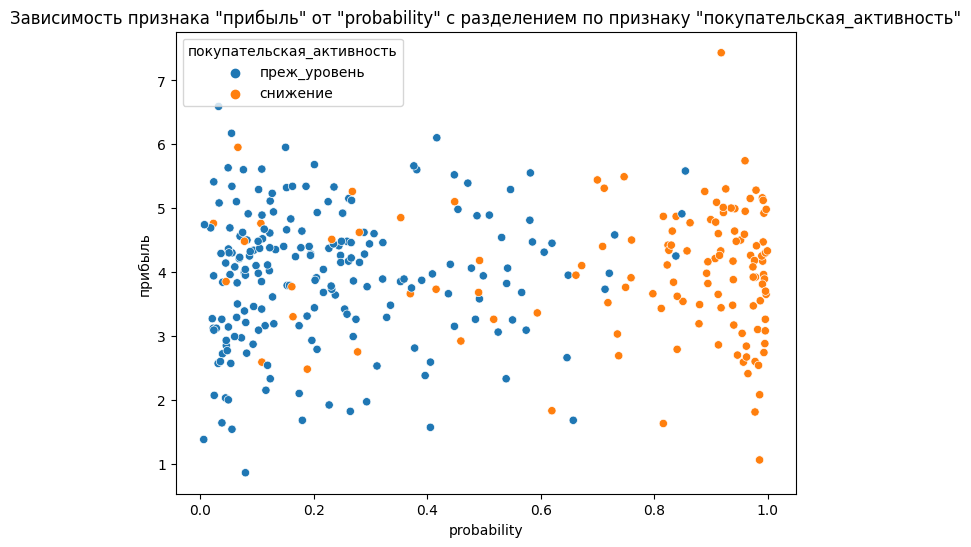

In [149]:
# определение границы сегмента по признаку 'probability'
segm_df = X_test_df

# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'прибыль', 'покупательская_активность')

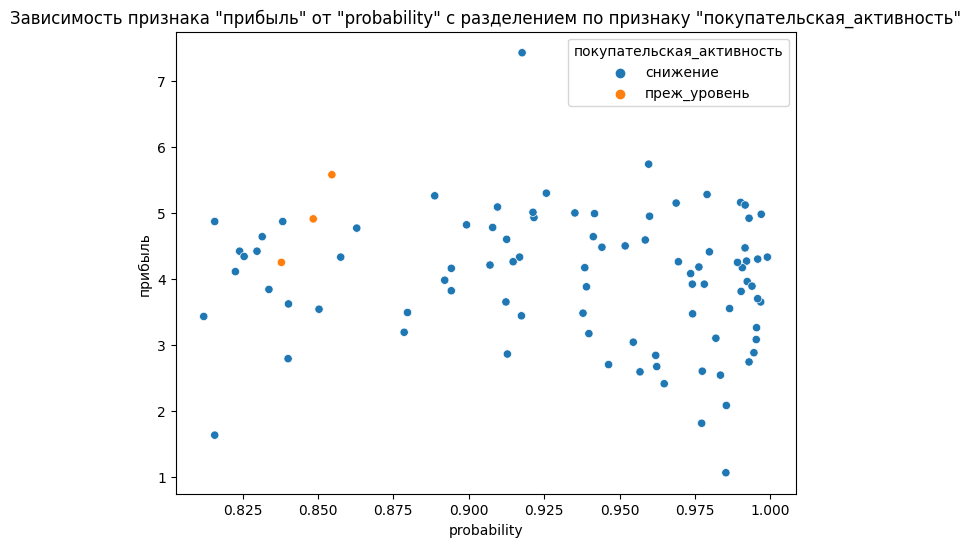

In [150]:
# формирование сегмента с высокими значениями 'probability'
segm_df = X_test_df.query('probability > 0.8')

# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'прибыль', 'покупательская_активность')

#### Выделение сегмента клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности 

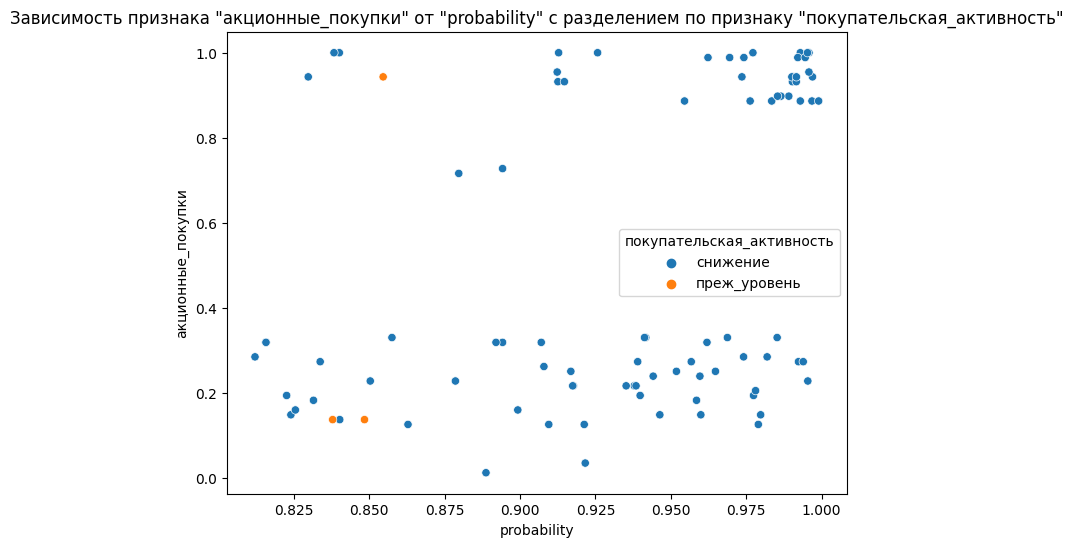

In [151]:
# зависимость долей покупок по акции от вероятности снижения покупательской активности
# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'акционные_покупки', 'покупательская_активность')

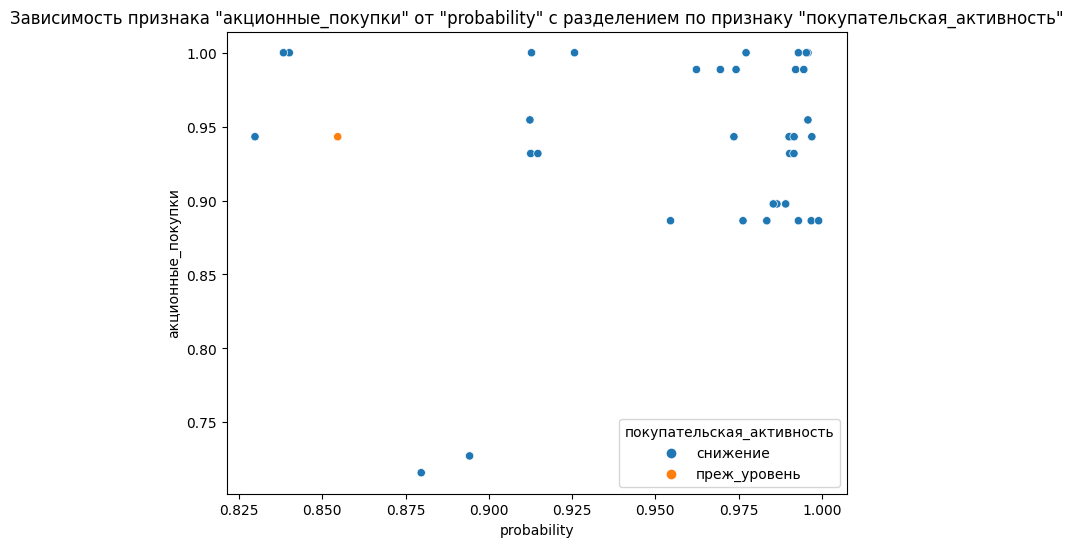

In [152]:
# формирование сегмента  сегмента клиентов с максимальной долей покупок по акции 
# и высокой вероятностью снижения покупательской активности
segm_df = segm_df.query('акционные_покупки > 0.7')

# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'акционные_покупки', 'покупательская_активность')

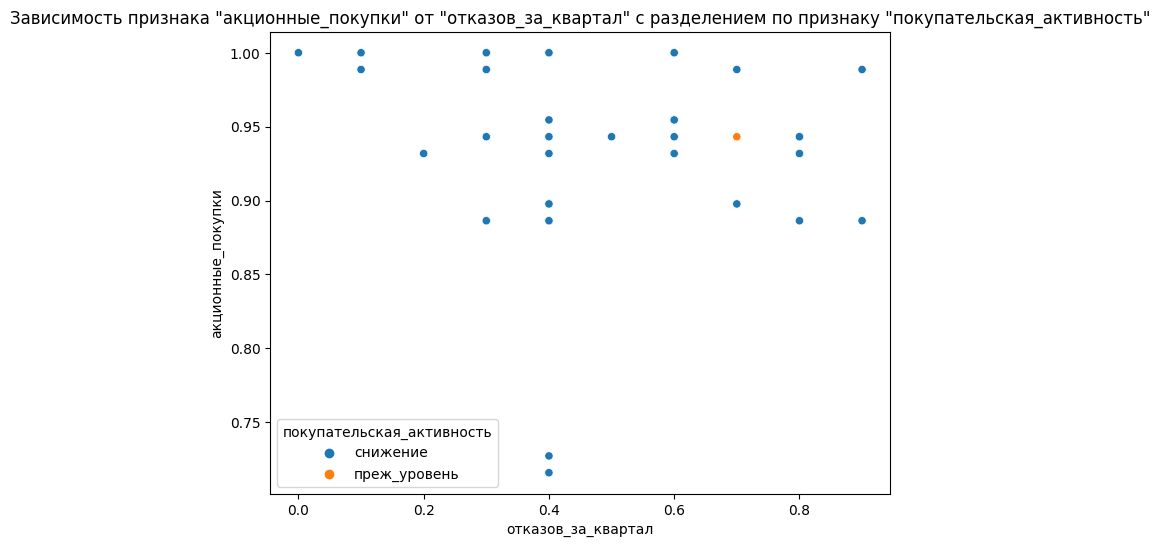

In [153]:
# формирование сегмента  сегмента клиентов с максимальной долей покупок по акции,
# (при высокой вероятности снижения покупательской активности)
# в зависиости от количества неоплаченных товаров
segm_df = segm_df.query('акционные_покупки > 0.7')

# вызов функции построения диаграммы рассеяния
compare_plot('отказов_за_квартал', 'акционные_покупки', 'покупательская_активность')

#### Анализ влияния отдельных признаков на классификацию целевого признака 

In [154]:
# нахождение индексов по объектам сегмента
segm_ind = segm_df.index

# вывод соответствующих индексов
print('Перечень индексов строк для рассматриваемого сегмента:')
display(segm_ind)

Перечень индексов строк для рассматриваемого сегмента:


Int64Index([ 10,  21,  22,  28,  34,  51,  66,  80,  84,  97, 100, 135, 146,
            158, 180, 182, 185, 196, 198, 200, 206, 224, 226, 231, 235, 237,
            247, 273, 276, 282, 284, 297, 298, 303, 304, 318, 322],
           dtype='int64')

ДИАГРАММЫ ВЛИЯНИЯ ОТДЕЛЬНЫХ ПРИЗНАКОВ НА ЦЕЛЕВОЙ ДЛЯ ОБЪЕКТОВ СЕГМЕНТА

Покупатель под индексом 10


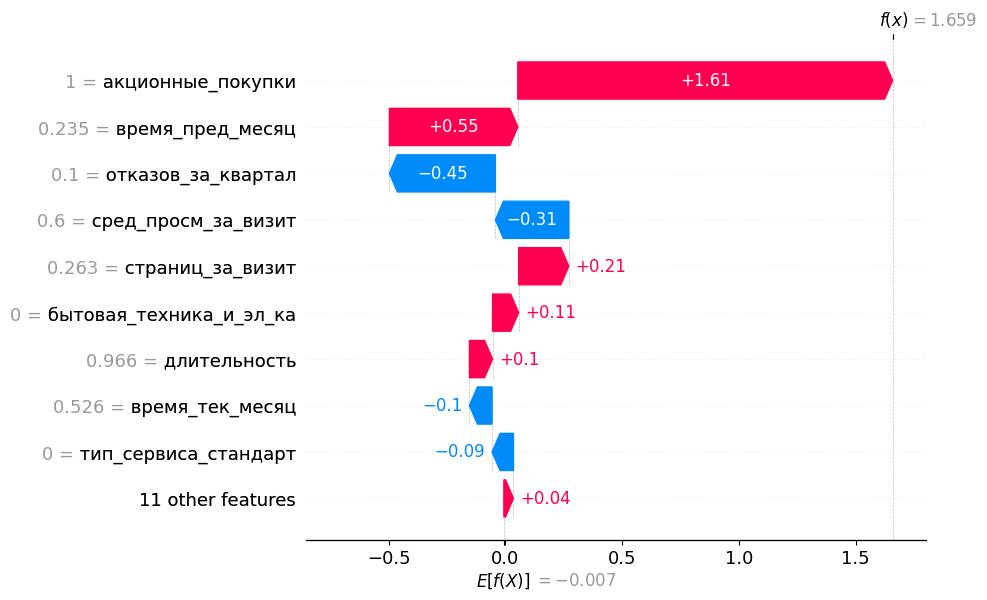

Покупатель под индексом 21


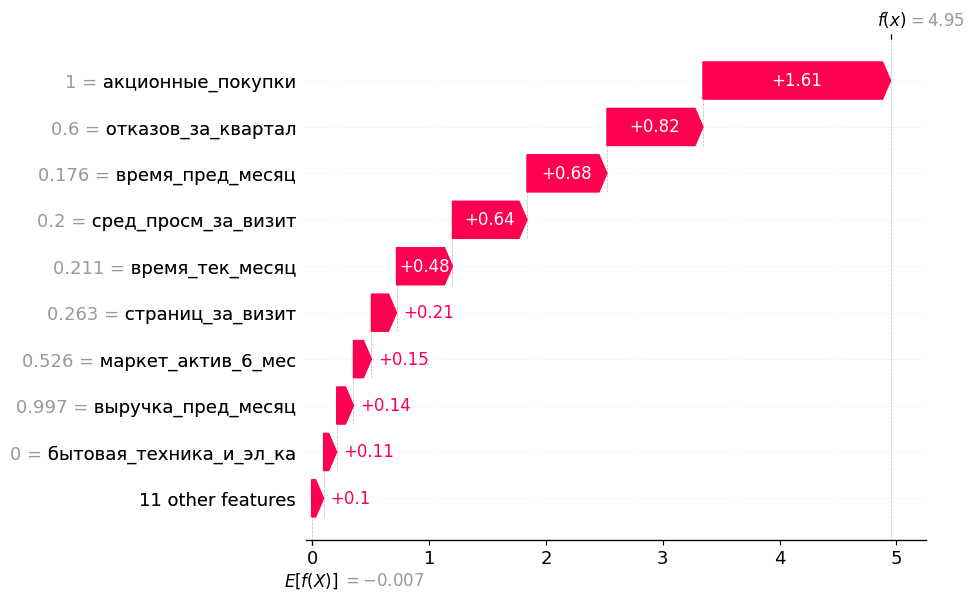

Покупатель под индексом 22


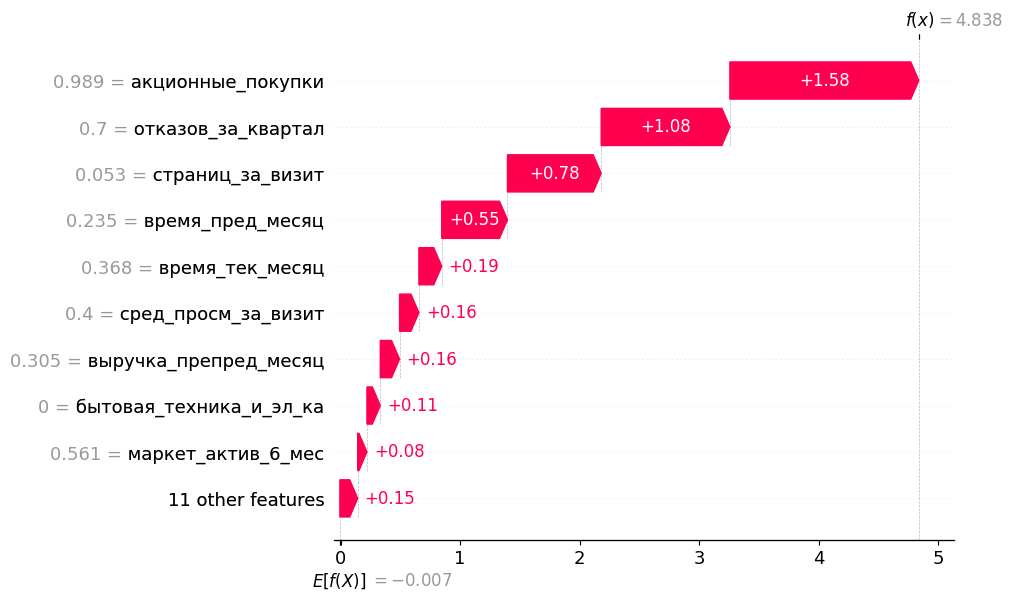

Покупатель под индексом 28


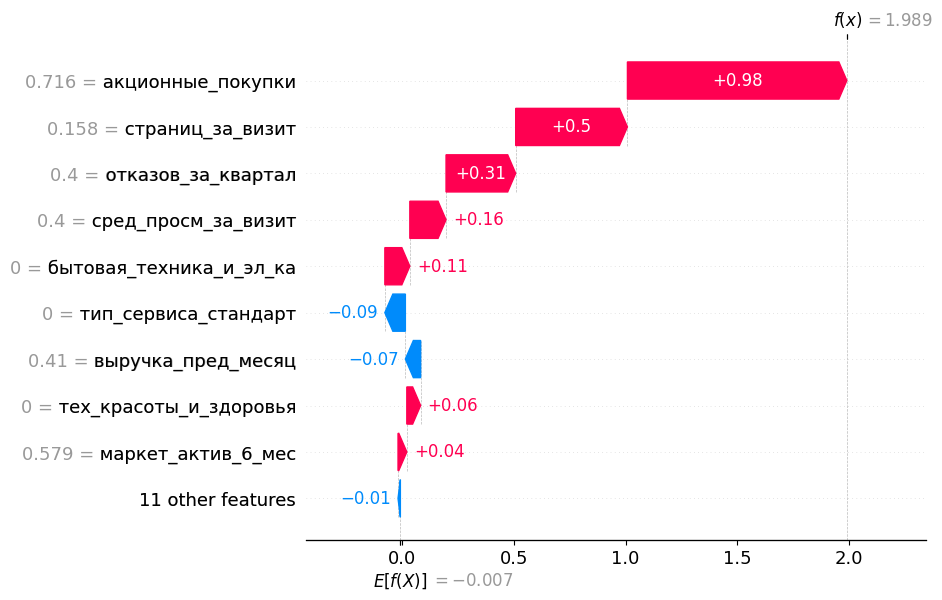

Покупатель под индексом 34


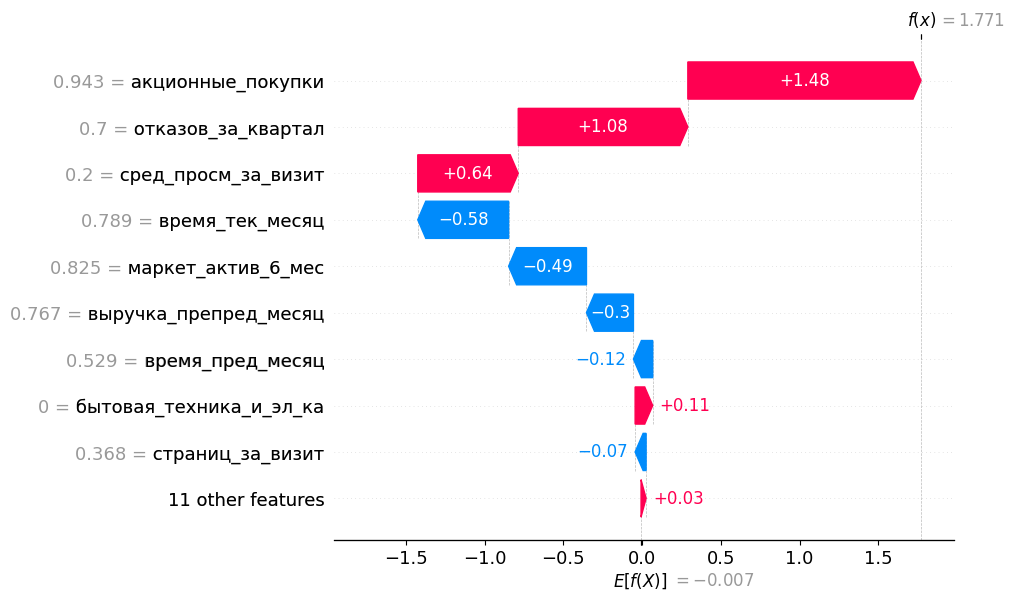

Покупатель под индексом 51


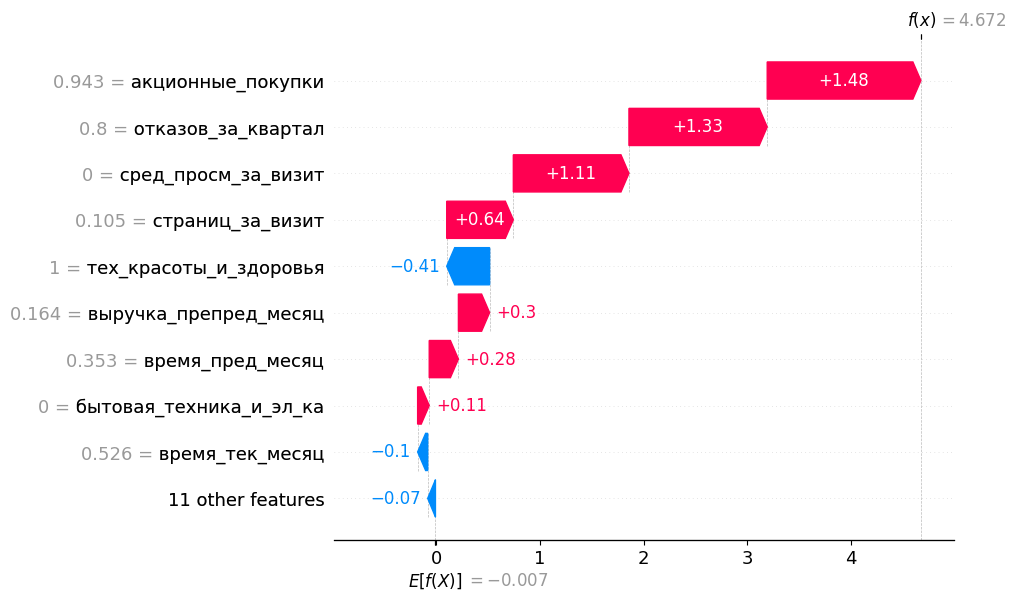

Покупатель под индексом 66


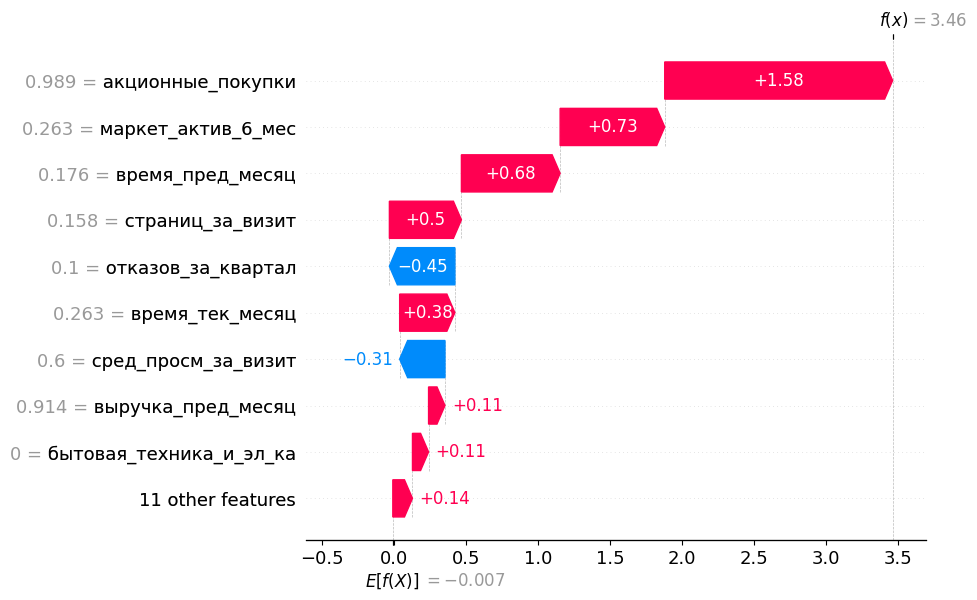

Покупатель под индексом 80


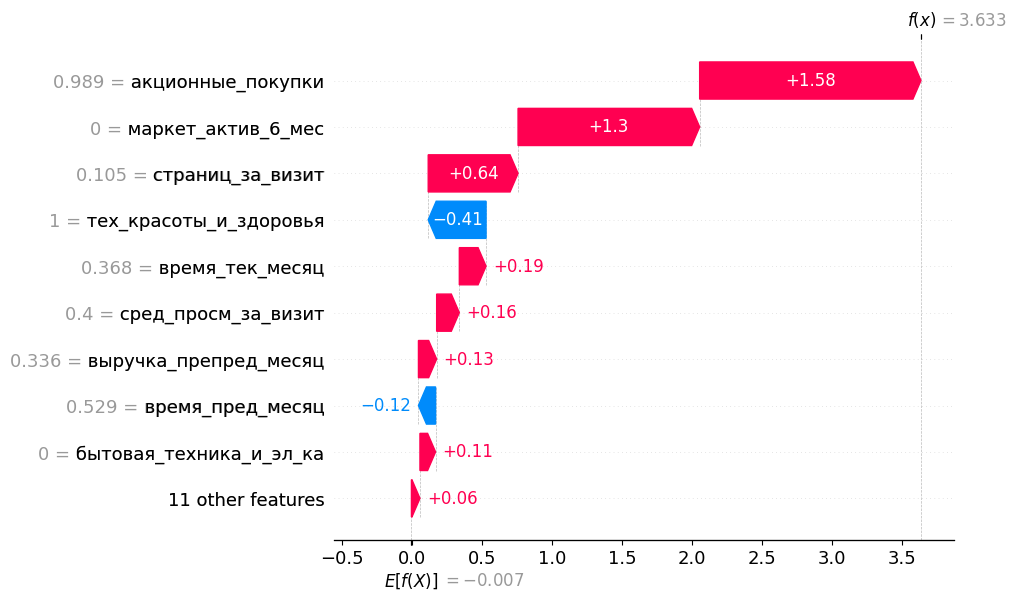

Покупатель под индексом 84


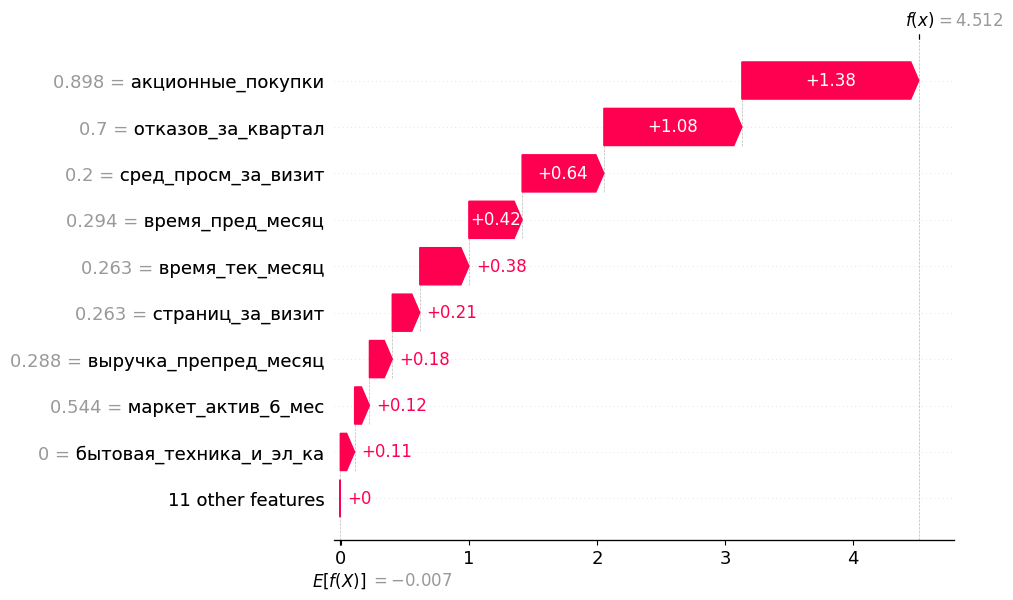

Покупатель под индексом 97


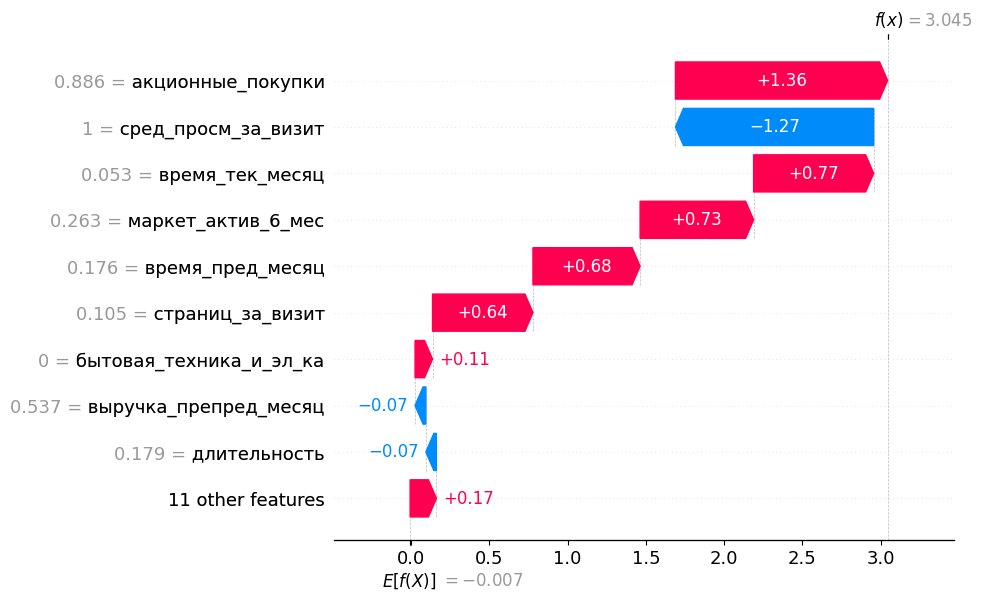

In [155]:
# влияние признаков на типичные объекты анализа (10 первых индексов для примера)
list_act = [10,  21,  22,  28,  34,  51,  66,  80,  84,  97]

print('ДИАГРАММЫ ВЛИЯНИЯ ОТДЕЛЬНЫХ ПРИЗНАКОВ НА ЦЕЛЕВОЙ ДЛЯ ОБЪЕКТОВ СЕГМЕНТА')
print()

# функция построения диаграмм влияния отдельных признаков
shap_fun(list_act)

*Результат.*

Характеристики покупателей сегмента:
* высокая активность участия в акциях компании;
* значительное количество неоплаченных товаров в корзине за последние 3 месяца;
* низкие среднемесячные значение маркетинговых коммуникаций компании с покупателями за последние 6 месяцев;
* низкие значения среднего количества категорий, просмотренных покупателем за визит в течение последнего месяца;
* низкие значения времени, проведенного на сайте.

Данный сегмент представляет собой покупателей, краткосрочно пользующихся интернет-ресурсом сайта для покупки товаров в период проведения акций. При прекращении проведения акций интерес к интернет-магазину у этой группы покупателей падает, снижается покупательская активность, о чем свидетельствуют: 1) низкие значения среднего количества категорий, просмотренных покупателем за визит в течение последнего месяца; 2) низкие значения времени, проведенного на сайте.

Одним из ключеввых признаков, существенно влияющих на снижение активности покупателей из данного сегмента, являются низкие маркетинговые коммуникации копмпании с ними (число рассылок, звонков, показов рекламы и прочего).

Практически по всем покупателям рассматриваемого сегмента отмечаются случаи неоплаты некоторых товаров. Предположительно данное обстоятельство связано с тем, что пользователи ресурса заказывают товары по акциям с избытком для выбора (ассортимента) и в пункте выдачи отказываются от части товаров. Значительное количество отказов от оплаты влечет за собой для компании дополнительные издержки, связанные с возвратом товаров на склады из пунктов выдачи. 

*Рекомендации заказчику:*

1.Разработка мероприятий по активизации маркетинговых коммуникаций в отношении покупателей из данного сегмента.

2.Расширение ассортимента за счет товаров с более низкими по сранению с имеющимися ценовыми уровнями, расчитанными на рассматриваемых покупателей.

3.С целью сокращения издержек компании по возврату неоплаченных товаров предусмотреть для данного сегмента покупателей ограничение количества заказываемых позиций по акциям.


### Анализ сегмента клиентов, покупающих товары с длинным жизненным циклом

#### Выделение сегмента покупателей товаров с длительным жизненным циклом (техника и посуда)

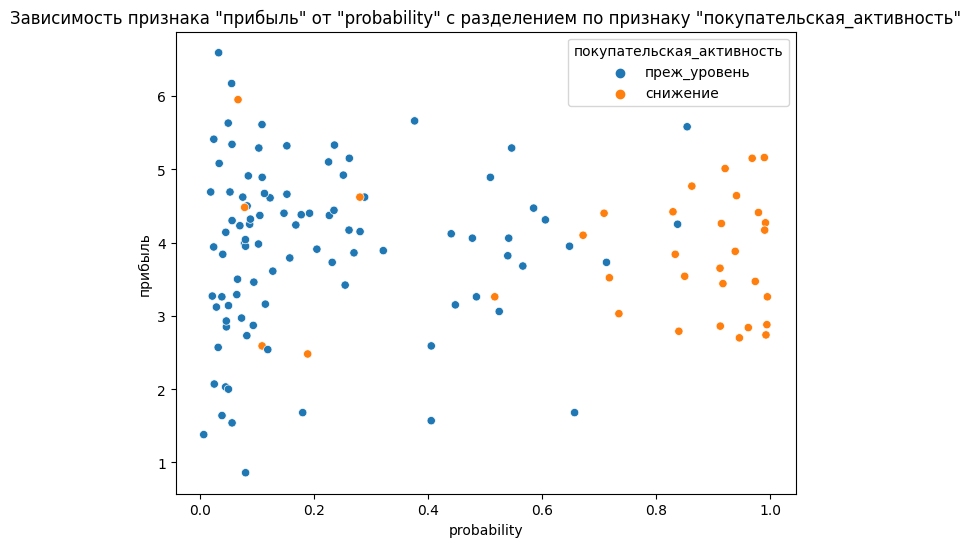

In [156]:
# выделение сегмента покупателей, приобретающих только товары длительного жизненного цикла
segm_df = X_test_df.query('((бытовая_техника_и_эл_ка == 1) or (кухонная_посуда == 1) or \
(тех_красоты_и_здоровья == 1)) and ((косметика_и_аксесуары == 0) or (товары_для_детей ==0))')

# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'прибыль', 'покупательская_активность')

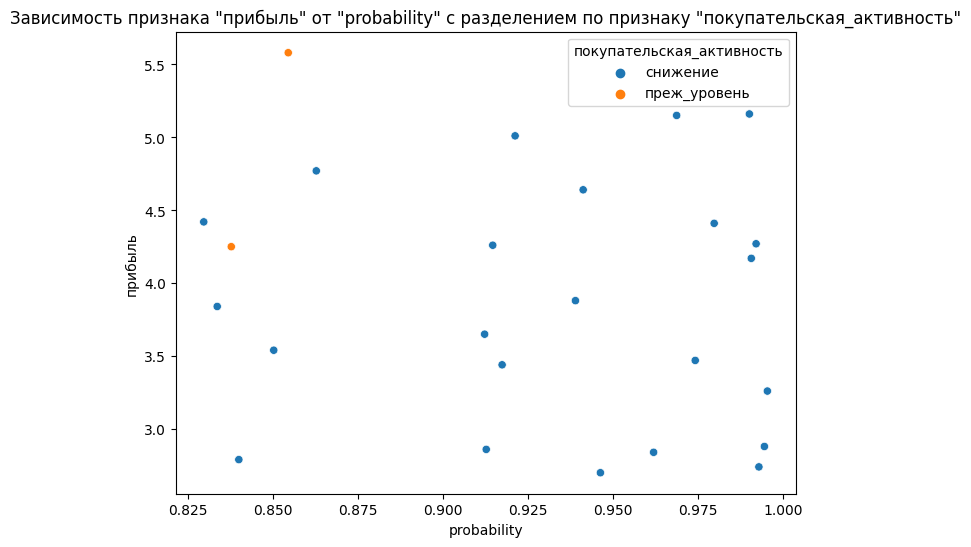

In [157]:
# формирование сегмента с высокими значениями 'probability' (признак снижения пок. активности)
segm_df = segm_df.query('probability > 0.8')

# вызов функции построения диаграммы рассеяния
compare_plot('probability', 'прибыль', 'покупательская_активность')

#### Анализ влияния отдельных признаков на классификацию целевого признака 

In [158]:
# нахождение индексов по объектам сегмента
segm_ind = segm_df.index

# вывод индексов по выбранным объектам
print('Перечень индексов строк для рассматриваемого сегмента:')
display(segm_ind)

Перечень индексов строк для рассматриваемого сегмента:


Int64Index([ 10,  19,  21,  22,  34,  51,  52,  62,  80, 163, 185, 194, 196,
            200, 230, 233, 247, 266, 269, 271, 284, 293, 296, 298, 324],
           dtype='int64')

ДИАГРАММЫ ВЛИЯНИЯ ОТДЕЛЬНЫХ ПРИЗНАКОВ НА ЦЕЛЕВОЙ ДЛЯ ОБЪЕКТОВ СЕГМЕНТА

Покупатель под индексом 10


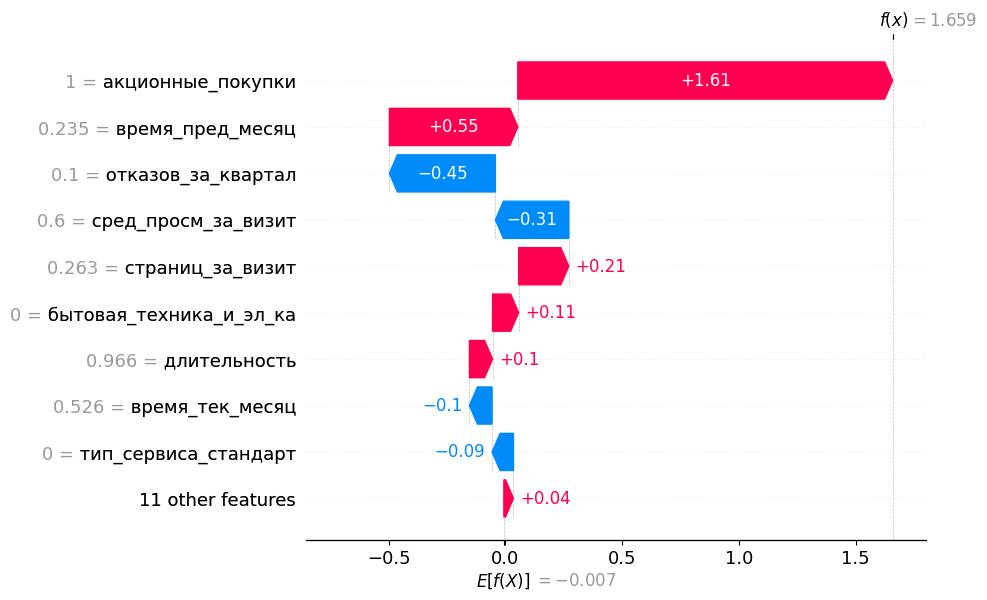

Покупатель под индексом 19


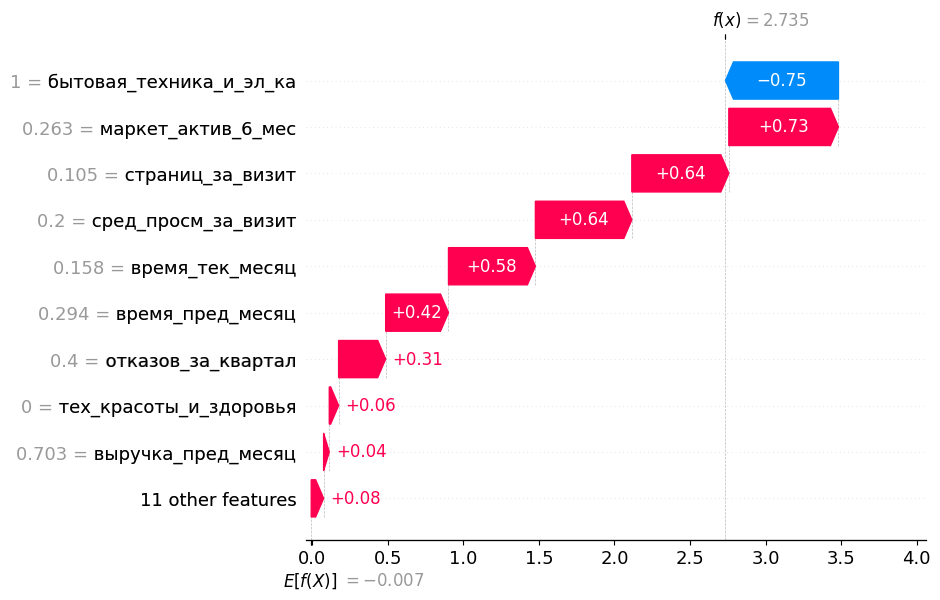

Покупатель под индексом 21


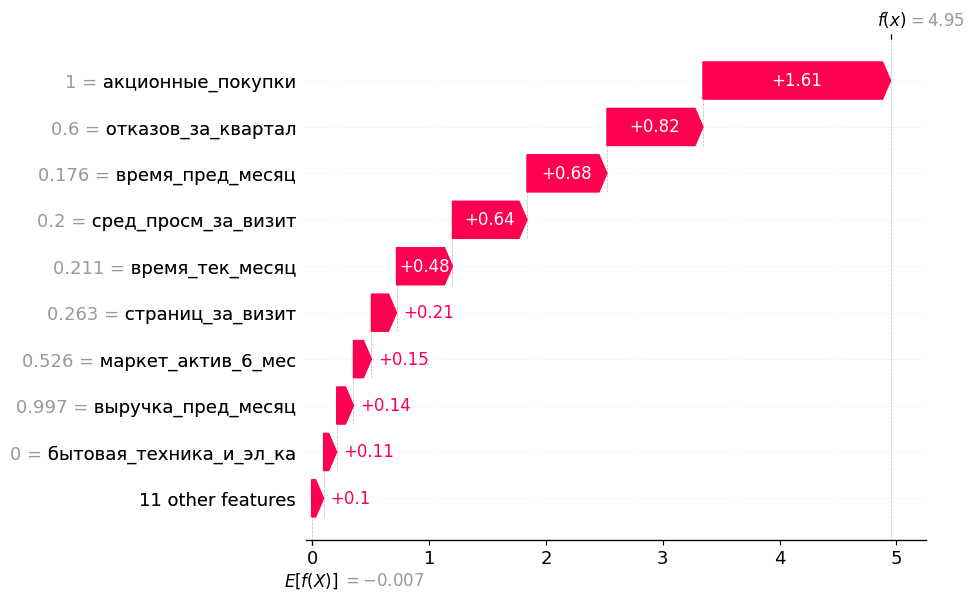

Покупатель под индексом 22


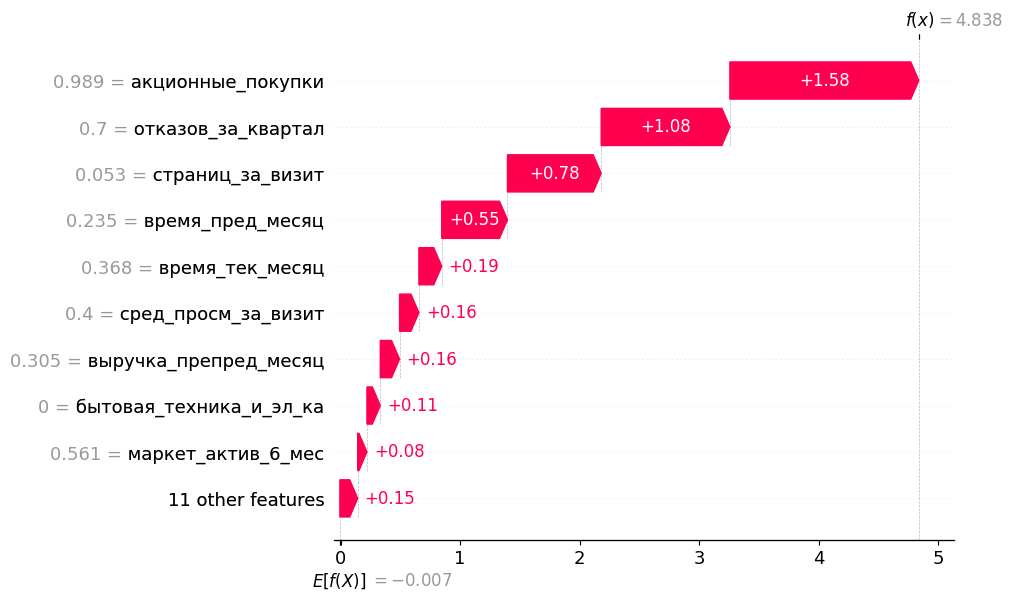

Покупатель под индексом 34


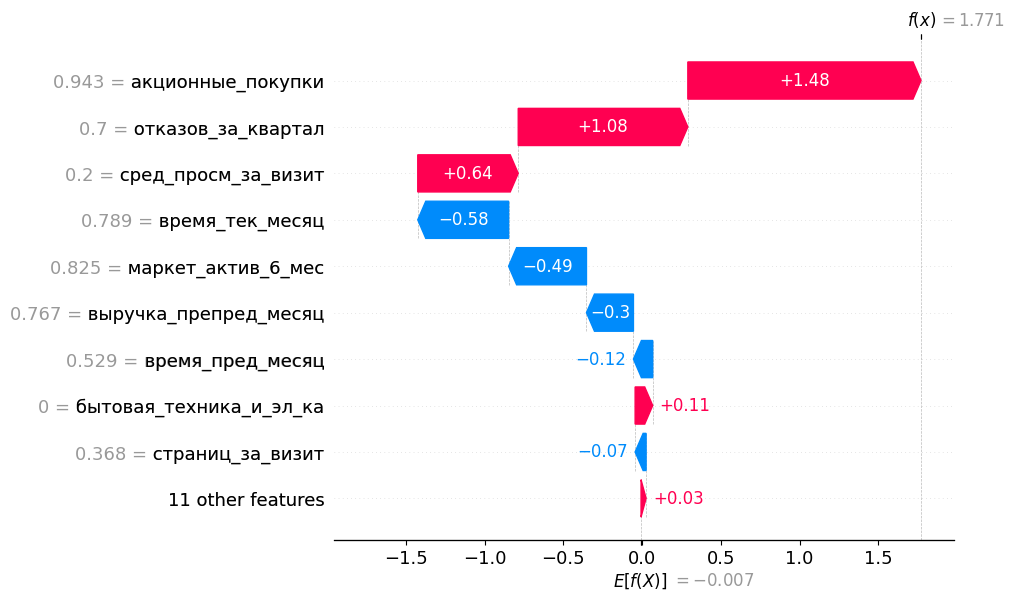

Покупатель под индексом 51


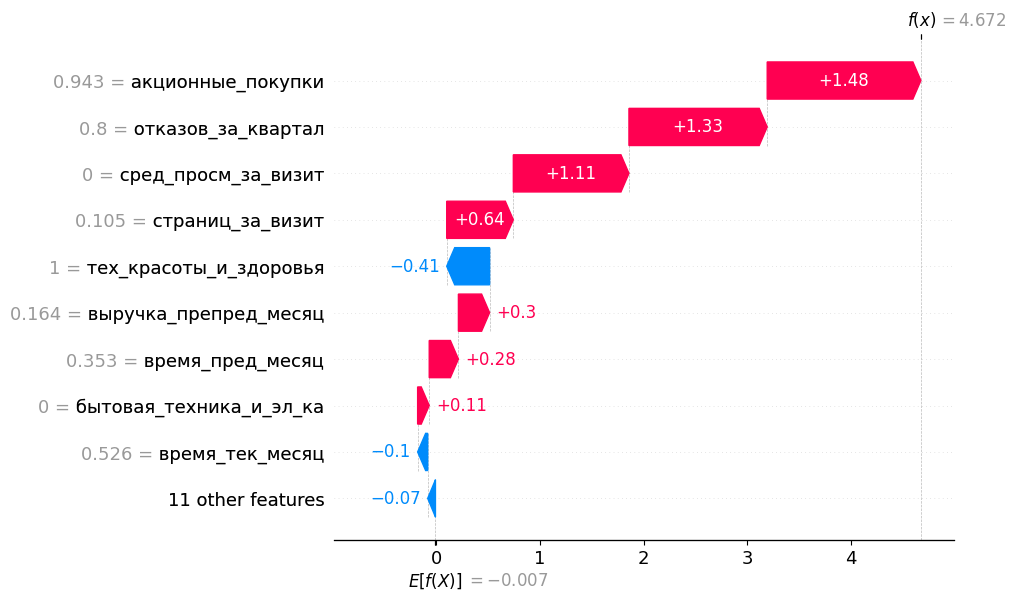

Покупатель под индексом 52


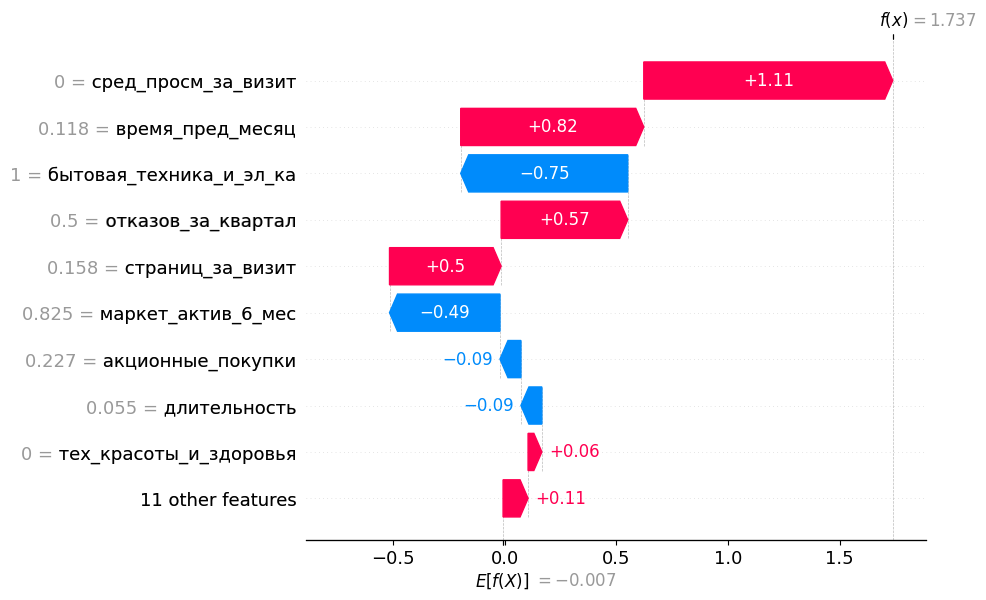

Покупатель под индексом 62


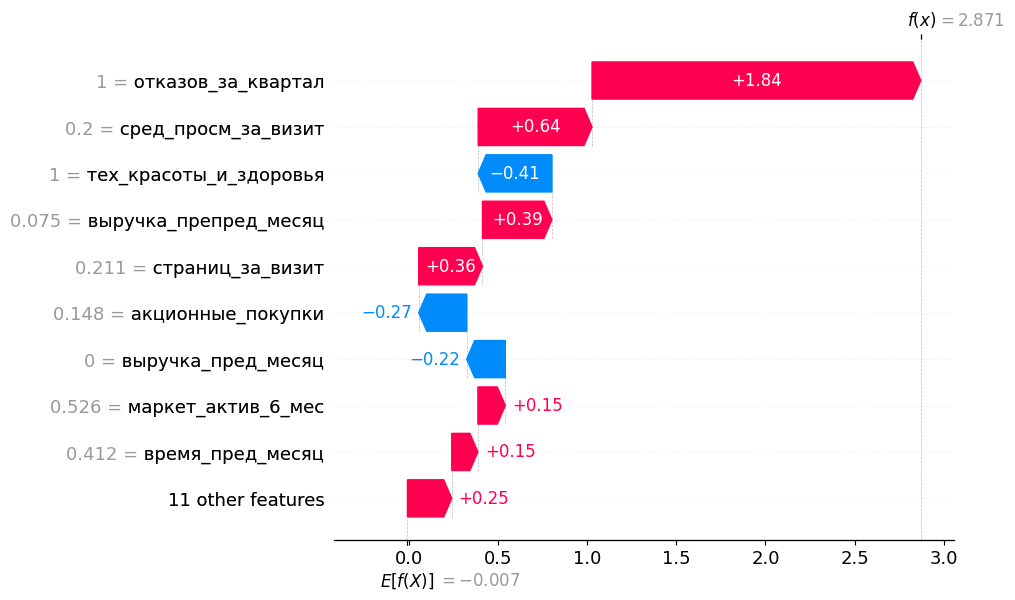

Покупатель под индексом 80


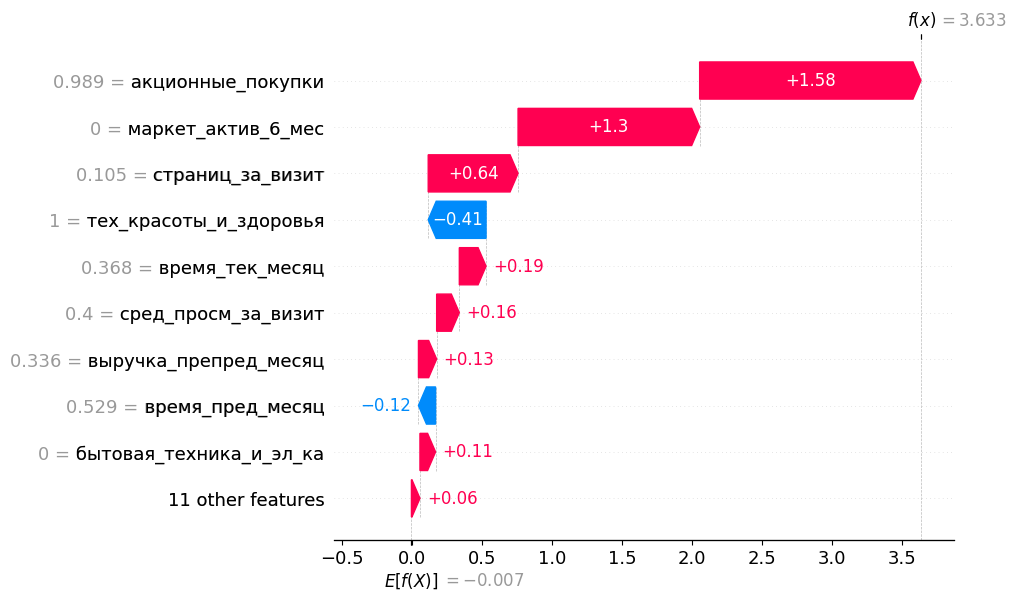

Покупатель под индексом 163


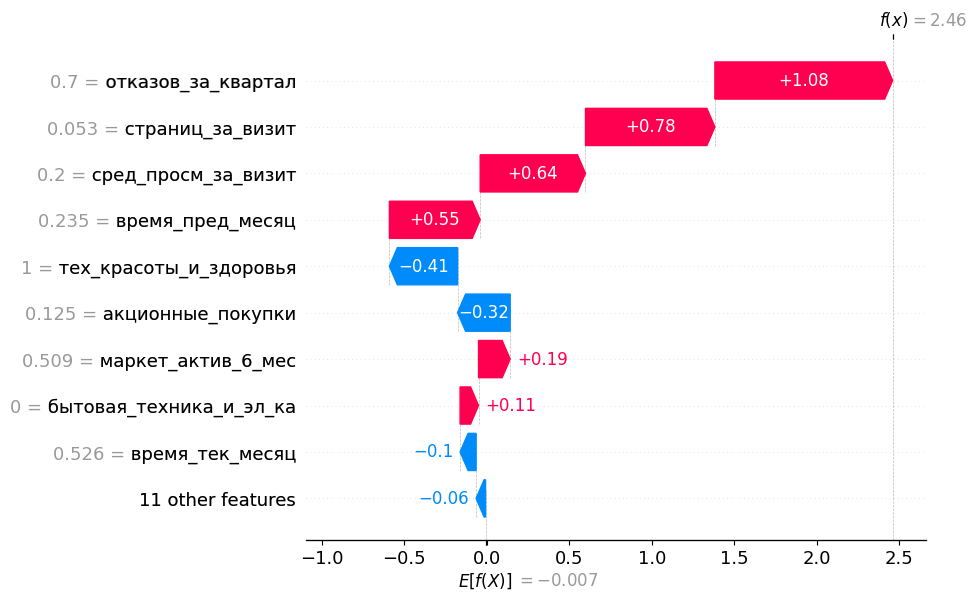

In [159]:
# влияние признаков на типичные объекты анализа (10 первых индексов для примера)
list_act = [10,  19,  21,  22,  34,  51,  52,  62,  80, 163]

print('ДИАГРАММЫ ВЛИЯНИЯ ОТДЕЛЬНЫХ ПРИЗНАКОВ НА ЦЕЛЕВОЙ ДЛЯ ОБЪЕКТОВ СЕГМЕНТА')
print()

# функция построения диаграмм влияния отдельных признаков
shap_fun(list_act)

*Результат.*

Характеристики покупателей сегмента:
* высокая активность участия в акциях компании;
* значительное количество неоплаченных товаров в корзине за последние 3 месяца;
* низкие средние значения количества страниц, которые просмотрели покупатели за один визит на сайт за последние 3 месяца.

Среди покупателей товаров с длительным жизненным циклом преобладают активные пользователи акционных покупок, целеноправленно выбирающие группы товаров со скидками (о чем свидетельствуеют незначительные количества посещаемых страниц сайта магазина).

*Рекомендации заказчику:*

1.Доработка интерфейса сайта с целью поддержания интереса пользователей сайта к ресурсу, например:
* закрепления на страницах с предлагаемыми по акции товарами ссылок на другие страницы сайта с потенциально интересными для покупателей данного сегмента предложениями;
* публикация на страницах с акционными товарами объявлений о проведении следующих акций и т.д.

2.С целью снижения количества неоплаченных товаров анализ необходимости доработки интерфейса формирования заказа товаров.

## Выводы

В задачу проекта входила разработка решения, позволяющего персонализировать предложения постоянным клиентам интернет-магазина для увеличения их покупательской активности. Для чего построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. Используя данные модели необходимо выделить сегменты покупателей и разработать для них персонализированные предложения.

Исходные данные для работы находились в нескольких таблицах, содержащих информацию по следующим группам признаков:
* коммуникации с клиентом;
* продуктивное поведение;
* поведение на сайте;
* финансовое поведение.

Для удобства работы над проектом данные были сведены в один датафрейм.

В ходе предобработки данных осуществлялась их проверка на наличие пропусков, полных дубликатов, наличие неявных дубликатов в категориальных признаках. Были обнаружены и устранены неявные дубликаты.

В процессе исследовательского анализа данных были выявлены и устранены аномалии (выбросы) в данных (путем замены на медианные значения). Также сделан вывод о необходимости масштабирования значений исходных данных и стратификации целевого признака.

Для поиска лучшей модели использовался пайплайн. Во время подготовки данных применялся **ColumnTransformer**. Количественные и категориальные признаки обрабатывались в пайплайне раздельно. Для кодирования категориальных признаков были использованы два кодировщика (**OneHotEncoder** и **LabelEncoder**), для масштабирования количественных — два скейлера (**StandardScaler** и **MinMaxScaler**). 

Обучались четыре модели: **DecisionTreeClassifier(), LogisticRegression() и  SVC()**. Для каждой из них подберался как минимум один гиперпараметр. Для задачи была выбрана метрика **roc_auc**, ее выбор аргументирован в выводах к разделу 5 (п.5.3). Данная метрика использовалась при подборе гиперпараметров.

В качестве лучшей была выбрана модель: **LogisticRegression(C=2, penalty='l1', random_state=42, class_weight='balanced', solver='saga').**

После выбора лучшей модели была произведена ее доработка на предмет повышения качества модели:
* добавление в модель настройки **class_weight**;
* подбор оптимальных значений метрик качества **(precision, recall, f1)**.

Все результаты работы детально изложены в ходе проекта, подробные выводы к разделам сведены в **п.1.3, п.2.4, п.3.4, п.4.3, п.5.3, п.6.4, п.7.2.3, п.7.3.2.**

В ходе проекта были установлены следующие важные признаки:

* **'отказов_за_квартал'** - общее число неоплаченных товаров в корзине за последние 3 месяца;
* **'страниц_за_визит'** - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за 3 месяца;
* **'сред_просм_за_визит'** -  сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
* **'акционные_покупки'** - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
* **'время_пред_месяц'** - время на сайте в минутах, зафиксированное за предыдущий месяц;
* **'маркет актив 6 мес'** -  среднемес. значение маркетинг. коммуникаций, которое приходилось на покупателя за 6 месяцев;
* **'время_тек_месяц'** - время на сайте в минутах, зафиксированное за предыдущий месяц;
* **'бытовая техника и эл-ка'** - один из классов популярной категории товаров;
* **'выручка_препред_месяц'** - траты покупателей за препредыдущий месяц;
* **'выручка_пред_месяц'** - траты покупателей за предыдущий месяц;
* **'тех красоты и здоровья'** - один из классов популярной категории товаров;
* **'выручка_тек_месяц'** - траты покупателей за предыдущий месяц.

В заключении проекта **(раздел 7)**  производилась сегментация покупателей. Используя результаты моделирования и данные о прибыльности покупателей проведилось графическое и аналитическое исследование групп покупателей.

Анализировалась группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. При анализе данного сегмента покупателей, проявляющих высокую активность в акциях компании по льготной продаже товаров, было установлено, что подавляющее большинство представителей этой группы предположительно являются эпизодическими (временными) пользователями услуг интернет-магазина, заинтересованными в бюджетных покупках. По ним зафиксирована слабая маркетинговая коммуникация компании, низкая посещаемость сайта при высоком уровне отказов от покупок. Из этого сделано предположение о наличии узкого ассортимента товаров для данной целевой аудитории. В связи с чем, руководству компании предлагается провести исследование ценовых предложений по всем группам товаров и, при необходимости, расширить их ассортимент. После чего предусмотреть пути активизации маркетинговых мероприятий для более активного предложения товаров данным покупателям.

При анализе сегмента пользователей, приобретающих только товары длительного жтзненного цикла, было установлено, что в подавляющем большинстве данные товары покупаются ими по акциям.

**Рекомендации руководству компании "В один клик"!**

1.Разработка мероприятий по активизации маркетинговых коммуникаций в отношении покупателей рассмотренных сегментов.

2.Расширение ассортимента интернет-магазина за счет товаров с более низкими по сранению с имеющимися ценовыми уровнями.

3.С целью сокращения издержек компании по возврату неоплаченных по акциям товаров предусмотреть для рассмотренных сегментов покупателей ограничение количества заказываемых позиций по акциям.

4.Доработка интерфейса сайта с целью поддержания интереса вышеуказанных пользователей сайта к ресурсу, например:
* закрепления на страницах с предлагаемыми по акции товарами ссылок на другие страницы сайта с потенциально интересными для этих покупателей предложениями;
* публикация на страницах с акционными товарами объявлений о проведении следующих акций и т.д.

5.Расширение состава признаков и проведение дополнительных исследований на предмет установления причин неоплаты заказанных товаров.